In [3]:
0.000000000000211

2.11e-13

In [1]:
#  한 라이브러리 임포트&설치
# !pip install dbfread
# !pip install haversine
# !pip install sklearn
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from haversine import haversine
from tqdm.notebook import tqdm
%matplotlib inline
import platform
import pickle
import re
platform.system()
if platform.system() == 'Darwin': # Mac 환경 폰트 설정
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows': # Windows 환경 폰트 설정
    plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정
%config InlineBackend.figure_format = 'retina'

In [2]:
def pklopen(route):
    with open('./가공한데이터/{}'.format(route), 'rb') as f:
        df = pickle.load(f)
    return df
def pklsave(df, name):
    with open('{}.pkl'.format(name), 'wb') as f:
        pickle.dump(df, f)

In [3]:
#행정구/동 매칭
dong = pd.read_excel('./data/서울시_행정동_법정동_20200814.xlsx')
#행정동별 거주인구
dong_pop = pklopen('행정동별_거주인구_성별_연령.pickle')
#2015년 결혼상태
married_rate = pd.read_csv('./data/서울시 혼인상태별 인구(15세 이상) 통계.txt', sep='\t')
#맞벌이 가구비율(2012년부터)
both_rate = pd.read_excel('./data/맞벌이 가구비율.xls')
#행정동별 세대수
dong_family = pd.read_csv('./data/행정동별 세대수(17년 12월).txt', sep='\t')
#행정동별 전체인구수
total_ppl = pd.read_pickle('./data/행정동별 전체 인구.pkl')
#귀가시 어른이 맞아주시는 비율
comebackhome = pd.read_csv('./data/귀가_시__부모님_등_어른의_맞이_횟수_20201009190404.csv', encoding='cp949')

In [4]:
# #워킹맘 보고서 2018, 워킹맘 초등학생 자녀 평균 하원, 하교시간
# working_kids = {'4시이전 하원, 하교(%)':[79.6], '4시~5시 하원, 하교(%)':[14.8], '5시이후 하원, 하교(%)':[5.6]}

In [5]:
home_rate_5 = pd.read_csv('./아동 분석_작업중/오후_4시대_오후_4시4시_59분__수업을_마치고_가장_많이_있는_장소_20201009190502.csv', encoding='cp949')
home_rate_7 = pd.read_csv('./아동 분석_작업중/저녁_6시대_저녁_6시6시_59분__수업을_마치고_가장_많이_있는_장소_20201009190539.csv', encoding='cp949')

In [6]:
# working_kids_df = pd.DataFrame(working_kids, index=['초등학생 비율'])
# working_kids_df

# 전처리

### 틈새비율(5시~7시 집에서, 아무도 맞이해주지 못하는 초등학생 비율)

In [7]:
comebackhome = comebackhome.rename(columns=comebackhome.iloc[0]).drop(comebackhome.index[0])
comebackhome['가끔 맞이해 주신다 (%)'] = comebackhome['가끔 맞이해 주신다 (%)'].astype(float)
comebackhome['항상 맞이해 주시지 못한다 (%)'] = comebackhome['항상 맞이해 주시지 못한다 (%)'].astype(float)

comebackhome

,특성별(1),특성별(2),사례수 (명),항상 맞이해 주신다 (%),가끔 맞이해 주신다 (%),항상 맞이해 주시지 못한다 (%)
1,전체,소계,8563,66.6,24.3,9.1
2,성별,남자,4318,68.3,23.2,8.4
3,성별,여자,4245,64.8,25.4,9.8
4,교급별,초등1년~초등3년,2847,71.2,19.3,9.4
5,교급별,초등4년~초등6년,2996,63.1,27.7,9.2
6,교급별,중등1년~중등3년,2720,65.4,25.8,8.8
7,지역별,서울,1322,71.1,20.9,8.0
8,지역별,인천/경기,2547,66.2,24.5,9.2
9,지역별,대전/충청/세종/강원,1320,63.3,26.4,10.3
10,지역별,광주/전라/제주,1241,61.3,27.4,11.3


In [8]:
alone_element_rate = (comebackhome['가끔 맞이해 주신다 (%)'].iloc[3:5].mean()+comebackhome['항상 맞이해 주시지 못한다 (%)'].iloc[3:5].mean())/100
alone_element_rate

0.32799999999999996

In [9]:
# working_kids_df

In [10]:
# after_five_rate = working_kids_df['5시이후 하원, 하교(%)'].iloc[0]/100
# after_five_rate

In [11]:
# #5시 이후 하원, 하교하는 초등학생 비율 × 귀가 시 집에 아무도 없는 초등학생 비율
# alone_after_five_rate = (alone_element_rate * after_five_rate).round(4)
# alone_after_five_rate

In [12]:
home_rate_5=home_rate_5.rename(columns=home_rate_5.iloc[0]).drop(home_rate_5.index[0])
home_rate_7=home_rate_7.rename(columns=home_rate_7.iloc[0]).drop(home_rate_7.index[0])

In [13]:
home_rate_5['사례수 (명)'] = home_rate_5['사례수 (명)'].astype(float)
home_rate_5['집 (%)'] = home_rate_5['집 (%)'].astype(float)
home_rate_5

,특성별(1),특성별(2),사례수 (명),학교(수업) (%),학교(초등돌봄 방과후 학교) (%),교과목 관련 학원 (%),태권도 도장 (%),예체능 관련 학원 (%),지역 아동센터 방과후 아카데미 (%),도서관 등 공공시설 (%),동네 독서실 공부방 등 (%),동네 주변 놀이터 공원 등 (%),분식점 매점 식당 등 (%),집 (%),기타 (%)
1,전체,소계,8511.0,3.8,4.3,27.6,4.2,9.6,1.6,1.0,1.7,3.8,1.7,36.6,4.1
2,성별,남자,4290.0,3.9,3.9,26.5,5.7,7.5,1.5,0.8,1.7,4.3,1.5,36.8,6.0
3,성별,여자,4221.0,3.7,4.8,28.8,2.6,11.9,1.7,1.2,1.6,3.3,2.0,36.4,2.1
4,교급별,초등1년~초등3년,2809.0,0.4,5.4,16.7,9.6,19.2,2.7,0.9,1.4,5.3,0.6,35.1,2.7
5,교급별,초등4년~초등6년,2996.0,0.6,4.6,42.9,2.1,7.4,1.8,1.0,2.5,4.3,1.2,28.3,3.3
6,교급별,중등1년~중등3년,2706.0,10.3,3.8,23.4,0.6,2.8,0.4,1.1,1.1,1.7,3.1,45.3,6.4
7,지역별,서울,1300.0,2.2,4.8,33.3,2.8,9.4,1.2,1.4,1.1,3.2,1.3,34.3,4.9
8,지역별,인천/경기,2537.0,2.0,3.0,26.7,3.6,10.8,1.5,1.0,1.5,4.7,1.7,39.8,3.5
9,지역별,대전/충청/세종/강원,1312.0,4.7,5.3,23.4,4.7,8.3,2.9,0.7,1.5,3.9,1.4,38.6,4.5
10,지역별,광주/전라/제주,1230.0,6.5,7.6,27.5,5.2,10.9,2.4,1.3,1.8,2.8,2.0,28.5,3.5


In [14]:
home_rate_7['사례수 (명)'] = home_rate_7['사례수 (명)'].astype(float)
home_rate_7['집 (%)'] = home_rate_7['집 (%)'].astype(float)
home_rate_7

,특성별(1),특성별(2),사례수 (명),학교(수업) (%),학교(초등돌봄 방과후 학교) (%),교과목 관련 학원 (%),태권도 도장 (%),예체능 관련 학원 (%),지역 아동센터 방과후 아카데미 (%),도서관 등 공공시설 (%),동네 독서실 공부방 등 (%),동네 주변 놀이터 공원 등 (%),분식점 매점 식당 등 (%),집 (%),기타 (%)
1,전체,소계,8470.0,0.3,0.7,26.7,3.6,5.1,1.0,0.4,1.0,1.5,0.5,56.3,3.0
2,성별,남자,4279.0,0.3,0.8,25.5,4.8,4.8,0.9,0.3,0.8,1.6,0.5,56.0,3.6
3,성별,여자,4191.0,0.2,0.6,28.1,2.4,5.4,1.1,0.4,1.2,1.3,0.4,56.6,2.2
4,교급별,초등1년~초등3년,2789.0,0.1,0.3,4.2,5.1,4.7,1.3,0.3,0.3,1.0,0.3,80.2,2.4
5,교급별,초등4년~초등6년,2992.0,0.2,0.4,22.4,4.8,6.8,1.1,0.6,1.2,2.5,0.6,56.5,2.8
6,교급별,중등1년~중등3년,2689.0,0.6,1.3,53.4,0.8,3.7,0.6,0.4,1.3,0.9,0.5,32.8,3.6
7,지역별,서울,1293.0,0.4,0.5,32.3,3.2,6.3,0.9,0.5,0.6,1.2,0.1,50.0,3.8
8,지역별,인천/경기,2522.0,0.1,0.5,25.5,3.7,6.2,1.0,0.2,1.0,2.0,0.4,56.6,2.9
9,지역별,대전/충청/세종/강원,1308.0,0.5,0.5,22.0,3.3,4.9,1.8,0.6,0.8,1.4,0.8,60.3,3.1
10,지역별,광주/전라/제주,1229.0,0.4,0.6,24.7,3.5,4.1,0.9,0.5,1.0,1.5,0.7,59.4,2.8


In [15]:
# #오후 5시 이전에 집에 있는 초등학생 비율
# home_5 = ((home_rate_5.iloc[3,2]*home_rate_5.iloc[3,13] + home_rate_5.iloc[4,2]*home_rate_5.iloc[4,13])/(home_rate_5.iloc[3,2]+home_rate_5.iloc[4,2]))/100
# home_5

In [16]:
#오후 7시 이전에 집에 있는 초등학생 비율
home_7 = ((home_rate_7.iloc[3,2]*home_rate_7.iloc[3,13] + home_rate_7.iloc[4,2]*home_rate_7.iloc[4,13])/(home_rate_7.iloc[3,2]+home_rate_7.iloc[4,2]))/100
home_7

0.6793388687078361

In [17]:
# #5시에서 집에 도착해서 7시까지 집에 있는 초등학생의 비율
# home_5_7 = (home_7 - home_5)
# home_5_7

In [18]:
AR = alone_element_rate * home_7
AR

0.22282314893617022

### 동별 3040대 맞벌이 부부 & 결혼율 & 동별 0514인구 반영 돌봄 지수

In [19]:
#동별 코드/구 매칭자료(후에 라벨링에서 사용 됨)
dong = dong[dong['시도명']=='서울특별시']
dong_df = dong[['행정동코드','시군구명']].dropna().drop_duplicates()
dong_df['행정동코드'] = dong_df['행정동코드'].astype(str)


dong_df

,행정동코드,시군구명
1,1111000000,종로구
2,1111051500,종로구
12,1111053000,종로구
24,1111054000,종로구
31,1111055000,종로구
...,...,...
763,1174065000,강동구
764,1174066000,강동구
765,1174068500,강동구
766,1174069000,강동구


In [20]:
dong_pop

,ADMI_CD,ADMI_NM,5559세_2,5559세_1,5054세_1,5054세_2,4549세_1,4549세_2,4044세_1,4044세_2,...,2529세_1,2529세_2,2024세_1,2024세_2,1519세_1,1519세_2,1014세_1,1014세_2,0509세_2,0509세_1
1725910,1117051000,후암동,757,709,722,763,745,782,601,653,...,783,748,540,524,422,330,310,270,266,299
1725912,1159053000,상도1동,1691,1439,1535,1723,1716,1678,1616,1657,...,2631,2201,2346,2649,977,908,792,773,839,880
1725913,1111070000,숭인1동,288,305,254,293,292,258,216,202,...,228,225,184,179,102,114,85,92,94,98
1725917,1111061500,종로1.2.3.4가동,251,549,431,164,341,218,242,157,...,308,212,142,195,59,66,58,41,46,54
1725919,1117057000,원효로2동,547,586,569,634,633,640,530,576,...,501,530,385,471,292,440,230,341,267,271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1728432,1153059500,가리봉동,425,592,589,369,411,338,284,210,...,498,368,257,283,96,99,72,56,65,74
1728436,1156055000,당산1동,783,774,783,756,799,718,754,701,...,1087,1256,552,708,300,301,220,212,274,253
1728438,1141072000,북가좌2동,1486,1272,1390,1399,1383,1438,1147,1191,...,1373,1310,1116,1110,768,726,544,525,477,547
1728439,1165062000,방배3동,1024,856,838,916,852,1027,686,786,...,805,720,714,688,666,547,393,460,368,396


In [21]:
#동별 타겟나이 전처리
dong_pop.reset_index(inplace=True)
del dong_pop['index']
dong_pop.columns = ['행정동코드', '행정동명', '5559세_(여)', '5559세_(남)', '5054세_(남)', '5054세_(여)',
       '4549세_(남)', '4549세_(여)', '4044세_(남)', '4044세_(여)', '3539세_(남)', '3539세_(여)',
       '3034세_(남)', '3034세_(여)', '2529세_(남)', '2529세_(여)', '2024세_(남)', '2024세_(여)',
       '1519세_(남)', '1519세_(여)', '1014세_(남)', '1014세_(여)', '0509세_(여)', '0509세_(남)']
dong_pop['0514세 인구'] = dong_pop['0509세_(남)'] + dong_pop['0509세_(여)'] + dong_pop['1014세_(남)']+dong_pop['1014세_(여)']
dong_pop['30대 인구'] = dong_pop['3034세_(남)'] + dong_pop['3034세_(여)'] + dong_pop['3539세_(남)'] + dong_pop['3539세_(여)']
dong_pop['40대 인구'] = dong_pop['4044세_(남)'] + dong_pop['4044세_(여)'] + dong_pop['4549세_(남)'] + dong_pop['4549세_(여)']
#특수문자 차이로 인한 nan값 발생 방지
dong_pop = dong_pop.replace({'행정동명': '종로5.6가동'}, {'행정동명': '종로5·6가동'})

dong_pop

,행정동코드,행정동명,5559세_(여),5559세_(남),5054세_(남),5054세_(여),4549세_(남),4549세_(여),4044세_(남),4044세_(여),...,2024세_(여),1519세_(남),1519세_(여),1014세_(남),1014세_(여),0509세_(여),0509세_(남),0514세 인구,30대 인구,40대 인구
0,1117051000,후암동,757,709,722,763,745,782,601,653,...,524,422,330,310,270,266,299,1145,2846,2781
1,1159053000,상도1동,1691,1439,1535,1723,1716,1678,1616,1657,...,2649,977,908,792,773,839,880,3284,6458,6667
2,1111070000,숭인1동,288,305,254,293,292,258,216,202,...,179,102,114,85,92,94,98,369,845,968
3,1111061500,종로1.2.3.4가동,251,549,431,164,341,218,242,157,...,195,59,66,58,41,46,54,199,905,958
4,1117057000,원효로2동,547,586,569,634,633,640,530,576,...,471,292,440,230,341,267,271,1109,2087,2379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419,1153059500,가리봉동,425,592,589,369,411,338,284,210,...,283,96,99,72,56,65,74,267,1219,1243
420,1156055000,당산1동,783,774,783,756,799,718,754,701,...,708,300,301,220,212,274,253,959,4228,2972
421,1141072000,북가좌2동,1486,1272,1390,1399,1383,1438,1147,1191,...,1110,768,726,544,525,477,547,2093,4444,5159
422,1165062000,방배3동,1024,856,838,916,852,1027,686,786,...,688,666,547,393,460,368,396,1617,3049,3351


In [22]:
#동별 타겟나이  분만 추리기
dong_pop_need = dong_pop[['행정동코드','행정동명','0514세 인구','30대 인구','40대 인구']]
dong_pop_need['행정동코드']=dong_pop_need['행정동코드'].astype(str)
dong_pop_need['0514세 인구']=dong_pop_need['0514세 인구'].astype(int)
dong_pop_need['30대 인구']=dong_pop_need['30대 인구'].astype(int)
dong_pop_need['40대 인구']=dong_pop_need['40대 인구'].astype(int)
dong_pop_need['3040세 인구'] = dong_pop_need['30대 인구'] + dong_pop_need['40대 인구']

del dong_pop_need['30대 인구']
del dong_pop_need['40대 인구']

#구 라벨링
pop_df = pd.merge(dong_pop_need, dong_df, on='행정동코드')
pop_df

<ipython-input-22-42a8e2cdcf14>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dong_pop_need['행정동코드']=dong_pop_need['행정동코드'].astype(str)
<ipython-input-22-42a8e2cdcf14>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dong_pop_need['0514세 인구']=dong_pop_need['0514세 인구'].astype(int)
<ipython-input-22-42a8e2cdcf14>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

,행정동코드,행정동명,0514세 인구,3040세 인구,시군구명
0,1117051000,후암동,1145,5627,용산구
1,1159053000,상도1동,3284,13125,동작구
2,1111070000,숭인1동,369,1813,종로구
3,1111061500,종로1.2.3.4가동,199,1863,종로구
4,1117057000,원효로2동,1109,4466,용산구
...,...,...,...,...,...
419,1153059500,가리봉동,267,2462,구로구
420,1156055000,당산1동,959,7200,영등포구
421,1141072000,북가좌2동,2093,9603,서대문구
422,1165062000,방배3동,1617,6400,서초구


In [23]:
#결혼율 전처리
married_rate = married_rate.rename(columns=married_rate.iloc[1]).drop(married_rate.index[:2])
married_rate_need = married_rate.iloc[:, :7]
del married_rate_need['기간']
married_rate_need.계 = married_rate_need.계.apply(lambda x: re.sub(',','', x))#.astype(int)
married_rate_need.유배우 = married_rate_need.유배우.apply(lambda x: re.sub(',','', x))#.astype(int)
married_rate_need.사별 = married_rate_need.사별.apply(lambda x: re.sub(',','', x))#.astype(int)
married_rate_need.이혼 = married_rate_need.이혼.apply(lambda x: re.sub(',','', x))#.astype(int)

married_rate_need.계 = married_rate_need.계.apply(lambda x: re.sub('-','0', x)).astype(int)
married_rate_need.유배우 = married_rate_need.유배우.apply(lambda x: re.sub('-','0', x)).astype(int)
married_rate_need.사별 = married_rate_need.사별.apply(lambda x: re.sub('-','0', x)).astype(int)
married_rate_need.이혼 = married_rate_need.이혼.apply(lambda x: re.sub('-','0', x)).astype(int)

married_rate_need

C:\anaconda3\lib\site-packages\pandas\core\generic.py:5165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,자치구,연령별,계,유배우,사별,이혼
2,합계,합계,8393832,4481669,519388,417869
3,합계,15~19,543220,305,83,17
4,합계,20~24,681323,6832,243,397
5,합계,25~29,721164,76824,200,1490
6,합계,30~34,821484,352439,403,7422
...,...,...,...,...,...,...
413,강동구,65~69,19697,15001,3021,1473
414,강동구,70~74,13382,9120,3359,740
415,강동구,75~79,8294,4568,3338,302
416,강동구,80~84,4802,1726,2885,147


In [24]:
#구별 연령별 결혼율
age30=married_rate_need['연령별'] == '30~34'
age35=married_rate_need['연령별'] == '35~39'
age40=married_rate_need['연령별'] == '40~44'
age45=married_rate_need['연령별'] == '45~49'
age_need = pd.concat([married_rate_need[age30].iloc[:,0].reset_index(), married_rate_need[age30].iloc[:,2:].reset_index() + married_rate_need[age35].iloc[:,2:].reset_index() + married_rate_need[age40].iloc[:,2:].reset_index() + married_rate_need[age45].iloc[:,2:].reset_index()], axis=1)
del age_need['index']
age_need['결혼율'] = (age_need['유배우']/age_need['계'])
married_rate_gu_df = age_need[['자치구','결혼율']]
married_rate_gu_df.columns = ['시군구명','3040대 결혼율']
married_rate_gu_df

,시군구명,3040대 결혼율
0,합계,0.634570
1,종로구,0.588887
2,중구,0.557223
3,용산구,0.593661
4,성동구,0.628100
5,광진구,0.593863
6,동대문구,0.604736
7,중랑구,0.598189
8,성북구,0.662632
9,강북구,0.575451


In [25]:
pop_df

,행정동코드,행정동명,0514세 인구,3040세 인구,시군구명
0,1117051000,후암동,1145,5627,용산구
1,1159053000,상도1동,3284,13125,동작구
2,1111070000,숭인1동,369,1813,종로구
3,1111061500,종로1.2.3.4가동,199,1863,종로구
4,1117057000,원효로2동,1109,4466,용산구
...,...,...,...,...,...
419,1153059500,가리봉동,267,2462,구로구
420,1156055000,당산1동,959,7200,영등포구
421,1141072000,북가좌2동,2093,9603,서대문구
422,1165062000,방배3동,1617,6400,서초구


In [26]:
total_df = pop_df[['행정동코드','행정동명','시군구명','0514세 인구','3040세 인구']]
total_df['행정동코드'] = total_df['행정동코드'].astype(str)
total_df

,행정동코드,행정동명,시군구명,0514세 인구,3040세 인구
0,1117051000,후암동,용산구,1145,5627
1,1159053000,상도1동,동작구,3284,13125
2,1111070000,숭인1동,종로구,369,1813
3,1111061500,종로1.2.3.4가동,종로구,199,1863
4,1117057000,원효로2동,용산구,1109,4466
...,...,...,...,...,...
419,1153059500,가리봉동,구로구,267,2462
420,1156055000,당산1동,영등포구,959,7200
421,1141072000,북가좌2동,서대문구,2093,9603
422,1165062000,방배3동,서초구,1617,6400


In [27]:
#연령별 맞벌이 가구 비율
both_rate = both_rate.rename(columns=both_rate.iloc[2]).drop(both_rate.index[2]).fillna(0)
both_rate.reset_index(inplace=True)
both_rate.columns = ['index','연령','유배우가구', '맞벌이가구', '비율', '유배우가구', '맞벌이가구', '비율',
    '유배우가구', '맞벌이가구','비율', '유배우가구', '맞벌이가구', '비율', '유배우가구', '맞벌이가구',
    '비율', '유배우가구', '맞벌이가구', '비율', '유배우가구', '맞벌이가구', '비율', '유배우가구',
    '맞벌이가구', '비율'] 

both_rate_need = pd.concat([both_rate.연령, both_rate.iloc[:,-9:]], axis=1)
both_rate_need.columns=['연령','유배우가구(2016)','맞벌이가구(2016)','비율(2016)','유배우가구(2017)','맞벌이가구(2017)','비율(2017)','유배우가구(2018)','맞벌이가구(2018)', '비율(2018)']
both_rate_df = both_rate_need[['연령','유배우가구(2017)','맞벌이가구(2017)','비율(2017)']].iloc[2:8]
both_rate_df['유배우가구(2017)'] = pd.to_numeric(both_rate_df['유배우가구(2017)'].astype(str).apply(lambda x: re.sub(',','', x)))
both_rate_df['맞벌이가구(2017)'] = pd.to_numeric(both_rate_df['맞벌이가구(2017)'].astype(str).apply(lambda x: re.sub(',','', x)))
both_rate_df['비율(2017)'] = pd.to_numeric(both_rate_df['비율(2017)'].astype(str).apply(lambda x: re.sub(',','', x)))/100
both_rate_df

,연령,유배우가구(2017),맞벌이가구(2017),비율(2017)
2,전체,12224,5456,0.446
3,15~29세,179,66,0.368
4,30~39세,2015,954,0.473
5,40~49세,3175,1655,0.521
6,50~64세,4604,2240,0.487
7,65세 이상,2251,542,0.241


In [28]:
total_ppl.columns = ['행정동코드','행정동명','시군구명','총거주인구']
total_ppl['행정동코드'] = total_ppl['행정동코드'] + '00'
total_ppl.reset_index(inplace=True)
del total_ppl['index']

#특수문자 차이로 인한 nan값 발생 방지
total_ppl = total_ppl.replace({'행정동명': '종로5.6가동'}, {'행정동명': '종로5·6가동'})

total_ppl[total_ppl.행정동명=='종로5·6가동']

,행정동코드,행정동명,시군구명,총거주인구
221,1111063000,종로5·6가동,종로구,5340


In [29]:
whole_df = pd.merge(total_df, total_ppl, on=['행정동명','시군구명','행정동코드'])
whole_df = whole_df[['행정동코드','시군구명','행정동명','0514세 인구','3040세 인구','총거주인구']]
final_df = pd.merge(whole_df, married_rate_gu_df, on='시군구명')
final_df

,행정동코드,시군구명,행정동명,0514세 인구,3040세 인구,총거주인구,3040대 결혼율
0,1117051000,용산구,후암동,1145,5627,17804,0.593661
1,1117057000,용산구,원효로2동,1109,4466,14336,0.593661
2,1117064000,용산구,이촌2동,493,2770,8820,0.593661
3,1117066000,용산구,이태원2동,452,3103,9272,0.593661
4,1117069000,용산구,서빙고동,1180,4071,13353,0.593661
...,...,...,...,...,...,...,...
419,1120072000,성동구,송정동,556,3308,10945,0.628100
420,1120067000,성동구,성수2가1동,868,5104,17003,0.628100
421,1120053500,성동구,왕십리도선동,1980,8933,27276,0.628100
422,1120064500,성동구,옥수동,2138,9738,26909,0.628100


# 결혼율과 3~40대 인구 곱 

In [30]:
final_df['3040세 기혼인구'] = final_df['3040세 인구'] * final_df['3040대 결혼율']
final_df

,행정동코드,시군구명,행정동명,0514세 인구,3040세 인구,총거주인구,3040대 결혼율,3040세 기혼인구
0,1117051000,용산구,후암동,1145,5627,17804,0.593661,3340.529908
1,1117057000,용산구,원효로2동,1109,4466,14336,0.593661,2651.289598
2,1117064000,용산구,이촌2동,493,2770,8820,0.593661,1644.440705
3,1117066000,용산구,이태원2동,452,3103,9272,0.593661,1842.129786
4,1117069000,용산구,서빙고동,1180,4071,13353,0.593661,2416.793541
...,...,...,...,...,...,...,...,...
419,1120072000,성동구,송정동,556,3308,10945,0.628100,2077.756347
420,1120067000,성동구,성수2가1동,868,5104,17003,0.628100,3205.824787
421,1120053500,성동구,왕십리도선동,1980,8933,27276,0.628100,5610.821478
422,1120064500,성동구,옥수동,2138,9738,26909,0.628100,6116.442354


In [31]:
#맞벌이 비율 곱하기
both_30s = both_rate_df.iloc[2,3]
both_40s = both_rate_df.iloc[3,3]
both_3040s = (both_30s + both_40s)/2
both_3040s


0.497

In [32]:
final_df['3040세 맞벌이 기혼인구'] = (final_df['3040세 기혼인구']*both_3040s)
final_df

,행정동코드,시군구명,행정동명,0514세 인구,3040세 인구,총거주인구,3040대 결혼율,3040세 기혼인구,3040세 맞벌이 기혼인구
0,1117051000,용산구,후암동,1145,5627,17804,0.593661,3340.529908,1660.243364
1,1117057000,용산구,원효로2동,1109,4466,14336,0.593661,2651.289598,1317.690930
2,1117064000,용산구,이촌2동,493,2770,8820,0.593661,1644.440705,817.287030
3,1117066000,용산구,이태원2동,452,3103,9272,0.593661,1842.129786,915.538504
4,1117069000,용산구,서빙고동,1180,4071,13353,0.593661,2416.793541,1201.146390
...,...,...,...,...,...,...,...,...,...
419,1120072000,성동구,송정동,556,3308,10945,0.628100,2077.756347,1032.644905
420,1120067000,성동구,성수2가1동,868,5104,17003,0.628100,3205.824787,1593.294919
421,1120053500,성동구,왕십리도선동,1980,8933,27276,0.628100,5610.821478,2788.578274
422,1120064500,성동구,옥수동,2138,9738,26909,0.628100,6116.442354,3039.871850


In [33]:
# final_df['3040세 세대별 맞벌이 기혼비율지수(맞벌이 기혼인구/2인이상세대수)'] = 100*(final_df['3040세 맞벌이 기혼인구']/final_df['2인이상세대수']).round(2)
final_df['행정동별 3040세 맞벌이 기혼인구 비율'] = final_df['3040세 맞벌이 기혼인구']/final_df['총거주인구']
final_df

,행정동코드,시군구명,행정동명,0514세 인구,3040세 인구,총거주인구,3040대 결혼율,3040세 기혼인구,3040세 맞벌이 기혼인구,행정동별 3040세 맞벌이 기혼인구 비율
0,1117051000,용산구,후암동,1145,5627,17804,0.593661,3340.529908,1660.243364,0.093251
1,1117057000,용산구,원효로2동,1109,4466,14336,0.593661,2651.289598,1317.690930,0.091915
2,1117064000,용산구,이촌2동,493,2770,8820,0.593661,1644.440705,817.287030,0.092663
3,1117066000,용산구,이태원2동,452,3103,9272,0.593661,1842.129786,915.538504,0.098742
4,1117069000,용산구,서빙고동,1180,4071,13353,0.593661,2416.793541,1201.146390,0.089953
...,...,...,...,...,...,...,...,...,...,...
419,1120072000,성동구,송정동,556,3308,10945,0.628100,2077.756347,1032.644905,0.094349
420,1120067000,성동구,성수2가1동,868,5104,17003,0.628100,3205.824787,1593.294919,0.093707
421,1120053500,성동구,왕십리도선동,1980,8933,27276,0.628100,5610.821478,2788.578274,0.102236
422,1120064500,성동구,옥수동,2138,9738,26909,0.628100,6116.442354,3039.871850,0.112969


In [34]:
# final_df['초등돌봄 지수(세대별)'] = final_df['3040세 세대별 맞벌이 기혼비율지수(맞벌이 기혼인구/2인이상세대수)']*final_df['0514세 인구']
final_df['초등돌봄필요 인구'] = final_df['0514세 인구']*final_df['행정동별 3040세 맞벌이 기혼인구 비율']
final_df

,행정동코드,시군구명,행정동명,0514세 인구,3040세 인구,총거주인구,3040대 결혼율,3040세 기혼인구,3040세 맞벌이 기혼인구,행정동별 3040세 맞벌이 기혼인구 비율,초등돌봄필요 인구
0,1117051000,용산구,후암동,1145,5627,17804,0.593661,3340.529908,1660.243364,0.093251,106.772560
1,1117057000,용산구,원효로2동,1109,4466,14336,0.593661,2651.289598,1317.690930,0.091915,101.933541
2,1117064000,용산구,이촌2동,493,2770,8820,0.593661,1644.440705,817.287030,0.092663,45.682824
3,1117066000,용산구,이태원2동,452,3103,9272,0.593661,1842.129786,915.538504,0.098742,44.631515
4,1117069000,용산구,서빙고동,1180,4071,13353,0.593661,2416.793541,1201.146390,0.089953,106.144892
...,...,...,...,...,...,...,...,...,...,...,...
419,1120072000,성동구,송정동,556,3308,10945,0.628100,2077.756347,1032.644905,0.094349,52.457795
420,1120067000,성동구,성수2가1동,868,5104,17003,0.628100,3205.824787,1593.294919,0.093707,81.337410
421,1120053500,성동구,왕십리도선동,1980,8933,27276,0.628100,5610.821478,2788.578274,0.102236,202.426492
422,1120064500,성동구,옥수동,2138,9738,26909,0.628100,6116.442354,3039.871850,0.112969,241.526850


# 틈새비율 * 초등돌봄 지수(인구별)

In [35]:
final_df['돌봄 틈새공백 인구'] = final_df['초등돌봄필요 인구'] * AR
final_df

,행정동코드,시군구명,행정동명,0514세 인구,3040세 인구,총거주인구,3040대 결혼율,3040세 기혼인구,3040세 맞벌이 기혼인구,행정동별 3040세 맞벌이 기혼인구 비율,초등돌봄필요 인구,돌봄 틈새공백 인구
0,1117051000,용산구,후암동,1145,5627,17804,0.593661,3340.529908,1660.243364,0.093251,106.772560,23.791398
1,1117057000,용산구,원효로2동,1109,4466,14336,0.593661,2651.289598,1317.690930,0.091915,101.933541,22.713153
2,1117064000,용산구,이촌2동,493,2770,8820,0.593661,1644.440705,817.287030,0.092663,45.682824,10.179191
3,1117066000,용산구,이태원2동,452,3103,9272,0.593661,1842.129786,915.538504,0.098742,44.631515,9.944935
4,1117069000,용산구,서빙고동,1180,4071,13353,0.593661,2416.793541,1201.146390,0.089953,106.144892,23.651539
...,...,...,...,...,...,...,...,...,...,...,...,...
419,1120072000,성동구,송정동,556,3308,10945,0.628100,2077.756347,1032.644905,0.094349,52.457795,11.688811
420,1120067000,성동구,성수2가1동,868,5104,17003,0.628100,3205.824787,1593.294919,0.093707,81.337410,18.123858
421,1120053500,성동구,왕십리도선동,1980,8933,27276,0.628100,5610.821478,2788.578274,0.102236,202.426492,45.105308
422,1120064500,성동구,옥수동,2138,9738,26909,0.628100,6116.442354,3039.871850,0.112969,241.526850,53.817773


In [36]:
final_df['동별 돌봄 틈새공백 인구 비율'] = final_df['돌봄 틈새공백 인구'] /final_df['0514세 인구']
final_df

,행정동코드,시군구명,행정동명,0514세 인구,3040세 인구,총거주인구,3040대 결혼율,3040세 기혼인구,3040세 맞벌이 기혼인구,행정동별 3040세 맞벌이 기혼인구 비율,초등돌봄필요 인구,돌봄 틈새공백 인구,동별 돌봄 틈새공백 인구 비율
0,1117051000,용산구,후암동,1145,5627,17804,0.593661,3340.529908,1660.243364,0.093251,106.772560,23.791398,0.020779
1,1117057000,용산구,원효로2동,1109,4466,14336,0.593661,2651.289598,1317.690930,0.091915,101.933541,22.713153,0.020481
2,1117064000,용산구,이촌2동,493,2770,8820,0.593661,1644.440705,817.287030,0.092663,45.682824,10.179191,0.020647
3,1117066000,용산구,이태원2동,452,3103,9272,0.593661,1842.129786,915.538504,0.098742,44.631515,9.944935,0.022002
4,1117069000,용산구,서빙고동,1180,4071,13353,0.593661,2416.793541,1201.146390,0.089953,106.144892,23.651539,0.020044
...,...,...,...,...,...,...,...,...,...,...,...,...,...
419,1120072000,성동구,송정동,556,3308,10945,0.628100,2077.756347,1032.644905,0.094349,52.457795,11.688811,0.021023
420,1120067000,성동구,성수2가1동,868,5104,17003,0.628100,3205.824787,1593.294919,0.093707,81.337410,18.123858,0.020880
421,1120053500,성동구,왕십리도선동,1980,8933,27276,0.628100,5610.821478,2788.578274,0.102236,202.426492,45.105308,0.022780
422,1120064500,성동구,옥수동,2138,9738,26909,0.628100,6116.442354,3039.871850,0.112969,241.526850,53.817773,0.025172


In [37]:
showing = final_df[['시군구명','행정동명','돌봄 틈새공백 인구']].sort_values(by='돌봄 틈새공백 인구', ascending=False).reset_index()
del showing['index']

In [38]:
showing

,시군구명,행정동명,돌봄 틈새공백 인구
0,송파구,잠실2동,171.287160
1,양천구,목5동,164.943415
2,은평구,진관동,163.426611
3,성북구,길음1동,138.201545
4,서초구,양재1동,132.238720
...,...,...,...
419,종로구,창신1동,2.619318
420,종로구,종로5·6가동,2.376789
421,중구,명동,2.145790
422,중구,을지로동,0.713662


Text(0.5, 1.0, '돌봄틈새공백 인구분포 히스토그램')

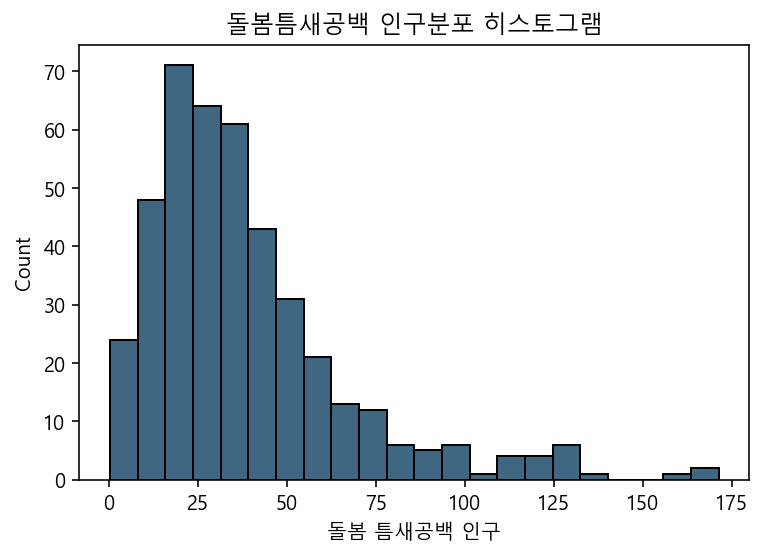

In [39]:
sns.histplot(final_df['돌봄 틈새공백 인구'], color='#003458').set_title("돌봄틈새공백 인구분포 히스토그램")


<AxesSubplot:>

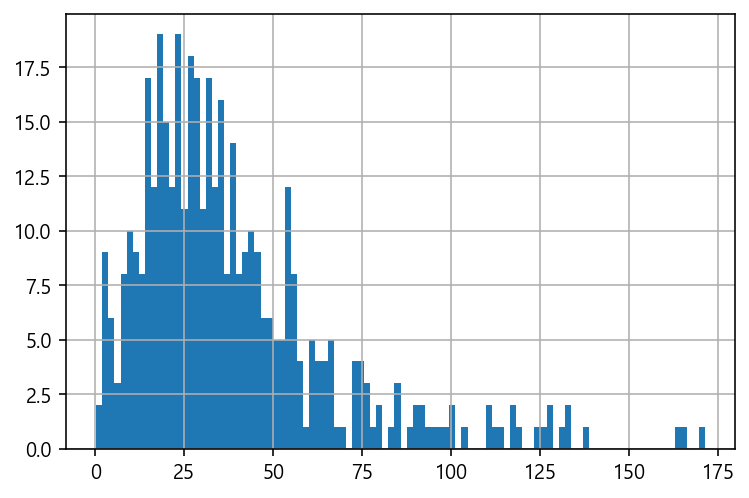

In [40]:
final_df['돌봄 틈새공백 인구'].hist(bins=100)

{'whiskers': [<matplotlib.lines.Line2D at 0x2168d227940>,
 'caps': [<matplotlib.lines.Line2D at 0x2168d233040>,
 'boxes': [<matplotlib.lines.Line2D at 0x2168d2275e0>],
 'medians': [<matplotlib.lines.Line2D at 0x2168d233700>],
 'fliers': [<matplotlib.lines.Line2D at 0x2168d233a60>],
 'means': []}

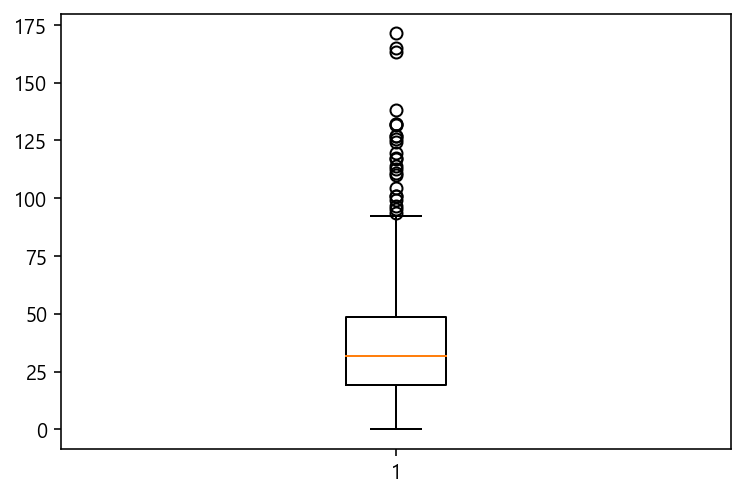

In [41]:
plt.boxplot(final_df['돌봄 틈새공백 인구'])

In [42]:
final_df.sort_values(by='돌봄 틈새공백 인구',ascending=False)

,행정동코드,시군구명,행정동명,0514세 인구,3040세 인구,총거주인구,3040대 결혼율,3040세 기혼인구,3040세 맞벌이 기혼인구,행정동별 3040세 맞벌이 기혼인구 비율,초등돌봄필요 인구,돌봄 틈새공백 인구,동별 돌봄 틈새공백 인구 비율
266,1171067000,송파구,잠실2동,6297,13331,36636,0.675025,8998.755850,4472.381658,0.122076,768.713487,171.287160,0.027201
82,1147055000,양천구,목5동,6591,13560,42628,0.710399,9633.008228,4787.605089,0.112311,740.243623,164.943415,0.025026
390,1138069000,은평구,진관동,7384,18196,57622,0.632888,11516.028168,5723.465999,0.099328,733.436412,163.426611,0.022133
356,1129066000,성북구,길음1동,5305,13021,36678,0.662632,8628.125645,4288.178446,0.116914,620.229747,138.201545,0.026051
191,1165065100,서초구,양재1동,5145,14942,45147,0.701256,10478.170428,5207.650703,0.115349,593.469397,132.238720,0.025702
...,...,...,...,...,...,...,...,...,...,...,...,...,...
44,1111067000,종로구,창신1동,174,1192,5164,0.588887,701.953750,348.871014,0.067558,11.755143,2.619318,0.015054
41,1111063000,종로구,종로5·6가동,146,1333,5340,0.588887,784.986870,390.138474,0.073060,10.666707,2.376789,0.016279
54,1114055000,중구,명동,124,841,2999,0.557223,468.624765,232.906508,0.077661,9.630012,2.145790,0.017305
56,1114060500,중구,을지로동,44,481,1830,0.557223,268.024390,133.208122,0.072791,3.202818,0.713662,0.016220


# pt 하기

In [43]:
pt_list = np.percentile(final_df[['돌봄 틈새공백 인구']],[i*10 for i in range(1,10)]).tolist()
pt_list

[11.4172952802803,
 17.35370808470268,
 22.040078103784627,
 26.70346994841722,
 31.883425983099386,
 36.70192438932302,
 44.37796214965267,
 54.1203850281179,
 73.92962845191465]

In [44]:
# 초등돌봄틈새 분위 라벨링
final_df['돌봄틈새공백 분위'] = 0
final_df.loc[final_df['돌봄 틈새공백 인구'] <= pt_list[0], '돌봄틈새공백 분위'] = 1
final_df.loc[(final_df['돌봄 틈새공백 인구'] > pt_list[0]) & (final_df['돌봄 틈새공백 인구'] <= pt_list[1]),'돌봄틈새공백 분위'] = 2
final_df.loc[(final_df['돌봄 틈새공백 인구'] > pt_list[1]) & (final_df['돌봄 틈새공백 인구'] <= pt_list[2]),'돌봄틈새공백 분위'] = 3
final_df.loc[(final_df['돌봄 틈새공백 인구'] > pt_list[2]) & (final_df['돌봄 틈새공백 인구'] <= pt_list[3]),'돌봄틈새공백 분위'] = 4
final_df.loc[(final_df['돌봄 틈새공백 인구'] > pt_list[3]) & (final_df['돌봄 틈새공백 인구'] <= pt_list[4]),'돌봄틈새공백 분위'] = 5
final_df.loc[(final_df['돌봄 틈새공백 인구'] > pt_list[4]) & (final_df['돌봄 틈새공백 인구'] <= pt_list[5]),'돌봄틈새공백 분위'] = 6
final_df.loc[(final_df['돌봄 틈새공백 인구'] > pt_list[5]) & (final_df['돌봄 틈새공백 인구'] <= pt_list[6]),'돌봄틈새공백 분위'] = 7
final_df.loc[(final_df['돌봄 틈새공백 인구'] > pt_list[6]) & (final_df['돌봄 틈새공백 인구'] <= pt_list[7]),'돌봄틈새공백 분위'] = 8
final_df.loc[(final_df['돌봄 틈새공백 인구'] > pt_list[7]) & (final_df['돌봄 틈새공백 인구'] <= pt_list[8]),'돌봄틈새공백 분위'] = 9
final_df.loc[(final_df['돌봄 틈새공백 인구'] > pt_list[8]),'돌봄틈새공백 분위'] = 10
final_df

,행정동코드,시군구명,행정동명,0514세 인구,3040세 인구,총거주인구,3040대 결혼율,3040세 기혼인구,3040세 맞벌이 기혼인구,행정동별 3040세 맞벌이 기혼인구 비율,초등돌봄필요 인구,돌봄 틈새공백 인구,동별 돌봄 틈새공백 인구 비율,돌봄틈새공백 분위
0,1117051000,용산구,후암동,1145,5627,17804,0.593661,3340.529908,1660.243364,0.093251,106.772560,23.791398,0.020779,4
1,1117057000,용산구,원효로2동,1109,4466,14336,0.593661,2651.289598,1317.690930,0.091915,101.933541,22.713153,0.020481,4
2,1117064000,용산구,이촌2동,493,2770,8820,0.593661,1644.440705,817.287030,0.092663,45.682824,10.179191,0.020647,1
3,1117066000,용산구,이태원2동,452,3103,9272,0.593661,1842.129786,915.538504,0.098742,44.631515,9.944935,0.022002,1
4,1117069000,용산구,서빙고동,1180,4071,13353,0.593661,2416.793541,1201.146390,0.089953,106.144892,23.651539,0.020044,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419,1120072000,성동구,송정동,556,3308,10945,0.628100,2077.756347,1032.644905,0.094349,52.457795,11.688811,0.021023,2
420,1120067000,성동구,성수2가1동,868,5104,17003,0.628100,3205.824787,1593.294919,0.093707,81.337410,18.123858,0.020880,3
421,1120053500,성동구,왕십리도선동,1980,8933,27276,0.628100,5610.821478,2788.578274,0.102236,202.426492,45.105308,0.022780,8
422,1120064500,성동구,옥수동,2138,9738,26909,0.628100,6116.442354,3039.871850,0.112969,241.526850,53.817773,0.025172,8


In [45]:
alone_need_df = final_df[['행정동코드','시군구명','행정동명','돌봄 틈새공백 인구','동별 돌봄 틈새공백 인구 비율','돌봄틈새공백 분위']]
alone_need_df

,행정동코드,시군구명,행정동명,돌봄 틈새공백 인구,동별 돌봄 틈새공백 인구 비율,돌봄틈새공백 분위
0,1117051000,용산구,후암동,23.791398,0.020779,4
1,1117057000,용산구,원효로2동,22.713153,0.020481,4
2,1117064000,용산구,이촌2동,10.179191,0.020647,1
3,1117066000,용산구,이태원2동,9.944935,0.022002,1
4,1117069000,용산구,서빙고동,23.651539,0.020044,4
...,...,...,...,...,...,...
419,1120072000,성동구,송정동,11.688811,0.021023,2
420,1120067000,성동구,성수2가1동,18.123858,0.020880,3
421,1120053500,성동구,왕십리도선동,45.105308,0.022780,8
422,1120064500,성동구,옥수동,53.817773,0.025172,8


In [46]:
alone_need_df.sort_values(by='돌봄 틈새공백 인구')

,행정동코드,시군구명,행정동명,돌봄 틈새공백 인구,동별 돌봄 틈새공백 인구 비율,돌봄틈새공백 분위
307,1174069000,강동구,둔촌1동,0.235791,0.021436,1
56,1114060500,중구,을지로동,0.713662,0.016220,1
54,1114055000,중구,명동,2.145790,0.017305,1
41,1111063000,종로구,종로5·6가동,2.376789,0.016279,1
44,1111067000,종로구,창신1동,2.619318,0.015054,1
...,...,...,...,...,...,...
191,1165065100,서초구,양재1동,132.238720,0.025702,10
356,1129066000,성북구,길음1동,138.201545,0.026051,10
390,1138069000,은평구,진관동,163.426611,0.022133,10
82,1147055000,양천구,목5동,164.943415,0.025026,10


In [47]:
alone_need_df.to_pickle('역수취한 최종 돌봄 틈새공백 인구.pkl')
alone_need_df.to_csv('역수취한 최종 돌봄 틈새공백 인구.csv')

In [48]:
alone_need_df

,행정동코드,시군구명,행정동명,돌봄 틈새공백 인구,동별 돌봄 틈새공백 인구 비율,돌봄틈새공백 분위
0,1117051000,용산구,후암동,23.791398,0.020779,4
1,1117057000,용산구,원효로2동,22.713153,0.020481,4
2,1117064000,용산구,이촌2동,10.179191,0.020647,1
3,1117066000,용산구,이태원2동,9.944935,0.022002,1
4,1117069000,용산구,서빙고동,23.651539,0.020044,4
...,...,...,...,...,...,...
419,1120072000,성동구,송정동,11.688811,0.021023,2
420,1120067000,성동구,성수2가1동,18.123858,0.020880,3
421,1120053500,성동구,왕십리도선동,45.105308,0.022780,8
422,1120064500,성동구,옥수동,53.817773,0.025172,8


In [49]:
temp_df = alone_need_df[['행정동명','시군구명','돌봄 틈새공백 인구', '돌봄틈새공백 분위','동별 돌봄 틈새공백 인구 비율']]
temp_df

,행정동명,시군구명,돌봄 틈새공백 인구,돌봄틈새공백 분위,동별 돌봄 틈새공백 인구 비율
0,후암동,용산구,23.791398,4,0.020779
1,원효로2동,용산구,22.713153,4,0.020481
2,이촌2동,용산구,10.179191,1,0.020647
3,이태원2동,용산구,9.944935,1,0.022002
4,서빙고동,용산구,23.651539,4,0.020044
...,...,...,...,...,...
419,송정동,성동구,11.688811,2,0.021023
420,성수2가1동,성동구,18.123858,3,0.020880
421,왕십리도선동,성동구,45.105308,8,0.022780
422,옥수동,성동구,53.817773,8,0.025172


# 시군구별, 동별 시각화

# 그냥 인구

In [50]:
# 전체 구별 현황 그래프
def plot_region_mean(df, x_axis, rc, rot_x=True, show_xlabel=True):
    plt.figure(figsize=(18, 6)) 

    pal = sns.color_palette("Blues_r", df.shape[0])
    rank = df['돌봄 틈새공백 인구'].argsort().argsort()
    sns.barplot(x=x_axis, y='돌봄 틈새공백 인구', data=df, palette=np.array(pal[::-1])[rank])
    for idx, score in enumerate(df['돌봄 틈새공백 인구']):
        plt.text(idx-0.4, score+0.3, score, size=10, weight='bold')
    plt.title(f'서울시 자치구별 돌봄 틈새공백 평균 인구', size=25)
    plt.legend(fontsize=15)
    plt.ylabel(f'돌봄 틈새공백 인구', size=15)
    if rot_x:
        plt.xticks(rotation=25,size=15, ha='right')
    if show_xlabel:
        plt.xlabel(x_axis, size=15)
    else:
        plt.xlabel(None)

    plt.show()

No handles with labels found to put in legend.


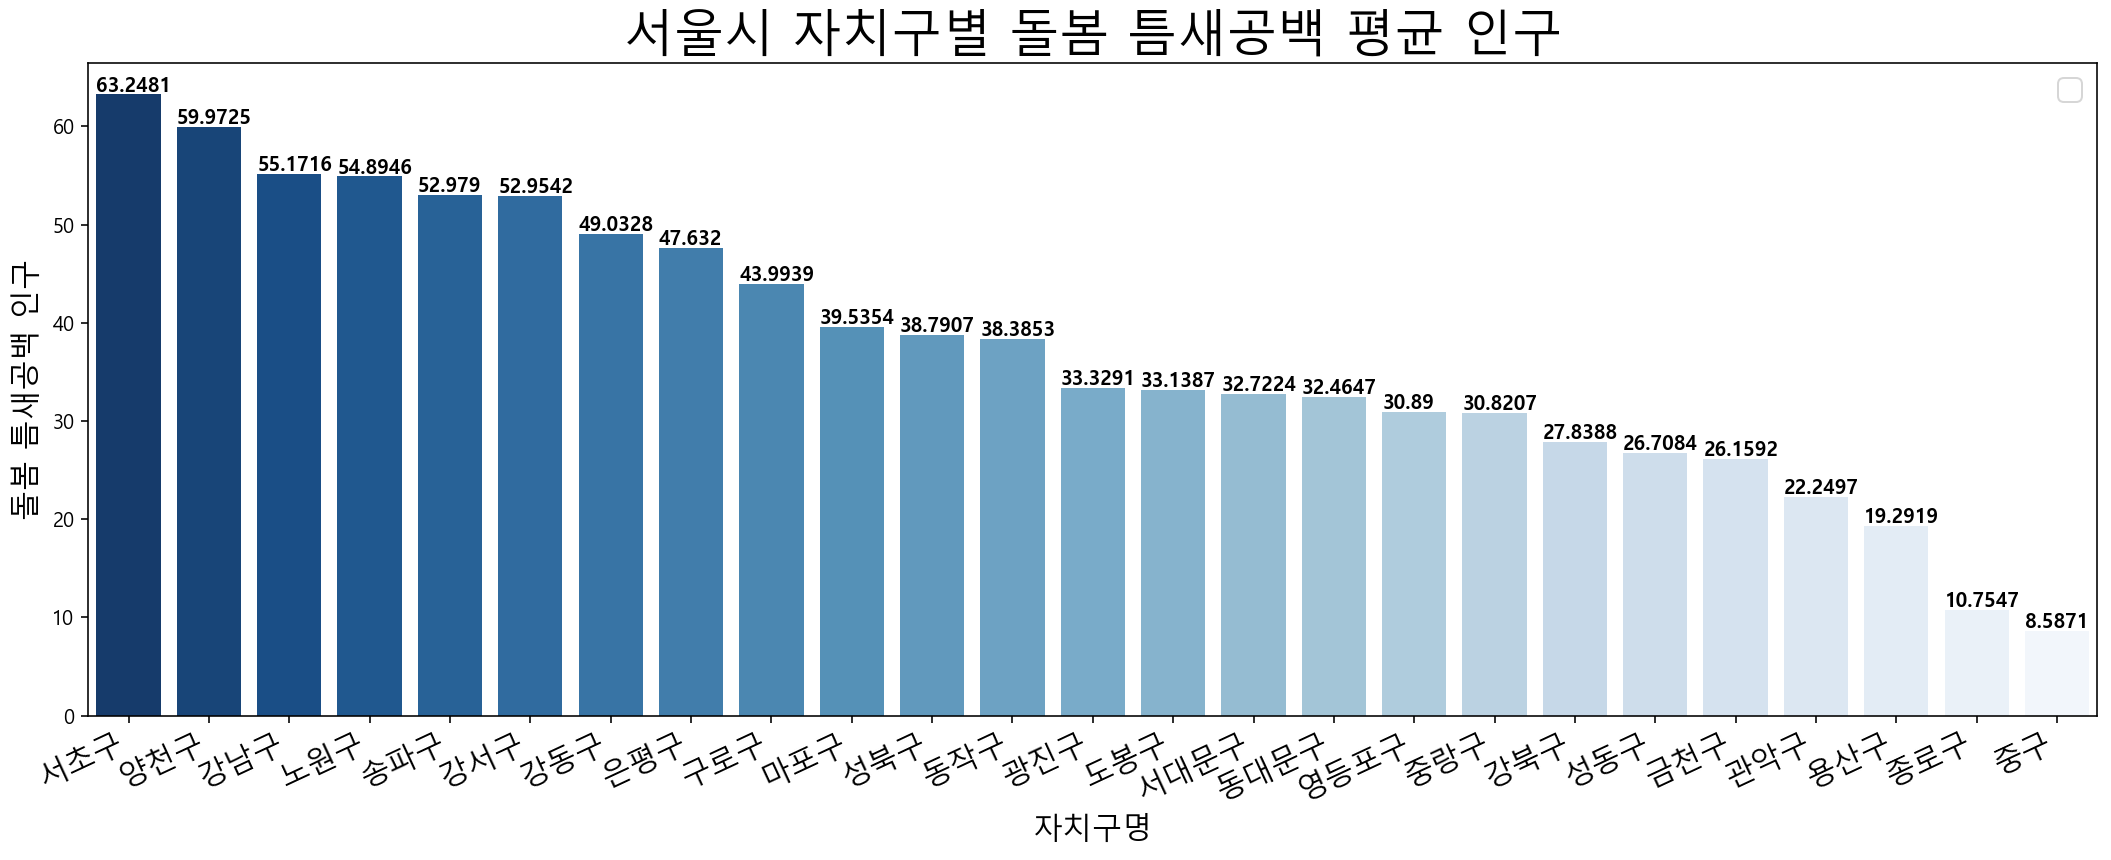

In [51]:
# 평균
tmp_list = []

for gu in temp_df['시군구명'].unique():
    tmp_df = temp_df[temp_df['시군구명']==gu]
    tmp_list.append(round(tmp_df['돌봄 틈새공백 인구'].mean(),4))

dmd_gu = pd.DataFrame({'자치구명':temp_df['시군구명'].unique(), '돌봄 틈새공백 인구':tmp_list})\
                        .sort_values('돌봄 틈새공백 인구', ascending=False).reset_index(drop=True)
                        
plot_region_mean(dmd_gu,'자치구명','돌봄 틈새공백 인구')

In [52]:
# # 전체 구별 현황 그래프
# def plot_region_mean(df, x_axis, rc, rot_x=True, show_xlabel=True):
#     plt.figure(figsize=(18, 6)) 

#     pal = sns.color_palette("Oranges_r", df.shape[0])
#     rank = df['동별 돌봄 틈새공백 인구 비율'].argsort().argsort()
#     sns.barplot(x=x_axis, y='동별 돌봄 틈새공백 인구 비율', data=df, palette=np.array(pal[::-1])[rank])
#     for idx, score in enumerate(df['동별 돌봄 틈새공백 인구 비율']):
#         plt.text(idx-0.4, score+0.3, score, size=10, weight='bold')
#     plt.title(f'서울시 자치구별 돌봄시설 동별 돌봄 틈새공백 인구 비율 평균', size=25)
#     plt.legend(fontsize=15)
#     plt.ylabel(f'동별 돌봄 틈새공백 인구 비율', size=15)
#     if rot_x:
#         plt.xticks(rotation=45, size=15, ha='right')
#     if show_xlabel:
#         plt.xlabel(x_axis, size=15)
#     else:
#         plt.xlabel(None)

#     plt.show()

In [53]:
# # 평균
# tmp_list = []

# for gu in temp_df['시군구명'].unique():
#     tmp_df = temp_df[temp_df['시군구명']==gu]
#     tmp_list.append(round(tmp_df['동별 돌봄 틈새공백 인구 비율'].mean(),4))

# dmd_gu = pd.DataFrame({'자치구명':temp_df['시군구명'].unique(), '동별 돌봄 틈새공백 인구 비율':tmp_list})\
#                         .sort_values('동별 돌봄 틈새공백 인구 비율', ascending=False).reset_index(drop=True)
                        
# plot_region_mean(dmd_gu,'자치구명','동별 돌봄 틈새공백 인구 비율')

# 행정동별 시각화

In [54]:
def plot_dong_region(df, gu, x_axis, rot_x=True, show_xlabel=True):

    pop_tmp = temp_df#df[(df['시군구명'] == f'{gu}')].reset_index(drop=True)
    tmp_list = []
    for dong in pop_tmp['행정동명'].unique():
        tmp_df = pop_tmp[pop_tmp['행정동명']==dong]
        tmp_list.append(round(tmp_df['돌봄 틈새공백 인구'].values[0],4))

    pop_dong = pd.DataFrame({'행정동':pop_tmp['행정동명'].unique(), '돌봄 틈새공백 인구':tmp_list})\
                        .sort_values('돌봄 틈새공백 인구', ascending=False).reset_index(drop=True)
    avg = pop_dong['돌봄 틈새공백 인구'].mean()
    pop_dong = pop_dong.iloc[:20]
    plt.figure(figsize=(18, 6))

    pal = sns.color_palette("Blues", pop_dong.shape[0])
    rank = pop_dong['돌봄 틈새공백 인구'].argsort().argsort()
    sns.barplot(x=x_axis, y='돌봄 틈새공백 인구', data=pop_dong, palette=np.array(pal[::1])[rank])
    # plt.axhline(q1, color='red', alpha=0.5, label=f'서울시 {gu} 동별 돌봄시설 돌봄 틈새공백  인구')
    
    plt.axhline(avg, color='red', alpha=0.5, label='서울시 행정동별 돌봄틈새공백 인구 평균')
    
    
    for idx, score in enumerate(pop_dong['돌봄 틈새공백 인구']):
        plt.text(idx-0.35, score+0.55, score, size=10, weight='bold')
    plt.title(f'서울시 {gu} {x_axis}별 돌봄 틈새공백 인구', size=25)
    plt.legend(fontsize=15)
    # plt.yticks([])
    plt.ylabel(f'돌봄 틈새공백 인구', size=15)
    if rot_x:
        plt.xticks(rotation=25, size=15, ha='right')
    if show_xlabel:
        plt.xlabel(x_axis, size=15)
    else:
        plt.xlabel(None)

    plt.show()

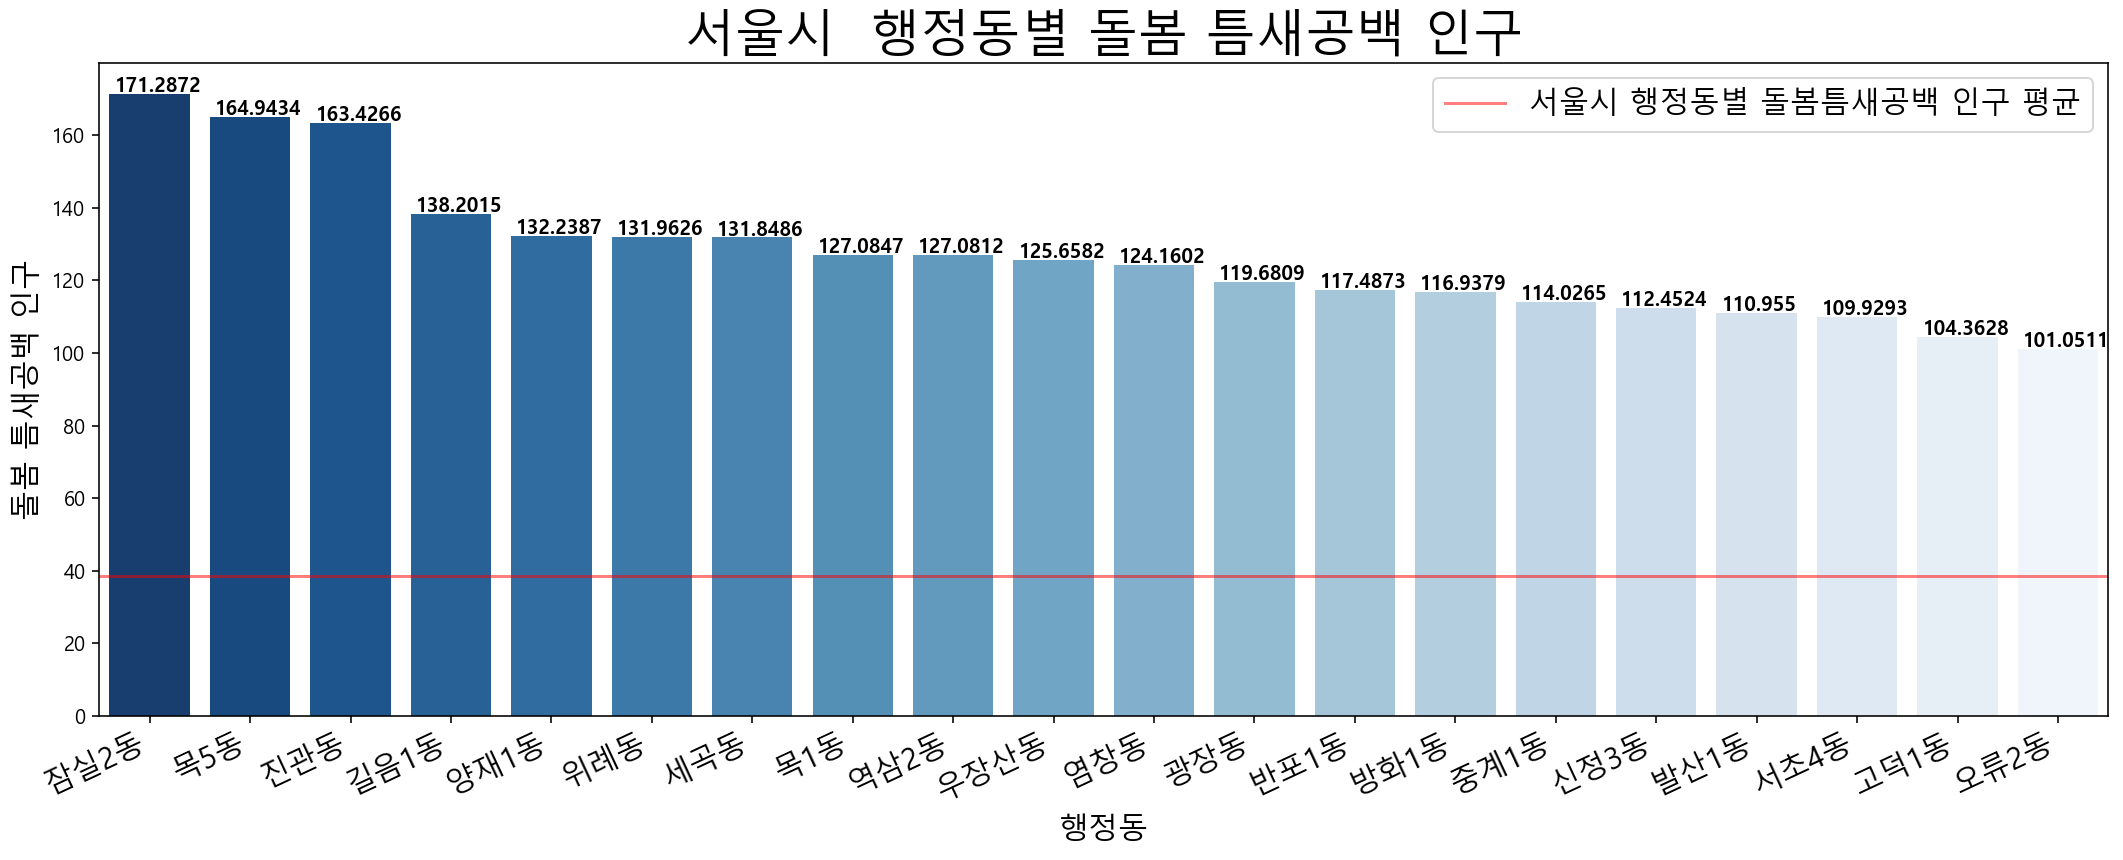

In [55]:
plot_dong_region(temp_df,'','행정동')
# plot_dong_region(temp_df,'강서구','행정동')
# # plot_dong_region(temp_df,'노원구','행정동')
# plot_dong_region(temp_df,'광진구','행정동')
# plot_dong_region(temp_df,'강남구','행정동')

# 소연이 줄 좌표(3개 구)의 지수 구하기

In [56]:
target = pklopen('동3개_초등학교881m_인구.pickle')
target

C:\anaconda3\lib\site-packages\pyproj\crs\crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


,gid,행정동코드,시군구명,행정동,학교명,학교개수,초등학생_인구,30대_인구,40대_인구,전체_인구,경도,위도,geometry
0,다사41ab48ba,1150054000,강서구,화곡제1동,"[서울신원초등학교, 서울월정초등학교, 서울신월초등학교]",3,125.0,310.0,359.0,2085.0,126.836440,37.535080,POINT (126.83644 37.53508)
1,다사41ab48bb,1150054000,강서구,화곡제1동,"[서울강신초등학교, 서울월정초등학교, 서울신월초등학교]",3,64.0,353.0,360.0,2006.0,126.836420,37.537333,POINT (126.83642 37.53733)
2,다사41ab49aa,1150054000,강서구,화곡제1동,"[서울강신초등학교, 서울월정초등학교, 서울신월초등학교]",3,104.0,430.0,403.0,2288.0,126.836400,37.539586,POINT (126.83640 37.53959)
3,다사41ba48aa,1150054000,강서구,화곡제1동,"[서울신원초등학교, 서울신강초등학교, 서울월정초등학교]",3,68.0,559.0,397.0,2535.0,126.839309,37.530589,POINT (126.83931 37.53059)
4,다사41ba48ab,1150054000,강서구,화곡제1동,"[서울신강초등학교, 서울월정초등학교, 서울신월초등학교]",3,64.0,493.0,350.0,2542.0,126.839289,37.532842,POINT (126.83929 37.53284)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,다사65ab50ab,1121581000,광진구,광장동,"[서울광장초등학교, 서울동의초등학교]",2,14.0,43.0,43.0,433.0,127.107999,37.552067,POINT (127.10800 37.55207)
79,다사65ab50ba,1121581000,광진구,광장동,"[서울광장초등학교, 서울동의초등학교]",2,0.0,0.0,0.0,0.0,127.107987,37.554320,POINT (127.10799 37.55432)
80,다사65ab50bb,1121581000,광진구,광장동,[서울동의초등학교],1,0.0,0.0,0.0,0.0,127.107975,37.556574,POINT (127.10798 37.55657)
81,다사65ba49bb,1121581000,광진구,광장동,[서울광장초등학교],1,0.0,0.0,6.0,32.0,127.110853,37.547570,POINT (127.11085 37.54757)


# 3구 각각 만들어줘야 하니 세번 돌리자

### 강서구

In [57]:
target = target[target.시군구명=='강서구']
target

,gid,행정동코드,시군구명,행정동,학교명,학교개수,초등학생_인구,30대_인구,40대_인구,전체_인구,경도,위도,geometry
0,다사41ab48ba,1150054000,강서구,화곡제1동,"[서울신원초등학교, 서울월정초등학교, 서울신월초등학교]",3,125.0,310.0,359.0,2085.0,126.836440,37.535080,POINT (126.83644 37.53508)
1,다사41ab48bb,1150054000,강서구,화곡제1동,"[서울강신초등학교, 서울월정초등학교, 서울신월초등학교]",3,64.0,353.0,360.0,2006.0,126.836420,37.537333,POINT (126.83642 37.53733)
2,다사41ab49aa,1150054000,강서구,화곡제1동,"[서울강신초등학교, 서울월정초등학교, 서울신월초등학교]",3,104.0,430.0,403.0,2288.0,126.836400,37.539586,POINT (126.83640 37.53959)
3,다사41ba48aa,1150054000,강서구,화곡제1동,"[서울신원초등학교, 서울신강초등학교, 서울월정초등학교]",3,68.0,559.0,397.0,2535.0,126.839309,37.530589,POINT (126.83931 37.53059)
4,다사41ba48ab,1150054000,강서구,화곡제1동,"[서울신강초등학교, 서울월정초등학교, 서울신월초등학교]",3,64.0,493.0,350.0,2542.0,126.839289,37.532842,POINT (126.83929 37.53284)
5,다사41ba48ba,1150054000,강서구,화곡제1동,"[서울월정초등학교, 서울신월초등학교]",2,143.0,479.0,482.0,2890.0,126.839270,37.535096,POINT (126.83927 37.53510)
6,다사41ba48bb,1150054000,강서구,화곡제1동,"[서울화일초등학교, 서울월정초등학교, 서울신월초등학교]",3,85.0,523.0,396.0,2628.0,126.839250,37.537349,POINT (126.83925 37.53735)
7,다사41ba49aa,1150054000,강서구,화곡제1동,"[서울화일초등학교, 서울화곡초등학교, 서울월정초등학교, 서울신월초등학교]",4,92.0,517.0,419.0,2553.0,126.839230,37.539602,POINT (126.83923 37.53960)
8,다사41bb47bb,1150054000,강서구,화곡제1동,"[서울강서초등학교, 서울신강초등학교, 서울양강초등학교, 서울양동초등학교]",4,63.0,983.0,584.0,3839.0,126.842158,37.528352,POINT (126.84216 37.52835)
9,다사41bb48aa,1150054000,강서구,화곡제1동,"[서울신강초등학교, 서울월정초등학교]",2,85.0,1209.0,758.0,4878.0,126.842139,37.530605,POINT (126.84214 37.53060)


In [58]:
married_rate_gu_df

,시군구명,3040대 결혼율
0,합계,0.634570
1,종로구,0.588887
2,중구,0.557223
3,용산구,0.593661
4,성동구,0.628100
5,광진구,0.593863
6,동대문구,0.604736
7,중랑구,0.598189
8,성북구,0.662632
9,강북구,0.575451


In [59]:
# married_rate_gu_df[married_rate_gu_df['시군구명']=='은평구']['3040대 결혼율'].iloc[0]

In [60]:
target['3040대 인구'] = target['30대_인구']+target['40대_인구']
target_need = pd.merge(target, married_rate_gu_df, on='시군구명')
target_need

<ipython-input-60-b5b835a03157>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target['3040대 인구'] = target['30대_인구']+target['40대_인구']


,gid,행정동코드,시군구명,행정동,학교명,학교개수,초등학생_인구,30대_인구,40대_인구,전체_인구,경도,위도,geometry,3040대 인구,3040대 결혼율
0,다사41ab48ba,1150054000,강서구,화곡제1동,"[서울신원초등학교, 서울월정초등학교, 서울신월초등학교]",3,125.0,310.0,359.0,2085.0,126.836440,37.535080,POINT (126.83644 37.53508),669.0,0.6546
1,다사41ab48bb,1150054000,강서구,화곡제1동,"[서울강신초등학교, 서울월정초등학교, 서울신월초등학교]",3,64.0,353.0,360.0,2006.0,126.836420,37.537333,POINT (126.83642 37.53733),713.0,0.6546
2,다사41ab49aa,1150054000,강서구,화곡제1동,"[서울강신초등학교, 서울월정초등학교, 서울신월초등학교]",3,104.0,430.0,403.0,2288.0,126.836400,37.539586,POINT (126.83640 37.53959),833.0,0.6546
3,다사41ba48aa,1150054000,강서구,화곡제1동,"[서울신원초등학교, 서울신강초등학교, 서울월정초등학교]",3,68.0,559.0,397.0,2535.0,126.839309,37.530589,POINT (126.83931 37.53059),956.0,0.6546
4,다사41ba48ab,1150054000,강서구,화곡제1동,"[서울신강초등학교, 서울월정초등학교, 서울신월초등학교]",3,64.0,493.0,350.0,2542.0,126.839289,37.532842,POINT (126.83929 37.53284),843.0,0.6546
5,다사41ba48ba,1150054000,강서구,화곡제1동,"[서울월정초등학교, 서울신월초등학교]",2,143.0,479.0,482.0,2890.0,126.839270,37.535096,POINT (126.83927 37.53510),961.0,0.6546
6,다사41ba48bb,1150054000,강서구,화곡제1동,"[서울화일초등학교, 서울월정초등학교, 서울신월초등학교]",3,85.0,523.0,396.0,2628.0,126.839250,37.537349,POINT (126.83925 37.53735),919.0,0.6546
7,다사41ba49aa,1150054000,강서구,화곡제1동,"[서울화일초등학교, 서울화곡초등학교, 서울월정초등학교, 서울신월초등학교]",4,92.0,517.0,419.0,2553.0,126.839230,37.539602,POINT (126.83923 37.53960),936.0,0.6546
8,다사41bb47bb,1150054000,강서구,화곡제1동,"[서울강서초등학교, 서울신강초등학교, 서울양강초등학교, 서울양동초등학교]",4,63.0,983.0,584.0,3839.0,126.842158,37.528352,POINT (126.84216 37.52835),1567.0,0.6546
9,다사41bb48aa,1150054000,강서구,화곡제1동,"[서울신강초등학교, 서울월정초등학교]",2,85.0,1209.0,758.0,4878.0,126.842139,37.530605,POINT (126.84214 37.53060),1967.0,0.6546


In [61]:
target_need['3040대 기혼인구'] = target_need['3040대 인구'] * target_need['3040대 결혼율']
target_need

,gid,행정동코드,시군구명,행정동,학교명,학교개수,초등학생_인구,30대_인구,40대_인구,전체_인구,경도,위도,geometry,3040대 인구,3040대 결혼율,3040대 기혼인구
0,다사41ab48ba,1150054000,강서구,화곡제1동,"[서울신원초등학교, 서울월정초등학교, 서울신월초등학교]",3,125.0,310.0,359.0,2085.0,126.836440,37.535080,POINT (126.83644 37.53508),669.0,0.6546,437.927298
1,다사41ab48bb,1150054000,강서구,화곡제1동,"[서울강신초등학교, 서울월정초등학교, 서울신월초등학교]",3,64.0,353.0,360.0,2006.0,126.836420,37.537333,POINT (126.83642 37.53733),713.0,0.6546,466.729691
2,다사41ab49aa,1150054000,강서구,화곡제1동,"[서울강신초등학교, 서울월정초등학교, 서울신월초등학교]",3,104.0,430.0,403.0,2288.0,126.836400,37.539586,POINT (126.83640 37.53959),833.0,0.6546,545.281673
3,다사41ba48aa,1150054000,강서구,화곡제1동,"[서울신원초등학교, 서울신강초등학교, 서울월정초등학교]",3,68.0,559.0,397.0,2535.0,126.839309,37.530589,POINT (126.83931 37.53059),956.0,0.6546,625.797454
4,다사41ba48ab,1150054000,강서구,화곡제1동,"[서울신강초등학교, 서울월정초등학교, 서울신월초등학교]",3,64.0,493.0,350.0,2542.0,126.839289,37.532842,POINT (126.83929 37.53284),843.0,0.6546,551.827671
5,다사41ba48ba,1150054000,강서구,화곡제1동,"[서울월정초등학교, 서울신월초등학교]",2,143.0,479.0,482.0,2890.0,126.839270,37.535096,POINT (126.83927 37.53510),961.0,0.6546,629.070453
6,다사41ba48bb,1150054000,강서구,화곡제1동,"[서울화일초등학교, 서울월정초등학교, 서울신월초등학교]",3,85.0,523.0,396.0,2628.0,126.839250,37.537349,POINT (126.83925 37.53735),919.0,0.6546,601.577260
7,다사41ba49aa,1150054000,강서구,화곡제1동,"[서울화일초등학교, 서울화곡초등학교, 서울월정초등학교, 서울신월초등학교]",4,92.0,517.0,419.0,2553.0,126.839230,37.539602,POINT (126.83923 37.53960),936.0,0.6546,612.705457
8,다사41bb47bb,1150054000,강서구,화곡제1동,"[서울강서초등학교, 서울신강초등학교, 서울양강초등학교, 서울양동초등학교]",4,63.0,983.0,584.0,3839.0,126.842158,37.528352,POINT (126.84216 37.52835),1567.0,0.6546,1025.757961
9,다사41bb48aa,1150054000,강서구,화곡제1동,"[서울신강초등학교, 서울월정초등학교]",2,85.0,1209.0,758.0,4878.0,126.842139,37.530605,POINT (126.84214 37.53060),1967.0,0.6546,1287.597900


In [62]:
#맞벌이 비율 곱하기
both_30s = both_rate_df.iloc[2,3]
both_40s = both_rate_df.iloc[3,3]
both_3040s = (both_30s + both_40s)/2
both_3040s


0.497

In [63]:
target_need['3040대 맞벌이 기혼인구'] = (target_need['3040대 기혼인구']*both_3040s)
target_need

,gid,행정동코드,시군구명,행정동,학교명,학교개수,초등학생_인구,30대_인구,40대_인구,전체_인구,경도,위도,geometry,3040대 인구,3040대 결혼율,3040대 기혼인구,3040대 맞벌이 기혼인구
0,다사41ab48ba,1150054000,강서구,화곡제1동,"[서울신원초등학교, 서울월정초등학교, 서울신월초등학교]",3,125.0,310.0,359.0,2085.0,126.836440,37.535080,POINT (126.83644 37.53508),669.0,0.6546,437.927298,217.649867
1,다사41ab48bb,1150054000,강서구,화곡제1동,"[서울강신초등학교, 서울월정초등학교, 서울신월초등학교]",3,64.0,353.0,360.0,2006.0,126.836420,37.537333,POINT (126.83642 37.53733),713.0,0.6546,466.729691,231.964656
2,다사41ab49aa,1150054000,강서구,화곡제1동,"[서울강신초등학교, 서울월정초등학교, 서울신월초등학교]",3,104.0,430.0,403.0,2288.0,126.836400,37.539586,POINT (126.83640 37.53959),833.0,0.6546,545.281673,271.004991
3,다사41ba48aa,1150054000,강서구,화곡제1동,"[서울신원초등학교, 서울신강초등학교, 서울월정초등학교]",3,68.0,559.0,397.0,2535.0,126.839309,37.530589,POINT (126.83931 37.53059),956.0,0.6546,625.797454,311.021335
4,다사41ba48ab,1150054000,강서구,화곡제1동,"[서울신강초등학교, 서울월정초등학교, 서울신월초등학교]",3,64.0,493.0,350.0,2542.0,126.839289,37.532842,POINT (126.83929 37.53284),843.0,0.6546,551.827671,274.258353
5,다사41ba48ba,1150054000,강서구,화곡제1동,"[서울월정초등학교, 서울신월초등학교]",2,143.0,479.0,482.0,2890.0,126.839270,37.535096,POINT (126.83927 37.53510),961.0,0.6546,629.070453,312.648015
6,다사41ba48bb,1150054000,강서구,화곡제1동,"[서울화일초등학교, 서울월정초등학교, 서울신월초등학교]",3,85.0,523.0,396.0,2628.0,126.839250,37.537349,POINT (126.83925 37.53735),919.0,0.6546,601.577260,298.983898
7,다사41ba49aa,1150054000,강서구,화곡제1동,"[서울화일초등학교, 서울화곡초등학교, 서울월정초등학교, 서울신월초등학교]",4,92.0,517.0,419.0,2553.0,126.839230,37.539602,POINT (126.83923 37.53960),936.0,0.6546,612.705457,304.514612
8,다사41bb47bb,1150054000,강서구,화곡제1동,"[서울강서초등학교, 서울신강초등학교, 서울양강초등학교, 서울양동초등학교]",4,63.0,983.0,584.0,3839.0,126.842158,37.528352,POINT (126.84216 37.52835),1567.0,0.6546,1025.757961,509.801706
9,다사41bb48aa,1150054000,강서구,화곡제1동,"[서울신강초등학교, 서울월정초등학교]",2,85.0,1209.0,758.0,4878.0,126.842139,37.530605,POINT (126.84214 37.53060),1967.0,0.6546,1287.597900,639.936156


In [64]:
target_need['지역별 3040대 맞벌이 기혼인구 비율'] = target_need['3040대 맞벌이 기혼인구']/target_need['전체_인구']
target_need = target_need.fillna(0)
target_need

,gid,행정동코드,시군구명,행정동,학교명,학교개수,초등학생_인구,30대_인구,40대_인구,전체_인구,경도,위도,geometry,3040대 인구,3040대 결혼율,3040대 기혼인구,3040대 맞벌이 기혼인구,지역별 3040대 맞벌이 기혼인구 비율
0,다사41ab48ba,1150054000,강서구,화곡제1동,"[서울신원초등학교, 서울월정초등학교, 서울신월초등학교]",3,125.0,310.0,359.0,2085.0,126.836440,37.535080,POINT (126.83644 37.53508),669.0,0.6546,437.927298,217.649867,0.104388
1,다사41ab48bb,1150054000,강서구,화곡제1동,"[서울강신초등학교, 서울월정초등학교, 서울신월초등학교]",3,64.0,353.0,360.0,2006.0,126.836420,37.537333,POINT (126.83642 37.53733),713.0,0.6546,466.729691,231.964656,0.115635
2,다사41ab49aa,1150054000,강서구,화곡제1동,"[서울강신초등학교, 서울월정초등학교, 서울신월초등학교]",3,104.0,430.0,403.0,2288.0,126.836400,37.539586,POINT (126.83640 37.53959),833.0,0.6546,545.281673,271.004991,0.118446
3,다사41ba48aa,1150054000,강서구,화곡제1동,"[서울신원초등학교, 서울신강초등학교, 서울월정초등학교]",3,68.0,559.0,397.0,2535.0,126.839309,37.530589,POINT (126.83931 37.53059),956.0,0.6546,625.797454,311.021335,0.122691
4,다사41ba48ab,1150054000,강서구,화곡제1동,"[서울신강초등학교, 서울월정초등학교, 서울신월초등학교]",3,64.0,493.0,350.0,2542.0,126.839289,37.532842,POINT (126.83929 37.53284),843.0,0.6546,551.827671,274.258353,0.107891
5,다사41ba48ba,1150054000,강서구,화곡제1동,"[서울월정초등학교, 서울신월초등학교]",2,143.0,479.0,482.0,2890.0,126.839270,37.535096,POINT (126.83927 37.53510),961.0,0.6546,629.070453,312.648015,0.108183
6,다사41ba48bb,1150054000,강서구,화곡제1동,"[서울화일초등학교, 서울월정초등학교, 서울신월초등학교]",3,85.0,523.0,396.0,2628.0,126.839250,37.537349,POINT (126.83925 37.53735),919.0,0.6546,601.577260,298.983898,0.113769
7,다사41ba49aa,1150054000,강서구,화곡제1동,"[서울화일초등학교, 서울화곡초등학교, 서울월정초등학교, 서울신월초등학교]",4,92.0,517.0,419.0,2553.0,126.839230,37.539602,POINT (126.83923 37.53960),936.0,0.6546,612.705457,304.514612,0.119277
8,다사41bb47bb,1150054000,강서구,화곡제1동,"[서울강서초등학교, 서울신강초등학교, 서울양강초등학교, 서울양동초등학교]",4,63.0,983.0,584.0,3839.0,126.842158,37.528352,POINT (126.84216 37.52835),1567.0,0.6546,1025.757961,509.801706,0.132795
9,다사41bb48aa,1150054000,강서구,화곡제1동,"[서울신강초등학교, 서울월정초등학교]",2,85.0,1209.0,758.0,4878.0,126.842139,37.530605,POINT (126.84214 37.53060),1967.0,0.6546,1287.597900,639.936156,0.131188


In [65]:
target_need['초등돌봄필요 인구'] = target_need['초등학생_인구']*target_need['지역별 3040대 맞벌이 기혼인구 비율']
target_need = target_need.fillna(0)
target_need

,gid,행정동코드,시군구명,행정동,학교명,학교개수,초등학생_인구,30대_인구,40대_인구,전체_인구,경도,위도,geometry,3040대 인구,3040대 결혼율,3040대 기혼인구,3040대 맞벌이 기혼인구,지역별 3040대 맞벌이 기혼인구 비율,초등돌봄필요 인구
0,다사41ab48ba,1150054000,강서구,화곡제1동,"[서울신원초등학교, 서울월정초등학교, 서울신월초등학교]",3,125.0,310.0,359.0,2085.0,126.836440,37.535080,POINT (126.83644 37.53508),669.0,0.6546,437.927298,217.649867,0.104388,13.048553
1,다사41ab48bb,1150054000,강서구,화곡제1동,"[서울강신초등학교, 서울월정초등학교, 서울신월초등학교]",3,64.0,353.0,360.0,2006.0,126.836420,37.537333,POINT (126.83642 37.53733),713.0,0.6546,466.729691,231.964656,0.115635,7.400667
2,다사41ab49aa,1150054000,강서구,화곡제1동,"[서울강신초등학교, 서울월정초등학교, 서울신월초등학교]",3,104.0,430.0,403.0,2288.0,126.836400,37.539586,POINT (126.83640 37.53959),833.0,0.6546,545.281673,271.004991,0.118446,12.318409
3,다사41ba48aa,1150054000,강서구,화곡제1동,"[서울신원초등학교, 서울신강초등학교, 서울월정초등학교]",3,68.0,559.0,397.0,2535.0,126.839309,37.530589,POINT (126.83931 37.53059),956.0,0.6546,625.797454,311.021335,0.122691,8.342979
4,다사41ba48ab,1150054000,강서구,화곡제1동,"[서울신강초등학교, 서울월정초등학교, 서울신월초등학교]",3,64.0,493.0,350.0,2542.0,126.839289,37.532842,POINT (126.83929 37.53284),843.0,0.6546,551.827671,274.258353,0.107891,6.905010
5,다사41ba48ba,1150054000,강서구,화곡제1동,"[서울월정초등학교, 서울신월초등학교]",2,143.0,479.0,482.0,2890.0,126.839270,37.535096,POINT (126.83927 37.53510),961.0,0.6546,629.070453,312.648015,0.108183,15.470127
6,다사41ba48bb,1150054000,강서구,화곡제1동,"[서울화일초등학교, 서울월정초등학교, 서울신월초등학교]",3,85.0,523.0,396.0,2628.0,126.839250,37.537349,POINT (126.83925 37.53735),919.0,0.6546,601.577260,298.983898,0.113769,9.670332
7,다사41ba49aa,1150054000,강서구,화곡제1동,"[서울화일초등학교, 서울화곡초등학교, 서울월정초등학교, 서울신월초등학교]",4,92.0,517.0,419.0,2553.0,126.839230,37.539602,POINT (126.83923 37.53960),936.0,0.6546,612.705457,304.514612,0.119277,10.973500
8,다사41bb47bb,1150054000,강서구,화곡제1동,"[서울강서초등학교, 서울신강초등학교, 서울양강초등학교, 서울양동초등학교]",4,63.0,983.0,584.0,3839.0,126.842158,37.528352,POINT (126.84216 37.52835),1567.0,0.6546,1025.757961,509.801706,0.132795,8.366113
9,다사41bb48aa,1150054000,강서구,화곡제1동,"[서울신강초등학교, 서울월정초등학교]",2,85.0,1209.0,758.0,4878.0,126.842139,37.530605,POINT (126.84214 37.53060),1967.0,0.6546,1287.597900,639.936156,0.131188,11.150999


In [66]:
target_need['돌봄 틈새공백 인구'] = target_need['초등돌봄필요 인구'] * AR
target_need = target_need.fillna(0)
target_need

,gid,행정동코드,시군구명,행정동,학교명,학교개수,초등학생_인구,30대_인구,40대_인구,전체_인구,경도,위도,geometry,3040대 인구,3040대 결혼율,3040대 기혼인구,3040대 맞벌이 기혼인구,지역별 3040대 맞벌이 기혼인구 비율,초등돌봄필요 인구,돌봄 틈새공백 인구
0,다사41ab48ba,1150054000,강서구,화곡제1동,"[서울신원초등학교, 서울월정초등학교, 서울신월초등학교]",3,125.0,310.0,359.0,2085.0,126.836440,37.535080,POINT (126.83644 37.53508),669.0,0.6546,437.927298,217.649867,0.104388,13.048553,2.907520
1,다사41ab48bb,1150054000,강서구,화곡제1동,"[서울강신초등학교, 서울월정초등학교, 서울신월초등학교]",3,64.0,353.0,360.0,2006.0,126.836420,37.537333,POINT (126.83642 37.53733),713.0,0.6546,466.729691,231.964656,0.115635,7.400667,1.649040
2,다사41ab49aa,1150054000,강서구,화곡제1동,"[서울강신초등학교, 서울월정초등학교, 서울신월초등학교]",3,104.0,430.0,403.0,2288.0,126.836400,37.539586,POINT (126.83640 37.53959),833.0,0.6546,545.281673,271.004991,0.118446,12.318409,2.744827
3,다사41ba48aa,1150054000,강서구,화곡제1동,"[서울신원초등학교, 서울신강초등학교, 서울월정초등학교]",3,68.0,559.0,397.0,2535.0,126.839309,37.530589,POINT (126.83931 37.53059),956.0,0.6546,625.797454,311.021335,0.122691,8.342979,1.859009
4,다사41ba48ab,1150054000,강서구,화곡제1동,"[서울신강초등학교, 서울월정초등학교, 서울신월초등학교]",3,64.0,493.0,350.0,2542.0,126.839289,37.532842,POINT (126.83929 37.53284),843.0,0.6546,551.827671,274.258353,0.107891,6.905010,1.538596
5,다사41ba48ba,1150054000,강서구,화곡제1동,"[서울월정초등학교, 서울신월초등학교]",2,143.0,479.0,482.0,2890.0,126.839270,37.535096,POINT (126.83927 37.53510),961.0,0.6546,629.070453,312.648015,0.108183,15.470127,3.447102
6,다사41ba48bb,1150054000,강서구,화곡제1동,"[서울화일초등학교, 서울월정초등학교, 서울신월초등학교]",3,85.0,523.0,396.0,2628.0,126.839250,37.537349,POINT (126.83925 37.53735),919.0,0.6546,601.577260,298.983898,0.113769,9.670332,2.154774
7,다사41ba49aa,1150054000,강서구,화곡제1동,"[서울화일초등학교, 서울화곡초등학교, 서울월정초등학교, 서울신월초등학교]",4,92.0,517.0,419.0,2553.0,126.839230,37.539602,POINT (126.83923 37.53960),936.0,0.6546,612.705457,304.514612,0.119277,10.973500,2.445150
8,다사41bb47bb,1150054000,강서구,화곡제1동,"[서울강서초등학교, 서울신강초등학교, 서울양강초등학교, 서울양동초등학교]",4,63.0,983.0,584.0,3839.0,126.842158,37.528352,POINT (126.84216 37.52835),1567.0,0.6546,1025.757961,509.801706,0.132795,8.366113,1.864164
9,다사41bb48aa,1150054000,강서구,화곡제1동,"[서울신강초등학교, 서울월정초등학교]",2,85.0,1209.0,758.0,4878.0,126.842139,37.530605,POINT (126.84214 37.53060),1967.0,0.6546,1287.597900,639.936156,0.131188,11.150999,2.484701


In [67]:
target_need['지역별 돌봄 틈새공백 인구 비율'] = target_need['돌봄 틈새공백 인구'] /target_need['초등학생_인구']
target_need = target_need.fillna(0)
target_need

,gid,행정동코드,시군구명,행정동,학교명,학교개수,초등학생_인구,30대_인구,40대_인구,전체_인구,...,위도,geometry,3040대 인구,3040대 결혼율,3040대 기혼인구,3040대 맞벌이 기혼인구,지역별 3040대 맞벌이 기혼인구 비율,초등돌봄필요 인구,돌봄 틈새공백 인구,지역별 돌봄 틈새공백 인구 비율
0,다사41ab48ba,1150054000,강서구,화곡제1동,"[서울신원초등학교, 서울월정초등학교, 서울신월초등학교]",3,125.0,310.0,359.0,2085.0,...,37.535080,POINT (126.83644 37.53508),669.0,0.6546,437.927298,217.649867,0.104388,13.048553,2.907520,0.023260
1,다사41ab48bb,1150054000,강서구,화곡제1동,"[서울강신초등학교, 서울월정초등학교, 서울신월초등학교]",3,64.0,353.0,360.0,2006.0,...,37.537333,POINT (126.83642 37.53733),713.0,0.6546,466.729691,231.964656,0.115635,7.400667,1.649040,0.025766
2,다사41ab49aa,1150054000,강서구,화곡제1동,"[서울강신초등학교, 서울월정초등학교, 서울신월초등학교]",3,104.0,430.0,403.0,2288.0,...,37.539586,POINT (126.83640 37.53959),833.0,0.6546,545.281673,271.004991,0.118446,12.318409,2.744827,0.026393
3,다사41ba48aa,1150054000,강서구,화곡제1동,"[서울신원초등학교, 서울신강초등학교, 서울월정초등학교]",3,68.0,559.0,397.0,2535.0,...,37.530589,POINT (126.83931 37.53059),956.0,0.6546,625.797454,311.021335,0.122691,8.342979,1.859009,0.027338
4,다사41ba48ab,1150054000,강서구,화곡제1동,"[서울신강초등학교, 서울월정초등학교, 서울신월초등학교]",3,64.0,493.0,350.0,2542.0,...,37.532842,POINT (126.83929 37.53284),843.0,0.6546,551.827671,274.258353,0.107891,6.905010,1.538596,0.024041
5,다사41ba48ba,1150054000,강서구,화곡제1동,"[서울월정초등학교, 서울신월초등학교]",2,143.0,479.0,482.0,2890.0,...,37.535096,POINT (126.83927 37.53510),961.0,0.6546,629.070453,312.648015,0.108183,15.470127,3.447102,0.024106
6,다사41ba48bb,1150054000,강서구,화곡제1동,"[서울화일초등학교, 서울월정초등학교, 서울신월초등학교]",3,85.0,523.0,396.0,2628.0,...,37.537349,POINT (126.83925 37.53735),919.0,0.6546,601.577260,298.983898,0.113769,9.670332,2.154774,0.025350
7,다사41ba49aa,1150054000,강서구,화곡제1동,"[서울화일초등학교, 서울화곡초등학교, 서울월정초등학교, 서울신월초등학교]",4,92.0,517.0,419.0,2553.0,...,37.539602,POINT (126.83923 37.53960),936.0,0.6546,612.705457,304.514612,0.119277,10.973500,2.445150,0.026578
8,다사41bb47bb,1150054000,강서구,화곡제1동,"[서울강서초등학교, 서울신강초등학교, 서울양강초등학교, 서울양동초등학교]",4,63.0,983.0,584.0,3839.0,...,37.528352,POINT (126.84216 37.52835),1567.0,0.6546,1025.757961,509.801706,0.132795,8.366113,1.864164,0.029590
9,다사41bb48aa,1150054000,강서구,화곡제1동,"[서울신강초등학교, 서울월정초등학교]",2,85.0,1209.0,758.0,4878.0,...,37.530605,POINT (126.84214 37.53060),1967.0,0.6546,1287.597900,639.936156,0.131188,11.150999,2.484701,0.029232


<AxesSubplot:xlabel='돌봄 틈새공백 인구', ylabel='Count'>

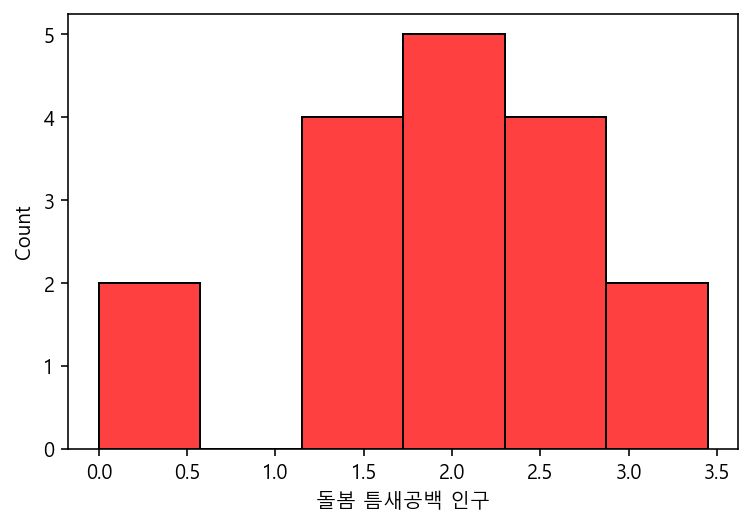

In [68]:
sns.histplot(target_need['돌봄 틈새공백 인구'], color='red')

<AxesSubplot:>

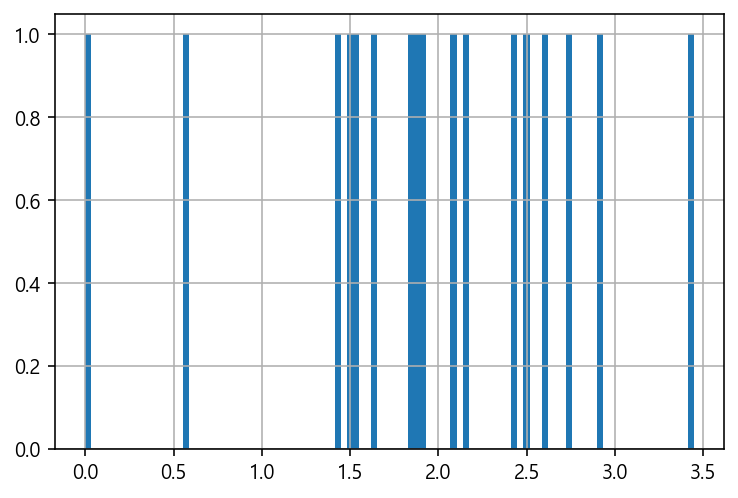

In [69]:
target_need['돌봄 틈새공백 인구'].hist(bins=100)

# 퍼센타일

In [70]:
pt_list = np.percentile(target_need[['돌봄 틈새공백 인구']],[i*10 for i in range(1,10)]).tolist()
pt_list

[1.0843818379315597,
 1.5047822605935917,
 1.6269511407138104,
 1.8610707084368503,
 1.9203652296255307,
 2.1337369606184917,
 2.4530599209944053,
 2.5863613472297518,
 2.809903853132884]

In [71]:
# 초등돌봄틈새 분위 라벨링
target_need['돌봄틈새공백 분위'] = 0
target_need.loc[target_need['돌봄 틈새공백 인구'] <= pt_list[0], '돌봄틈새공백 분위'] = 1
target_need.loc[(target_need['돌봄 틈새공백 인구'] > pt_list[0]) & (target_need['돌봄 틈새공백 인구'] <= pt_list[1]),'돌봄틈새공백 분위'] = 2
target_need.loc[(target_need['돌봄 틈새공백 인구'] > pt_list[1]) & (target_need['돌봄 틈새공백 인구'] <= pt_list[2]),'돌봄틈새공백 분위'] = 3
target_need.loc[(target_need['돌봄 틈새공백 인구'] > pt_list[2]) & (target_need['돌봄 틈새공백 인구'] <= pt_list[3]),'돌봄틈새공백 분위'] = 4
target_need.loc[(target_need['돌봄 틈새공백 인구'] > pt_list[3]) & (target_need['돌봄 틈새공백 인구'] <= pt_list[4]),'돌봄틈새공백 분위'] = 5
target_need.loc[(target_need['돌봄 틈새공백 인구'] > pt_list[4]) & (target_need['돌봄 틈새공백 인구'] <= pt_list[5]),'돌봄틈새공백 분위'] = 6
target_need.loc[(target_need['돌봄 틈새공백 인구'] > pt_list[5]) & (target_need['돌봄 틈새공백 인구'] <= pt_list[6]),'돌봄틈새공백 분위'] = 7
target_need.loc[(target_need['돌봄 틈새공백 인구'] > pt_list[6]) & (target_need['돌봄 틈새공백 인구'] <= pt_list[7]),'돌봄틈새공백 분위'] = 8
target_need.loc[(target_need['돌봄 틈새공백 인구'] > pt_list[7]) & (target_need['돌봄 틈새공백 인구'] <= pt_list[8]),'돌봄틈새공백 분위'] = 9
target_need.loc[(target_need['돌봄 틈새공백 인구'] > pt_list[8]),'돌봄틈새공백 분위'] = 10
target_need

,gid,행정동코드,시군구명,행정동,학교명,학교개수,초등학생_인구,30대_인구,40대_인구,전체_인구,...,geometry,3040대 인구,3040대 결혼율,3040대 기혼인구,3040대 맞벌이 기혼인구,지역별 3040대 맞벌이 기혼인구 비율,초등돌봄필요 인구,돌봄 틈새공백 인구,지역별 돌봄 틈새공백 인구 비율,돌봄틈새공백 분위
0,다사41ab48ba,1150054000,강서구,화곡제1동,"[서울신원초등학교, 서울월정초등학교, 서울신월초등학교]",3,125.0,310.0,359.0,2085.0,...,POINT (126.83644 37.53508),669.0,0.6546,437.927298,217.649867,0.104388,13.048553,2.907520,0.023260,10
1,다사41ab48bb,1150054000,강서구,화곡제1동,"[서울강신초등학교, 서울월정초등학교, 서울신월초등학교]",3,64.0,353.0,360.0,2006.0,...,POINT (126.83642 37.53733),713.0,0.6546,466.729691,231.964656,0.115635,7.400667,1.649040,0.025766,4
2,다사41ab49aa,1150054000,강서구,화곡제1동,"[서울강신초등학교, 서울월정초등학교, 서울신월초등학교]",3,104.0,430.0,403.0,2288.0,...,POINT (126.83640 37.53959),833.0,0.6546,545.281673,271.004991,0.118446,12.318409,2.744827,0.026393,9
3,다사41ba48aa,1150054000,강서구,화곡제1동,"[서울신원초등학교, 서울신강초등학교, 서울월정초등학교]",3,68.0,559.0,397.0,2535.0,...,POINT (126.83931 37.53059),956.0,0.6546,625.797454,311.021335,0.122691,8.342979,1.859009,0.027338,4
4,다사41ba48ab,1150054000,강서구,화곡제1동,"[서울신강초등학교, 서울월정초등학교, 서울신월초등학교]",3,64.0,493.0,350.0,2542.0,...,POINT (126.83929 37.53284),843.0,0.6546,551.827671,274.258353,0.107891,6.905010,1.538596,0.024041,3
5,다사41ba48ba,1150054000,강서구,화곡제1동,"[서울월정초등학교, 서울신월초등학교]",2,143.0,479.0,482.0,2890.0,...,POINT (126.83927 37.53510),961.0,0.6546,629.070453,312.648015,0.108183,15.470127,3.447102,0.024106,10
6,다사41ba48bb,1150054000,강서구,화곡제1동,"[서울화일초등학교, 서울월정초등학교, 서울신월초등학교]",3,85.0,523.0,396.0,2628.0,...,POINT (126.83925 37.53735),919.0,0.6546,601.577260,298.983898,0.113769,9.670332,2.154774,0.025350,7
7,다사41ba49aa,1150054000,강서구,화곡제1동,"[서울화일초등학교, 서울화곡초등학교, 서울월정초등학교, 서울신월초등학교]",4,92.0,517.0,419.0,2553.0,...,POINT (126.83923 37.53960),936.0,0.6546,612.705457,304.514612,0.119277,10.973500,2.445150,0.026578,7
8,다사41bb47bb,1150054000,강서구,화곡제1동,"[서울강서초등학교, 서울신강초등학교, 서울양강초등학교, 서울양동초등학교]",4,63.0,983.0,584.0,3839.0,...,POINT (126.84216 37.52835),1567.0,0.6546,1025.757961,509.801706,0.132795,8.366113,1.864164,0.029590,5
9,다사41bb48aa,1150054000,강서구,화곡제1동,"[서울신강초등학교, 서울월정초등학교]",2,85.0,1209.0,758.0,4878.0,...,POINT (126.84214 37.53060),1967.0,0.6546,1287.597900,639.936156,0.131188,11.150999,2.484701,0.029232,8


In [72]:
target_need.sort_values(by='돌봄 틈새공백 인구',ascending=False)

,gid,행정동코드,시군구명,행정동,학교명,학교개수,초등학생_인구,30대_인구,40대_인구,전체_인구,...,geometry,3040대 인구,3040대 결혼율,3040대 기혼인구,3040대 맞벌이 기혼인구,지역별 3040대 맞벌이 기혼인구 비율,초등돌봄필요 인구,돌봄 틈새공백 인구,지역별 돌봄 틈새공백 인구 비율,돌봄틈새공백 분위
5,다사41ba48ba,1150054000,강서구,화곡제1동,"[서울월정초등학교, 서울신월초등학교]",2,143.0,479.0,482.0,2890.0,...,POINT (126.83927 37.53510),961.0,0.6546,629.070453,312.648015,0.108183,15.470127,3.447102,0.024106,10
0,다사41ab48ba,1150054000,강서구,화곡제1동,"[서울신원초등학교, 서울월정초등학교, 서울신월초등학교]",3,125.0,310.0,359.0,2085.0,...,POINT (126.83644 37.53508),669.0,0.6546,437.927298,217.649867,0.104388,13.048553,2.907520,0.023260,10
2,다사41ab49aa,1150054000,강서구,화곡제1동,"[서울강신초등학교, 서울월정초등학교, 서울신월초등학교]",3,104.0,430.0,403.0,2288.0,...,POINT (126.83640 37.53959),833.0,0.6546,545.281673,271.004991,0.118446,12.318409,2.744827,0.026393,9
11,다사41bb48ba,1150054000,강서구,화곡제1동,"[서울화일초등학교, 서울월정초등학교, 서울신월초등학교]",3,105.0,634.0,604.0,3608.0,...,POINT (126.84210 37.53511),1238.0,0.6546,810.394611,402.766122,0.111631,11.721298,2.611777,0.024874,9
9,다사41bb48aa,1150054000,강서구,화곡제1동,"[서울신강초등학교, 서울월정초등학교]",2,85.0,1209.0,758.0,4878.0,...,POINT (126.84214 37.53060),1967.0,0.6546,1287.597900,639.936156,0.131188,11.150999,2.484701,0.029232,8
7,다사41ba49aa,1150054000,강서구,화곡제1동,"[서울화일초등학교, 서울화곡초등학교, 서울월정초등학교, 서울신월초등학교]",4,92.0,517.0,419.0,2553.0,...,POINT (126.83923 37.53960),936.0,0.6546,612.705457,304.514612,0.119277,10.973500,2.445150,0.026578,7
6,다사41ba48bb,1150054000,강서구,화곡제1동,"[서울화일초등학교, 서울월정초등학교, 서울신월초등학교]",3,85.0,523.0,396.0,2628.0,...,POINT (126.83925 37.53735),919.0,0.6546,601.577260,298.983898,0.113769,9.670332,2.154774,0.025350,7
14,다사42aa48aa,1150054000,강서구,화곡제1동,"[서울신강초등학교, 서울양강초등학교, 서울양동초등학교, 서울신정초등학교]",4,72.0,1168.0,613.0,4422.0,...,POINT (126.84497 37.53062),1781.0,0.6546,1165.842328,579.423637,0.131032,9.434306,2.102182,0.029197,6
10,다사41bb48ab,1150054000,강서구,화곡제1동,"[서울신강초등학교, 서울월정초등학교, 서울신월초등학교]",3,78.0,648.0,468.0,3286.0,...,POINT (126.84212 37.53286),1116.0,0.6546,730.533430,363.075115,0.110492,8.618338,1.920365,0.024620,5
8,다사41bb47bb,1150054000,강서구,화곡제1동,"[서울강서초등학교, 서울신강초등학교, 서울양강초등학교, 서울양동초등학교]",4,63.0,983.0,584.0,3839.0,...,POINT (126.84216 37.52835),1567.0,0.6546,1025.757961,509.801706,0.132795,8.366113,1.864164,0.029590,5


In [73]:
target_df = target_need[['gid', '행정동코드', '시군구명', '행정동', '학교명', '학교개수', '초등학생_인구', '30대_인구',
       '40대_인구', '전체_인구', '경도', '위도', 'geometry', '돌봄 틈새공백 인구', '지역별 돌봄 틈새공백 인구 비율', '돌봄틈새공백 분위']]
target_df

,gid,행정동코드,시군구명,행정동,학교명,학교개수,초등학생_인구,30대_인구,40대_인구,전체_인구,경도,위도,geometry,돌봄 틈새공백 인구,지역별 돌봄 틈새공백 인구 비율,돌봄틈새공백 분위
0,다사41ab48ba,1150054000,강서구,화곡제1동,"[서울신원초등학교, 서울월정초등학교, 서울신월초등학교]",3,125.0,310.0,359.0,2085.0,126.836440,37.535080,POINT (126.83644 37.53508),2.907520,0.023260,10
1,다사41ab48bb,1150054000,강서구,화곡제1동,"[서울강신초등학교, 서울월정초등학교, 서울신월초등학교]",3,64.0,353.0,360.0,2006.0,126.836420,37.537333,POINT (126.83642 37.53733),1.649040,0.025766,4
2,다사41ab49aa,1150054000,강서구,화곡제1동,"[서울강신초등학교, 서울월정초등학교, 서울신월초등학교]",3,104.0,430.0,403.0,2288.0,126.836400,37.539586,POINT (126.83640 37.53959),2.744827,0.026393,9
3,다사41ba48aa,1150054000,강서구,화곡제1동,"[서울신원초등학교, 서울신강초등학교, 서울월정초등학교]",3,68.0,559.0,397.0,2535.0,126.839309,37.530589,POINT (126.83931 37.53059),1.859009,0.027338,4
4,다사41ba48ab,1150054000,강서구,화곡제1동,"[서울신강초등학교, 서울월정초등학교, 서울신월초등학교]",3,64.0,493.0,350.0,2542.0,126.839289,37.532842,POINT (126.83929 37.53284),1.538596,0.024041,3
5,다사41ba48ba,1150054000,강서구,화곡제1동,"[서울월정초등학교, 서울신월초등학교]",2,143.0,479.0,482.0,2890.0,126.839270,37.535096,POINT (126.83927 37.53510),3.447102,0.024106,10
6,다사41ba48bb,1150054000,강서구,화곡제1동,"[서울화일초등학교, 서울월정초등학교, 서울신월초등학교]",3,85.0,523.0,396.0,2628.0,126.839250,37.537349,POINT (126.83925 37.53735),2.154774,0.025350,7
7,다사41ba49aa,1150054000,강서구,화곡제1동,"[서울화일초등학교, 서울화곡초등학교, 서울월정초등학교, 서울신월초등학교]",4,92.0,517.0,419.0,2553.0,126.839230,37.539602,POINT (126.83923 37.53960),2.445150,0.026578,7
8,다사41bb47bb,1150054000,강서구,화곡제1동,"[서울강서초등학교, 서울신강초등학교, 서울양강초등학교, 서울양동초등학교]",4,63.0,983.0,584.0,3839.0,126.842158,37.528352,POINT (126.84216 37.52835),1.864164,0.029590,5
9,다사41bb48aa,1150054000,강서구,화곡제1동,"[서울신강초등학교, 서울월정초등학교]",2,85.0,1209.0,758.0,4878.0,126.842139,37.530605,POINT (126.84214 37.53060),2.484701,0.029232,8


In [74]:
target_df.to_csv('강서구 돌봄틈새공백.csv')
target_df.to_pickle('강서구 돌봄틈새공백.pkl')

### 광진구

In [75]:
target = pklopen('동3개_초등학교881m_인구.pickle')
target

C:\anaconda3\lib\site-packages\pyproj\crs\crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


,gid,행정동코드,시군구명,행정동,학교명,학교개수,초등학생_인구,30대_인구,40대_인구,전체_인구,경도,위도,geometry
0,다사41ab48ba,1150054000,강서구,화곡제1동,"[서울신원초등학교, 서울월정초등학교, 서울신월초등학교]",3,125.0,310.0,359.0,2085.0,126.836440,37.535080,POINT (126.83644 37.53508)
1,다사41ab48bb,1150054000,강서구,화곡제1동,"[서울강신초등학교, 서울월정초등학교, 서울신월초등학교]",3,64.0,353.0,360.0,2006.0,126.836420,37.537333,POINT (126.83642 37.53733)
2,다사41ab49aa,1150054000,강서구,화곡제1동,"[서울강신초등학교, 서울월정초등학교, 서울신월초등학교]",3,104.0,430.0,403.0,2288.0,126.836400,37.539586,POINT (126.83640 37.53959)
3,다사41ba48aa,1150054000,강서구,화곡제1동,"[서울신원초등학교, 서울신강초등학교, 서울월정초등학교]",3,68.0,559.0,397.0,2535.0,126.839309,37.530589,POINT (126.83931 37.53059)
4,다사41ba48ab,1150054000,강서구,화곡제1동,"[서울신강초등학교, 서울월정초등학교, 서울신월초등학교]",3,64.0,493.0,350.0,2542.0,126.839289,37.532842,POINT (126.83929 37.53284)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,다사65ab50ab,1121581000,광진구,광장동,"[서울광장초등학교, 서울동의초등학교]",2,14.0,43.0,43.0,433.0,127.107999,37.552067,POINT (127.10800 37.55207)
79,다사65ab50ba,1121581000,광진구,광장동,"[서울광장초등학교, 서울동의초등학교]",2,0.0,0.0,0.0,0.0,127.107987,37.554320,POINT (127.10799 37.55432)
80,다사65ab50bb,1121581000,광진구,광장동,[서울동의초등학교],1,0.0,0.0,0.0,0.0,127.107975,37.556574,POINT (127.10798 37.55657)
81,다사65ba49bb,1121581000,광진구,광장동,[서울광장초등학교],1,0.0,0.0,6.0,32.0,127.110853,37.547570,POINT (127.11085 37.54757)


In [76]:
target = target[target.시군구명=='광진구']
target

,gid,행정동코드,시군구명,행정동,학교명,학교개수,초등학생_인구,30대_인구,40대_인구,전체_인구,경도,위도,geometry
44,다사64aa49ab,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울광진초등학교, 서울구남초등학교]",4,229.0,184.0,493.0,2184.0,127.093896,37.543006,POINT (127.09390 37.54301)
45,다사64ab49aa,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울구남초등학교]",3,137.0,133.0,309.0,1335.0,127.096739,37.540762,POINT (127.09674 37.54076)
46,다사64ab49ab,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울광장초등학교, 서울광진초등학교, 서울구남초...",5,492.0,351.0,1044.0,4248.0,127.096726,37.543016,POINT (127.09673 37.54302)
47,다사64ab49ba,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울광장초등학교, 서울광진초등학교]",4,0.0,0.0,0.0,0.0,127.096714,37.545269,POINT (127.09671 37.54527)
48,다사64ba48bb,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울구남초등학교]",3,182.0,622.0,569.0,3155.0,127.099580,37.538519,POINT (127.09958 37.53852)
49,다사64ba49aa,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울구남초등학교]",3,677.0,443.0,1356.0,5484.0,127.099568,37.540772,POINT (127.09957 37.54077)
50,다사64ba49ab,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울광장초등학교]",3,529.0,323.0,1026.0,3971.0,127.099556,37.543025,POINT (127.09956 37.54303)
51,다사64ba49ba,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울광장초등학교, 서울광진초등학교]",4,0.0,0.0,0.0,0.0,127.099544,37.545279,POINT (127.09954 37.54528)
52,다사64ba49bb,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울광장초등학교, 서울동의초등학교, 서울광진초...",5,0.0,0.0,10.0,79.0,127.099532,37.547532,POINT (127.09953 37.54753)
53,다사64ba50aa,1121581000,광진구,광장동,"[서울양진초등학교, 서울광장초등학교, 서울동의초등학교, 서울광진초등학교]",4,0.0,0.0,0.0,7.0,127.099520,37.549785,POINT (127.09952 37.54979)


In [77]:
married_rate_gu_df

,시군구명,3040대 결혼율
0,합계,0.634570
1,종로구,0.588887
2,중구,0.557223
3,용산구,0.593661
4,성동구,0.628100
5,광진구,0.593863
6,동대문구,0.604736
7,중랑구,0.598189
8,성북구,0.662632
9,강북구,0.575451


In [78]:
# married_rate_gu_df[married_rate_gu_df['시군구명']=='은평구']['3040대 결혼율'].iloc[0]

In [79]:
target['3040대 인구'] = target['30대_인구']+target['40대_인구']
target_need = pd.merge(target, married_rate_gu_df, on='시군구명')
target_need

<ipython-input-79-b5b835a03157>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target['3040대 인구'] = target['30대_인구']+target['40대_인구']


,gid,행정동코드,시군구명,행정동,학교명,학교개수,초등학생_인구,30대_인구,40대_인구,전체_인구,경도,위도,geometry,3040대 인구,3040대 결혼율
0,다사64aa49ab,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울광진초등학교, 서울구남초등학교]",4,229.0,184.0,493.0,2184.0,127.093896,37.543006,POINT (127.09390 37.54301),677.0,0.593863
1,다사64ab49aa,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울구남초등학교]",3,137.0,133.0,309.0,1335.0,127.096739,37.540762,POINT (127.09674 37.54076),442.0,0.593863
2,다사64ab49ab,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울광장초등학교, 서울광진초등학교, 서울구남초...",5,492.0,351.0,1044.0,4248.0,127.096726,37.543016,POINT (127.09673 37.54302),1395.0,0.593863
3,다사64ab49ba,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울광장초등학교, 서울광진초등학교]",4,0.0,0.0,0.0,0.0,127.096714,37.545269,POINT (127.09671 37.54527),0.0,0.593863
4,다사64ba48bb,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울구남초등학교]",3,182.0,622.0,569.0,3155.0,127.099580,37.538519,POINT (127.09958 37.53852),1191.0,0.593863
5,다사64ba49aa,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울구남초등학교]",3,677.0,443.0,1356.0,5484.0,127.099568,37.540772,POINT (127.09957 37.54077),1799.0,0.593863
6,다사64ba49ab,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울광장초등학교]",3,529.0,323.0,1026.0,3971.0,127.099556,37.543025,POINT (127.09956 37.54303),1349.0,0.593863
7,다사64ba49ba,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울광장초등학교, 서울광진초등학교]",4,0.0,0.0,0.0,0.0,127.099544,37.545279,POINT (127.09954 37.54528),0.0,0.593863
8,다사64ba49bb,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울광장초등학교, 서울동의초등학교, 서울광진초...",5,0.0,0.0,10.0,79.0,127.099532,37.547532,POINT (127.09953 37.54753),10.0,0.593863
9,다사64ba50aa,1121581000,광진구,광장동,"[서울양진초등학교, 서울광장초등학교, 서울동의초등학교, 서울광진초등학교]",4,0.0,0.0,0.0,7.0,127.099520,37.549785,POINT (127.09952 37.54979),0.0,0.593863


In [80]:
target_need['3040대 기혼인구'] = target_need['3040대 인구'] * target_need['3040대 결혼율']
target_need

,gid,행정동코드,시군구명,행정동,학교명,학교개수,초등학생_인구,30대_인구,40대_인구,전체_인구,경도,위도,geometry,3040대 인구,3040대 결혼율,3040대 기혼인구
0,다사64aa49ab,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울광진초등학교, 서울구남초등학교]",4,229.0,184.0,493.0,2184.0,127.093896,37.543006,POINT (127.09390 37.54301),677.0,0.593863,402.044961
1,다사64ab49aa,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울구남초등학교]",3,137.0,133.0,309.0,1335.0,127.096739,37.540762,POINT (127.09674 37.54076),442.0,0.593863,262.487257
2,다사64ab49ab,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울광장초등학교, 서울광진초등학교, 서울구남초...",5,492.0,351.0,1044.0,4248.0,127.096726,37.543016,POINT (127.09673 37.54302),1395.0,0.593863,828.438287
3,다사64ab49ba,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울광장초등학교, 서울광진초등학교]",4,0.0,0.0,0.0,0.0,127.096714,37.545269,POINT (127.09671 37.54527),0.0,0.593863,0.000000
4,다사64ba48bb,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울구남초등학교]",3,182.0,622.0,569.0,3155.0,127.099580,37.538519,POINT (127.09958 37.53852),1191.0,0.593863,707.290323
5,다사64ba49aa,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울구남초등학교]",3,677.0,443.0,1356.0,5484.0,127.099568,37.540772,POINT (127.09957 37.54077),1799.0,0.593863,1068.358766
6,다사64ba49ab,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울광장초등학교]",3,529.0,323.0,1026.0,3971.0,127.099556,37.543025,POINT (127.09956 37.54303),1349.0,0.593863,801.120609
7,다사64ba49ba,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울광장초등학교, 서울광진초등학교]",4,0.0,0.0,0.0,0.0,127.099544,37.545279,POINT (127.09954 37.54528),0.0,0.593863,0.000000
8,다사64ba49bb,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울광장초등학교, 서울동의초등학교, 서울광진초...",5,0.0,0.0,10.0,79.0,127.099532,37.547532,POINT (127.09953 37.54753),10.0,0.593863,5.938626
9,다사64ba50aa,1121581000,광진구,광장동,"[서울양진초등학교, 서울광장초등학교, 서울동의초등학교, 서울광진초등학교]",4,0.0,0.0,0.0,7.0,127.099520,37.549785,POINT (127.09952 37.54979),0.0,0.593863,0.000000


In [81]:
#맞벌이 비율 곱하기
both_30s = both_rate_df.iloc[2,3]
both_40s = both_rate_df.iloc[3,3]
both_3040s = (both_30s + both_40s)/2
both_3040s


0.497

In [82]:
target_need['3040대 맞벌이 기혼인구'] = (target_need['3040대 기혼인구']*both_3040s)
target_need

,gid,행정동코드,시군구명,행정동,학교명,학교개수,초등학생_인구,30대_인구,40대_인구,전체_인구,경도,위도,geometry,3040대 인구,3040대 결혼율,3040대 기혼인구,3040대 맞벌이 기혼인구
0,다사64aa49ab,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울광진초등학교, 서울구남초등학교]",4,229.0,184.0,493.0,2184.0,127.093896,37.543006,POINT (127.09390 37.54301),677.0,0.593863,402.044961,199.816346
1,다사64ab49aa,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울구남초등학교]",3,137.0,133.0,309.0,1335.0,127.096739,37.540762,POINT (127.09674 37.54076),442.0,0.593863,262.487257,130.456167
2,다사64ab49ab,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울광장초등학교, 서울광진초등학교, 서울구남초...",5,492.0,351.0,1044.0,4248.0,127.096726,37.543016,POINT (127.09673 37.54302),1395.0,0.593863,828.438287,411.733829
3,다사64ab49ba,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울광장초등학교, 서울광진초등학교]",4,0.0,0.0,0.0,0.0,127.096714,37.545269,POINT (127.09671 37.54527),0.0,0.593863,0.000000,0.000000
4,다사64ba48bb,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울구남초등학교]",3,182.0,622.0,569.0,3155.0,127.099580,37.538519,POINT (127.09958 37.53852),1191.0,0.593863,707.290323,351.523290
5,다사64ba49aa,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울구남초등학교]",3,677.0,443.0,1356.0,5484.0,127.099568,37.540772,POINT (127.09957 37.54077),1799.0,0.593863,1068.358766,530.974307
6,다사64ba49ab,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울광장초등학교]",3,529.0,323.0,1026.0,3971.0,127.099556,37.543025,POINT (127.09956 37.54303),1349.0,0.593863,801.120609,398.156943
7,다사64ba49ba,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울광장초등학교, 서울광진초등학교]",4,0.0,0.0,0.0,0.0,127.099544,37.545279,POINT (127.09954 37.54528),0.0,0.593863,0.000000,0.000000
8,다사64ba49bb,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울광장초등학교, 서울동의초등학교, 서울광진초...",5,0.0,0.0,10.0,79.0,127.099532,37.547532,POINT (127.09953 37.54753),10.0,0.593863,5.938626,2.951497
9,다사64ba50aa,1121581000,광진구,광장동,"[서울양진초등학교, 서울광장초등학교, 서울동의초등학교, 서울광진초등학교]",4,0.0,0.0,0.0,7.0,127.099520,37.549785,POINT (127.09952 37.54979),0.0,0.593863,0.000000,0.000000


In [83]:
target_need['지역별 3040대 맞벌이 기혼인구 비율'] = target_need['3040대 맞벌이 기혼인구']/target_need['전체_인구']
target_need = target_need.fillna(0)
target_need

,gid,행정동코드,시군구명,행정동,학교명,학교개수,초등학생_인구,30대_인구,40대_인구,전체_인구,경도,위도,geometry,3040대 인구,3040대 결혼율,3040대 기혼인구,3040대 맞벌이 기혼인구,지역별 3040대 맞벌이 기혼인구 비율
0,다사64aa49ab,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울광진초등학교, 서울구남초등학교]",4,229.0,184.0,493.0,2184.0,127.093896,37.543006,POINT (127.09390 37.54301),677.0,0.593863,402.044961,199.816346,0.091491
1,다사64ab49aa,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울구남초등학교]",3,137.0,133.0,309.0,1335.0,127.096739,37.540762,POINT (127.09674 37.54076),442.0,0.593863,262.487257,130.456167,0.097720
2,다사64ab49ab,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울광장초등학교, 서울광진초등학교, 서울구남초...",5,492.0,351.0,1044.0,4248.0,127.096726,37.543016,POINT (127.09673 37.54302),1395.0,0.593863,828.438287,411.733829,0.096924
3,다사64ab49ba,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울광장초등학교, 서울광진초등학교]",4,0.0,0.0,0.0,0.0,127.096714,37.545269,POINT (127.09671 37.54527),0.0,0.593863,0.000000,0.000000,0.000000
4,다사64ba48bb,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울구남초등학교]",3,182.0,622.0,569.0,3155.0,127.099580,37.538519,POINT (127.09958 37.53852),1191.0,0.593863,707.290323,351.523290,0.111418
5,다사64ba49aa,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울구남초등학교]",3,677.0,443.0,1356.0,5484.0,127.099568,37.540772,POINT (127.09957 37.54077),1799.0,0.593863,1068.358766,530.974307,0.096822
6,다사64ba49ab,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울광장초등학교]",3,529.0,323.0,1026.0,3971.0,127.099556,37.543025,POINT (127.09956 37.54303),1349.0,0.593863,801.120609,398.156943,0.100266
7,다사64ba49ba,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울광장초등학교, 서울광진초등학교]",4,0.0,0.0,0.0,0.0,127.099544,37.545279,POINT (127.09954 37.54528),0.0,0.593863,0.000000,0.000000,0.000000
8,다사64ba49bb,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울광장초등학교, 서울동의초등학교, 서울광진초...",5,0.0,0.0,10.0,79.0,127.099532,37.547532,POINT (127.09953 37.54753),10.0,0.593863,5.938626,2.951497,0.037361
9,다사64ba50aa,1121581000,광진구,광장동,"[서울양진초등학교, 서울광장초등학교, 서울동의초등학교, 서울광진초등학교]",4,0.0,0.0,0.0,7.0,127.099520,37.549785,POINT (127.09952 37.54979),0.0,0.593863,0.000000,0.000000,0.000000


In [84]:
target_need['초등돌봄필요 인구'] = target_need['초등학생_인구']*target_need['지역별 3040대 맞벌이 기혼인구 비율']
target_need = target_need.fillna(0)
target_need

,gid,행정동코드,시군구명,행정동,학교명,학교개수,초등학생_인구,30대_인구,40대_인구,전체_인구,경도,위도,geometry,3040대 인구,3040대 결혼율,3040대 기혼인구,3040대 맞벌이 기혼인구,지역별 3040대 맞벌이 기혼인구 비율,초등돌봄필요 인구
0,다사64aa49ab,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울광진초등학교, 서울구남초등학교]",4,229.0,184.0,493.0,2184.0,127.093896,37.543006,POINT (127.09390 37.54301),677.0,0.593863,402.044961,199.816346,0.091491,20.951439
1,다사64ab49aa,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울구남초등학교]",3,137.0,133.0,309.0,1335.0,127.096739,37.540762,POINT (127.09674 37.54076),442.0,0.593863,262.487257,130.456167,0.097720,13.387637
2,다사64ab49ab,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울광장초등학교, 서울광진초등학교, 서울구남초...",5,492.0,351.0,1044.0,4248.0,127.096726,37.543016,POINT (127.09673 37.54302),1395.0,0.593863,828.438287,411.733829,0.096924,47.686686
3,다사64ab49ba,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울광장초등학교, 서울광진초등학교]",4,0.0,0.0,0.0,0.0,127.096714,37.545269,POINT (127.09671 37.54527),0.0,0.593863,0.000000,0.000000,0.000000,0.000000
4,다사64ba48bb,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울구남초등학교]",3,182.0,622.0,569.0,3155.0,127.099580,37.538519,POINT (127.09958 37.53852),1191.0,0.593863,707.290323,351.523290,0.111418,20.278047
5,다사64ba49aa,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울구남초등학교]",3,677.0,443.0,1356.0,5484.0,127.099568,37.540772,POINT (127.09957 37.54077),1799.0,0.593863,1068.358766,530.974307,0.096822,65.548798
6,다사64ba49ab,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울광장초등학교]",3,529.0,323.0,1026.0,3971.0,127.099556,37.543025,POINT (127.09956 37.54303),1349.0,0.593863,801.120609,398.156943,0.100266,53.040801
7,다사64ba49ba,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울광장초등학교, 서울광진초등학교]",4,0.0,0.0,0.0,0.0,127.099544,37.545279,POINT (127.09954 37.54528),0.0,0.593863,0.000000,0.000000,0.000000,0.000000
8,다사64ba49bb,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울광장초등학교, 서울동의초등학교, 서울광진초...",5,0.0,0.0,10.0,79.0,127.099532,37.547532,POINT (127.09953 37.54753),10.0,0.593863,5.938626,2.951497,0.037361,0.000000
9,다사64ba50aa,1121581000,광진구,광장동,"[서울양진초등학교, 서울광장초등학교, 서울동의초등학교, 서울광진초등학교]",4,0.0,0.0,0.0,7.0,127.099520,37.549785,POINT (127.09952 37.54979),0.0,0.593863,0.000000,0.000000,0.000000,0.000000


In [85]:
target_need['돌봄 틈새공백 인구'] = target_need['초등돌봄필요 인구'] * AR
target_need = target_need.fillna(0)
target_need

,gid,행정동코드,시군구명,행정동,학교명,학교개수,초등학생_인구,30대_인구,40대_인구,전체_인구,경도,위도,geometry,3040대 인구,3040대 결혼율,3040대 기혼인구,3040대 맞벌이 기혼인구,지역별 3040대 맞벌이 기혼인구 비율,초등돌봄필요 인구,돌봄 틈새공백 인구
0,다사64aa49ab,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울광진초등학교, 서울구남초등학교]",4,229.0,184.0,493.0,2184.0,127.093896,37.543006,POINT (127.09390 37.54301),677.0,0.593863,402.044961,199.816346,0.091491,20.951439,4.668466
1,다사64ab49aa,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울구남초등학교]",3,137.0,133.0,309.0,1335.0,127.096739,37.540762,POINT (127.09674 37.54076),442.0,0.593863,262.487257,130.456167,0.097720,13.387637,2.983075
2,다사64ab49ab,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울광장초등학교, 서울광진초등학교, 서울구남초...",5,492.0,351.0,1044.0,4248.0,127.096726,37.543016,POINT (127.09673 37.54302),1395.0,0.593863,828.438287,411.733829,0.096924,47.686686,10.625698
3,다사64ab49ba,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울광장초등학교, 서울광진초등학교]",4,0.0,0.0,0.0,0.0,127.096714,37.545269,POINT (127.09671 37.54527),0.0,0.593863,0.000000,0.000000,0.000000,0.000000,0.000000
4,다사64ba48bb,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울구남초등학교]",3,182.0,622.0,569.0,3155.0,127.099580,37.538519,POINT (127.09958 37.53852),1191.0,0.593863,707.290323,351.523290,0.111418,20.278047,4.518418
5,다사64ba49aa,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울구남초등학교]",3,677.0,443.0,1356.0,5484.0,127.099568,37.540772,POINT (127.09957 37.54077),1799.0,0.593863,1068.358766,530.974307,0.096822,65.548798,14.605789
6,다사64ba49ab,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울광장초등학교]",3,529.0,323.0,1026.0,3971.0,127.099556,37.543025,POINT (127.09956 37.54303),1349.0,0.593863,801.120609,398.156943,0.100266,53.040801,11.818718
7,다사64ba49ba,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울광장초등학교, 서울광진초등학교]",4,0.0,0.0,0.0,0.0,127.099544,37.545279,POINT (127.09954 37.54528),0.0,0.593863,0.000000,0.000000,0.000000,0.000000,0.000000
8,다사64ba49bb,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울광장초등학교, 서울동의초등학교, 서울광진초...",5,0.0,0.0,10.0,79.0,127.099532,37.547532,POINT (127.09953 37.54753),10.0,0.593863,5.938626,2.951497,0.037361,0.000000,0.000000
9,다사64ba50aa,1121581000,광진구,광장동,"[서울양진초등학교, 서울광장초등학교, 서울동의초등학교, 서울광진초등학교]",4,0.0,0.0,0.0,7.0,127.099520,37.549785,POINT (127.09952 37.54979),0.0,0.593863,0.000000,0.000000,0.000000,0.000000,0.000000


In [86]:
target_need['지역별 돌봄 틈새공백 인구 비율'] = target_need['돌봄 틈새공백 인구'] /target_need['초등학생_인구']
target_need = target_need.fillna(0)
target_need

,gid,행정동코드,시군구명,행정동,학교명,학교개수,초등학생_인구,30대_인구,40대_인구,전체_인구,...,위도,geometry,3040대 인구,3040대 결혼율,3040대 기혼인구,3040대 맞벌이 기혼인구,지역별 3040대 맞벌이 기혼인구 비율,초등돌봄필요 인구,돌봄 틈새공백 인구,지역별 돌봄 틈새공백 인구 비율
0,다사64aa49ab,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울광진초등학교, 서울구남초등학교]",4,229.0,184.0,493.0,2184.0,...,37.543006,POINT (127.09390 37.54301),677.0,0.593863,402.044961,199.816346,0.091491,20.951439,4.668466,0.020386
1,다사64ab49aa,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울구남초등학교]",3,137.0,133.0,309.0,1335.0,...,37.540762,POINT (127.09674 37.54076),442.0,0.593863,262.487257,130.456167,0.097720,13.387637,2.983075,0.021774
2,다사64ab49ab,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울광장초등학교, 서울광진초등학교, 서울구남초...",5,492.0,351.0,1044.0,4248.0,...,37.543016,POINT (127.09673 37.54302),1395.0,0.593863,828.438287,411.733829,0.096924,47.686686,10.625698,0.021597
3,다사64ab49ba,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울광장초등학교, 서울광진초등학교]",4,0.0,0.0,0.0,0.0,...,37.545269,POINT (127.09671 37.54527),0.0,0.593863,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,다사64ba48bb,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울구남초등학교]",3,182.0,622.0,569.0,3155.0,...,37.538519,POINT (127.09958 37.53852),1191.0,0.593863,707.290323,351.523290,0.111418,20.278047,4.518418,0.024826
5,다사64ba49aa,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울구남초등학교]",3,677.0,443.0,1356.0,5484.0,...,37.540772,POINT (127.09957 37.54077),1799.0,0.593863,1068.358766,530.974307,0.096822,65.548798,14.605789,0.021574
6,다사64ba49ab,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울광장초등학교]",3,529.0,323.0,1026.0,3971.0,...,37.543025,POINT (127.09956 37.54303),1349.0,0.593863,801.120609,398.156943,0.100266,53.040801,11.818718,0.022342
7,다사64ba49ba,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울광장초등학교, 서울광진초등학교]",4,0.0,0.0,0.0,0.0,...,37.545279,POINT (127.09954 37.54528),0.0,0.593863,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,다사64ba49bb,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울광장초등학교, 서울동의초등학교, 서울광진초...",5,0.0,0.0,10.0,79.0,...,37.547532,POINT (127.09953 37.54753),10.0,0.593863,5.938626,2.951497,0.037361,0.000000,0.000000,0.000000
9,다사64ba50aa,1121581000,광진구,광장동,"[서울양진초등학교, 서울광장초등학교, 서울동의초등학교, 서울광진초등학교]",4,0.0,0.0,0.0,7.0,...,37.549785,POINT (127.09952 37.54979),0.0,0.593863,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


<AxesSubplot:xlabel='돌봄 틈새공백 인구', ylabel='Count'>

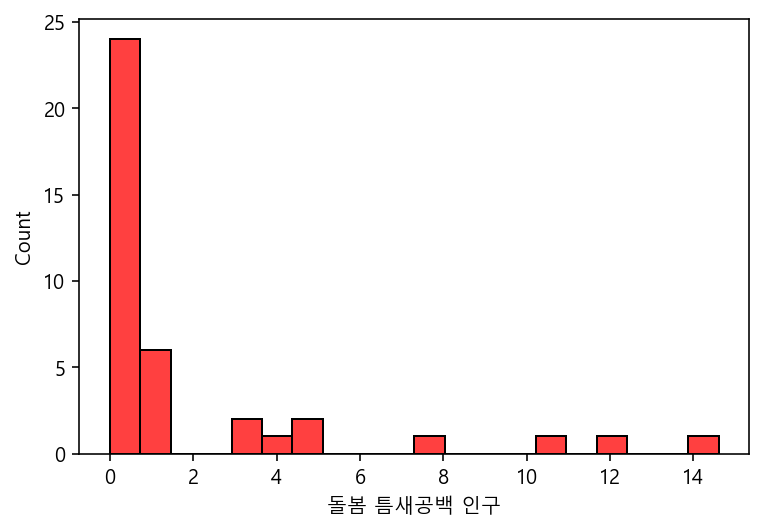

In [87]:
sns.histplot(target_need['돌봄 틈새공백 인구'], color='red')

<AxesSubplot:>

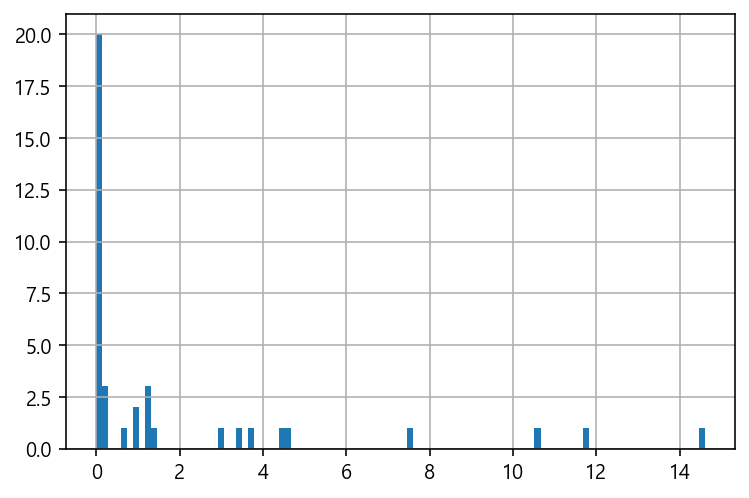

In [88]:
target_need['돌봄 틈새공백 인구'].hist(bins=100)

# 퍼센타일

In [89]:
pt_list = np.percentile(target_need[['돌봄 틈새공백 인구']],[i*10 for i in range(1,10)]).tolist()
pt_list

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.5310704204879346,
 1.225969010341597,
 3.1599228738177194,
 5.24650328578478]

In [90]:
# 초등돌봄틈새 분위 라벨링
target_need['돌봄틈새공백 분위'] = 0
target_need.loc[target_need['돌봄 틈새공백 인구'] <= pt_list[0], '돌봄틈새공백 분위'] = 1
target_need.loc[(target_need['돌봄 틈새공백 인구'] > pt_list[0]) & (target_need['돌봄 틈새공백 인구'] <= pt_list[1]),'돌봄틈새공백 분위'] = 2
target_need.loc[(target_need['돌봄 틈새공백 인구'] > pt_list[1]) & (target_need['돌봄 틈새공백 인구'] <= pt_list[2]),'돌봄틈새공백 분위'] = 3
target_need.loc[(target_need['돌봄 틈새공백 인구'] > pt_list[2]) & (target_need['돌봄 틈새공백 인구'] <= pt_list[3]),'돌봄틈새공백 분위'] = 4
target_need.loc[(target_need['돌봄 틈새공백 인구'] > pt_list[3]) & (target_need['돌봄 틈새공백 인구'] <= pt_list[4]),'돌봄틈새공백 분위'] = 5
target_need.loc[(target_need['돌봄 틈새공백 인구'] > pt_list[4]) & (target_need['돌봄 틈새공백 인구'] <= pt_list[5]),'돌봄틈새공백 분위'] = 6
target_need.loc[(target_need['돌봄 틈새공백 인구'] > pt_list[5]) & (target_need['돌봄 틈새공백 인구'] <= pt_list[6]),'돌봄틈새공백 분위'] = 7
target_need.loc[(target_need['돌봄 틈새공백 인구'] > pt_list[6]) & (target_need['돌봄 틈새공백 인구'] <= pt_list[7]),'돌봄틈새공백 분위'] = 8
target_need.loc[(target_need['돌봄 틈새공백 인구'] > pt_list[7]) & (target_need['돌봄 틈새공백 인구'] <= pt_list[8]),'돌봄틈새공백 분위'] = 9
target_need.loc[(target_need['돌봄 틈새공백 인구'] > pt_list[8]),'돌봄틈새공백 분위'] = 10
target_need

,gid,행정동코드,시군구명,행정동,학교명,학교개수,초등학생_인구,30대_인구,40대_인구,전체_인구,...,geometry,3040대 인구,3040대 결혼율,3040대 기혼인구,3040대 맞벌이 기혼인구,지역별 3040대 맞벌이 기혼인구 비율,초등돌봄필요 인구,돌봄 틈새공백 인구,지역별 돌봄 틈새공백 인구 비율,돌봄틈새공백 분위
0,다사64aa49ab,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울광진초등학교, 서울구남초등학교]",4,229.0,184.0,493.0,2184.0,...,POINT (127.09390 37.54301),677.0,0.593863,402.044961,199.816346,0.091491,20.951439,4.668466,0.020386,9
1,다사64ab49aa,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울구남초등학교]",3,137.0,133.0,309.0,1335.0,...,POINT (127.09674 37.54076),442.0,0.593863,262.487257,130.456167,0.097720,13.387637,2.983075,0.021774,8
2,다사64ab49ab,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울광장초등학교, 서울광진초등학교, 서울구남초...",5,492.0,351.0,1044.0,4248.0,...,POINT (127.09673 37.54302),1395.0,0.593863,828.438287,411.733829,0.096924,47.686686,10.625698,0.021597,10
3,다사64ab49ba,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울광장초등학교, 서울광진초등학교]",4,0.0,0.0,0.0,0.0,...,POINT (127.09671 37.54527),0.0,0.593863,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
4,다사64ba48bb,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울구남초등학교]",3,182.0,622.0,569.0,3155.0,...,POINT (127.09958 37.53852),1191.0,0.593863,707.290323,351.523290,0.111418,20.278047,4.518418,0.024826,9
5,다사64ba49aa,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울구남초등학교]",3,677.0,443.0,1356.0,5484.0,...,POINT (127.09957 37.54077),1799.0,0.593863,1068.358766,530.974307,0.096822,65.548798,14.605789,0.021574,10
6,다사64ba49ab,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울광장초등학교]",3,529.0,323.0,1026.0,3971.0,...,POINT (127.09956 37.54303),1349.0,0.593863,801.120609,398.156943,0.100266,53.040801,11.818718,0.022342,10
7,다사64ba49ba,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울광장초등학교, 서울광진초등학교]",4,0.0,0.0,0.0,0.0,...,POINT (127.09954 37.54528),0.0,0.593863,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
8,다사64ba49bb,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울광장초등학교, 서울동의초등학교, 서울광진초...",5,0.0,0.0,10.0,79.0,...,POINT (127.09953 37.54753),10.0,0.593863,5.938626,2.951497,0.037361,0.000000,0.000000,0.000000,1
9,다사64ba50aa,1121581000,광진구,광장동,"[서울양진초등학교, 서울광장초등학교, 서울동의초등학교, 서울광진초등학교]",4,0.0,0.0,0.0,7.0,...,POINT (127.09952 37.54979),0.0,0.593863,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1


In [91]:
target_need.sort_values(by='돌봄 틈새공백 인구',ascending=False)

,gid,행정동코드,시군구명,행정동,학교명,학교개수,초등학생_인구,30대_인구,40대_인구,전체_인구,...,geometry,3040대 인구,3040대 결혼율,3040대 기혼인구,3040대 맞벌이 기혼인구,지역별 3040대 맞벌이 기혼인구 비율,초등돌봄필요 인구,돌봄 틈새공백 인구,지역별 돌봄 틈새공백 인구 비율,돌봄틈새공백 분위
5,다사64ba49aa,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울구남초등학교]",3,677.0,443.0,1356.0,5484.0,...,POINT (127.09957 37.54077),1799.0,0.593863,1068.358766,530.974307,0.096822,65.548798,14.605789,0.021574,10
6,다사64ba49ab,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울광장초등학교]",3,529.0,323.0,1026.0,3971.0,...,POINT (127.09956 37.54303),1349.0,0.593863,801.120609,398.156943,0.100266,53.040801,11.818718,0.022342,10
2,다사64ab49ab,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울광장초등학교, 서울광진초등학교, 서울구남초...",5,492.0,351.0,1044.0,4248.0,...,POINT (127.09673 37.54302),1395.0,0.593863,828.438287,411.733829,0.096924,47.686686,10.625698,0.021597,10
14,다사64bb49ab,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울광장초등학교]",3,365.0,310.0,805.0,3541.0,...,POINT (127.10239 37.54303),1115.0,0.593863,662.156767,329.091913,0.092938,33.922211,7.558654,0.020709,10
0,다사64aa49ab,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울광진초등학교, 서울구남초등학교]",4,229.0,184.0,493.0,2184.0,...,POINT (127.09390 37.54301),677.0,0.593863,402.044961,199.816346,0.091491,20.951439,4.668466,0.020386,9
4,다사64ba48bb,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울구남초등학교]",3,182.0,622.0,569.0,3155.0,...,POINT (127.09958 37.53852),1191.0,0.593863,707.290323,351.523290,0.111418,20.278047,4.518418,0.024826,9
15,다사64bb49ba,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울광장초등학교]",3,192.0,182.0,441.0,2086.0,...,POINT (127.10237 37.54529),623.0,0.593863,369.976382,183.878262,0.088149,16.924557,3.771183,0.019642,9
22,다사65aa49ab,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울광장초등학교]",3,211.0,274.0,466.0,2998.0,...,POINT (127.10522 37.54304),740.0,0.593863,439.458303,218.410777,0.072852,15.371806,3.425194,0.016233,9
1,다사64ab49aa,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울구남초등학교]",3,137.0,133.0,309.0,1335.0,...,POINT (127.09674 37.54076),442.0,0.593863,262.487257,130.456167,0.097720,13.387637,2.983075,0.021774,8
16,다사64bb49bb,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울광장초등학교, 서울동의초등학교]",4,67.0,239.0,223.0,1547.0,...,POINT (127.10236 37.54754),462.0,0.593863,274.364508,136.359161,0.088144,5.905665,1.315919,0.019641,8


In [92]:
target_df = target_need[['gid', '행정동코드', '시군구명', '행정동', '학교명', '학교개수', '초등학생_인구', '30대_인구',
       '40대_인구', '전체_인구', '경도', '위도', 'geometry', '돌봄 틈새공백 인구', '지역별 돌봄 틈새공백 인구 비율', '돌봄틈새공백 분위']]
target_df

,gid,행정동코드,시군구명,행정동,학교명,학교개수,초등학생_인구,30대_인구,40대_인구,전체_인구,경도,위도,geometry,돌봄 틈새공백 인구,지역별 돌봄 틈새공백 인구 비율,돌봄틈새공백 분위
0,다사64aa49ab,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울광진초등학교, 서울구남초등학교]",4,229.0,184.0,493.0,2184.0,127.093896,37.543006,POINT (127.09390 37.54301),4.668466,0.020386,9
1,다사64ab49aa,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울구남초등학교]",3,137.0,133.0,309.0,1335.0,127.096739,37.540762,POINT (127.09674 37.54076),2.983075,0.021774,8
2,다사64ab49ab,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울광장초등학교, 서울광진초등학교, 서울구남초...",5,492.0,351.0,1044.0,4248.0,127.096726,37.543016,POINT (127.09673 37.54302),10.625698,0.021597,10
3,다사64ab49ba,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울광장초등학교, 서울광진초등학교]",4,0.0,0.0,0.0,0.0,127.096714,37.545269,POINT (127.09671 37.54527),0.000000,0.000000,1
4,다사64ba48bb,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울구남초등학교]",3,182.0,622.0,569.0,3155.0,127.099580,37.538519,POINT (127.09958 37.53852),4.518418,0.024826,9
5,다사64ba49aa,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울구남초등학교]",3,677.0,443.0,1356.0,5484.0,127.099568,37.540772,POINT (127.09957 37.54077),14.605789,0.021574,10
6,다사64ba49ab,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울광장초등학교]",3,529.0,323.0,1026.0,3971.0,127.099556,37.543025,POINT (127.09956 37.54303),11.818718,0.022342,10
7,다사64ba49ba,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울광장초등학교, 서울광진초등학교]",4,0.0,0.0,0.0,0.0,127.099544,37.545279,POINT (127.09954 37.54528),0.000000,0.000000,1
8,다사64ba49bb,1121581000,광진구,광장동,"[서울양진초등학교, 서울광남초등학교, 서울광장초등학교, 서울동의초등학교, 서울광진초...",5,0.0,0.0,10.0,79.0,127.099532,37.547532,POINT (127.09953 37.54753),0.000000,0.000000,1
9,다사64ba50aa,1121581000,광진구,광장동,"[서울양진초등학교, 서울광장초등학교, 서울동의초등학교, 서울광진초등학교]",4,0.0,0.0,0.0,7.0,127.099520,37.549785,POINT (127.09952 37.54979),0.000000,0.000000,1


In [93]:
target_df.to_csv('광진구 돌봄틈새공백.csv')
target_df.to_pickle('광진구 돌봄틈새공백.pkl')

### 금천구

In [94]:
target = pklopen('동3개_초등학교881m_인구.pickle')
target

C:\anaconda3\lib\site-packages\pyproj\crs\crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


,gid,행정동코드,시군구명,행정동,학교명,학교개수,초등학생_인구,30대_인구,40대_인구,전체_인구,경도,위도,geometry
0,다사41ab48ba,1150054000,강서구,화곡제1동,"[서울신원초등학교, 서울월정초등학교, 서울신월초등학교]",3,125.0,310.0,359.0,2085.0,126.836440,37.535080,POINT (126.83644 37.53508)
1,다사41ab48bb,1150054000,강서구,화곡제1동,"[서울강신초등학교, 서울월정초등학교, 서울신월초등학교]",3,64.0,353.0,360.0,2006.0,126.836420,37.537333,POINT (126.83642 37.53733)
2,다사41ab49aa,1150054000,강서구,화곡제1동,"[서울강신초등학교, 서울월정초등학교, 서울신월초등학교]",3,104.0,430.0,403.0,2288.0,126.836400,37.539586,POINT (126.83640 37.53959)
3,다사41ba48aa,1150054000,강서구,화곡제1동,"[서울신원초등학교, 서울신강초등학교, 서울월정초등학교]",3,68.0,559.0,397.0,2535.0,126.839309,37.530589,POINT (126.83931 37.53059)
4,다사41ba48ab,1150054000,강서구,화곡제1동,"[서울신강초등학교, 서울월정초등학교, 서울신월초등학교]",3,64.0,493.0,350.0,2542.0,126.839289,37.532842,POINT (126.83929 37.53284)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,다사65ab50ab,1121581000,광진구,광장동,"[서울광장초등학교, 서울동의초등학교]",2,14.0,43.0,43.0,433.0,127.107999,37.552067,POINT (127.10800 37.55207)
79,다사65ab50ba,1121581000,광진구,광장동,"[서울광장초등학교, 서울동의초등학교]",2,0.0,0.0,0.0,0.0,127.107987,37.554320,POINT (127.10799 37.55432)
80,다사65ab50bb,1121581000,광진구,광장동,[서울동의초등학교],1,0.0,0.0,0.0,0.0,127.107975,37.556574,POINT (127.10798 37.55657)
81,다사65ba49bb,1121581000,광진구,광장동,[서울광장초등학교],1,0.0,0.0,6.0,32.0,127.110853,37.547570,POINT (127.11085 37.54757)


In [95]:
target = target[target.시군구명=='금천구']
target

,gid,행정동코드,시군구명,행정동,학교명,학교개수,초등학생_인구,30대_인구,40대_인구,전체_인구,경도,위도,geometry
17,다사45bb39bb,1154561000,금천구,독산제1동,"[서울안천초등학교, 서울금나래초등학교]",2,58.0,186.0,125.0,1267.0,126.888015,37.456490,POINT (126.88802 37.45649)
18,다사45bb40aa,1154561000,금천구,독산제1동,"[서울안천초등학교, 서울금나래초등학교]",2,37.0,133.0,216.0,1707.0,126.887997,37.458743,POINT (126.88800 37.45874)
19,다사45bb40ab,1154561000,금천구,독산제1동,"[서울두산초등학교, 서울안천초등학교, 서울금나래초등학교]",3,19.0,44.0,48.0,284.0,126.887979,37.460996,POINT (126.88798 37.46100)
20,다사46aa39ba,1154561000,금천구,독산제1동,"[서울안천초등학교, 서울금나래초등학교]",2,61.0,237.0,229.0,1760.0,126.890860,37.454251,POINT (126.89086 37.45425)
21,다사46aa39bb,1154561000,금천구,독산제1동,"[서울안천초등학교, 서울금나래초등학교]",2,62.0,130.0,175.0,1179.0,126.890842,37.456504,POINT (126.89084 37.45650)
22,다사46aa40aa,1154561000,금천구,독산제1동,"[서울안천초등학교, 서울금나래초등학교]",2,0.0,0.0,0.0,0.0,126.890824,37.458758,POINT (126.89082 37.45876)
23,다사46aa40ab,1154561000,금천구,독산제1동,"[서울두산초등학교, 서울안천초등학교, 서울금나래초등학교]",3,71.0,290.0,265.0,1654.0,126.890805,37.461011,POINT (126.89081 37.46101)
24,다사46aa40ba,1154561000,금천구,독산제1동,"[서울두산초등학교, 서울독산초등학교, 서울안천초등학교, 서울금나래초등학교]",4,55.0,312.0,250.0,1450.0,126.890787,37.463264,POINT (126.89079 37.46326)
25,다사46aa40bb,1154561000,금천구,독산제1동,"[서울두산초등학교, 서울독산초등학교, 서울안천초등학교]",3,14.0,205.0,108.0,813.0,126.890769,37.465518,POINT (126.89077 37.46552)
26,다사46aa41aa,1154561000,금천구,독산제1동,"[서울두산초등학교, 서울독산초등학교]",2,15.0,185.0,91.0,635.0,126.890751,37.467771,POINT (126.89075 37.46777)


In [96]:
married_rate_gu_df

,시군구명,3040대 결혼율
0,합계,0.634570
1,종로구,0.588887
2,중구,0.557223
3,용산구,0.593661
4,성동구,0.628100
5,광진구,0.593863
6,동대문구,0.604736
7,중랑구,0.598189
8,성북구,0.662632
9,강북구,0.575451


In [97]:
# married_rate_gu_df[married_rate_gu_df['시군구명']=='은평구']['3040대 결혼율'].iloc[0]

In [98]:
target['3040대 인구'] = target['30대_인구']+target['40대_인구']
target_need = pd.merge(target, married_rate_gu_df, on='시군구명')
target_need

<ipython-input-98-b5b835a03157>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target['3040대 인구'] = target['30대_인구']+target['40대_인구']


,gid,행정동코드,시군구명,행정동,학교명,학교개수,초등학생_인구,30대_인구,40대_인구,전체_인구,경도,위도,geometry,3040대 인구,3040대 결혼율
0,다사45bb39bb,1154561000,금천구,독산제1동,"[서울안천초등학교, 서울금나래초등학교]",2,58.0,186.0,125.0,1267.0,126.888015,37.456490,POINT (126.88802 37.45649),311.0,0.578905
1,다사45bb40aa,1154561000,금천구,독산제1동,"[서울안천초등학교, 서울금나래초등학교]",2,37.0,133.0,216.0,1707.0,126.887997,37.458743,POINT (126.88800 37.45874),349.0,0.578905
2,다사45bb40ab,1154561000,금천구,독산제1동,"[서울두산초등학교, 서울안천초등학교, 서울금나래초등학교]",3,19.0,44.0,48.0,284.0,126.887979,37.460996,POINT (126.88798 37.46100),92.0,0.578905
3,다사46aa39ba,1154561000,금천구,독산제1동,"[서울안천초등학교, 서울금나래초등학교]",2,61.0,237.0,229.0,1760.0,126.890860,37.454251,POINT (126.89086 37.45425),466.0,0.578905
4,다사46aa39bb,1154561000,금천구,독산제1동,"[서울안천초등학교, 서울금나래초등학교]",2,62.0,130.0,175.0,1179.0,126.890842,37.456504,POINT (126.89084 37.45650),305.0,0.578905
5,다사46aa40aa,1154561000,금천구,독산제1동,"[서울안천초등학교, 서울금나래초등학교]",2,0.0,0.0,0.0,0.0,126.890824,37.458758,POINT (126.89082 37.45876),0.0,0.578905
6,다사46aa40ab,1154561000,금천구,독산제1동,"[서울두산초등학교, 서울안천초등학교, 서울금나래초등학교]",3,71.0,290.0,265.0,1654.0,126.890805,37.461011,POINT (126.89081 37.46101),555.0,0.578905
7,다사46aa40ba,1154561000,금천구,독산제1동,"[서울두산초등학교, 서울독산초등학교, 서울안천초등학교, 서울금나래초등학교]",4,55.0,312.0,250.0,1450.0,126.890787,37.463264,POINT (126.89079 37.46326),562.0,0.578905
8,다사46aa40bb,1154561000,금천구,독산제1동,"[서울두산초등학교, 서울독산초등학교, 서울안천초등학교]",3,14.0,205.0,108.0,813.0,126.890769,37.465518,POINT (126.89077 37.46552),313.0,0.578905
9,다사46aa41aa,1154561000,금천구,독산제1동,"[서울두산초등학교, 서울독산초등학교]",2,15.0,185.0,91.0,635.0,126.890751,37.467771,POINT (126.89075 37.46777),276.0,0.578905


In [99]:
target_need['3040대 기혼인구'] = target_need['3040대 인구'] * target_need['3040대 결혼율']
target_need

,gid,행정동코드,시군구명,행정동,학교명,학교개수,초등학생_인구,30대_인구,40대_인구,전체_인구,경도,위도,geometry,3040대 인구,3040대 결혼율,3040대 기혼인구
0,다사45bb39bb,1154561000,금천구,독산제1동,"[서울안천초등학교, 서울금나래초등학교]",2,58.0,186.0,125.0,1267.0,126.888015,37.456490,POINT (126.88802 37.45649),311.0,0.578905,180.039493
1,다사45bb40aa,1154561000,금천구,독산제1동,"[서울안천초등학교, 서울금나래초등학교]",2,37.0,133.0,216.0,1707.0,126.887997,37.458743,POINT (126.88800 37.45874),349.0,0.578905,202.037888
2,다사45bb40ab,1154561000,금천구,독산제1동,"[서울두산초등학교, 서울안천초등학교, 서울금나래초등학교]",3,19.0,44.0,48.0,284.0,126.887979,37.460996,POINT (126.88798 37.46100),92.0,0.578905,53.259271
3,다사46aa39ba,1154561000,금천구,독산제1동,"[서울안천초등학교, 서울금나래초등학교]",2,61.0,237.0,229.0,1760.0,126.890860,37.454251,POINT (126.89086 37.45425),466.0,0.578905,269.769788
4,다사46aa39bb,1154561000,금천구,독산제1동,"[서울안천초등학교, 서울금나래초등학교]",2,62.0,130.0,175.0,1179.0,126.890842,37.456504,POINT (126.89084 37.45650),305.0,0.578905,176.566063
5,다사46aa40aa,1154561000,금천구,독산제1동,"[서울안천초등학교, 서울금나래초등학교]",2,0.0,0.0,0.0,0.0,126.890824,37.458758,POINT (126.89082 37.45876),0.0,0.578905,0.000000
6,다사46aa40ab,1154561000,금천구,독산제1동,"[서울두산초등학교, 서울안천초등학교, 서울금나래초등학교]",3,71.0,290.0,265.0,1654.0,126.890805,37.461011,POINT (126.89081 37.46101),555.0,0.578905,321.292343
7,다사46aa40ba,1154561000,금천구,독산제1동,"[서울두산초등학교, 서울독산초등학교, 서울안천초등학교, 서울금나래초등학교]",4,55.0,312.0,250.0,1450.0,126.890787,37.463264,POINT (126.89079 37.46326),562.0,0.578905,325.344679
8,다사46aa40bb,1154561000,금천구,독산제1동,"[서울두산초등학교, 서울독산초등학교, 서울안천초등학교]",3,14.0,205.0,108.0,813.0,126.890769,37.465518,POINT (126.89077 37.46552),313.0,0.578905,181.197304
9,다사46aa41aa,1154561000,금천구,독산제1동,"[서울두산초등학교, 서울독산초등학교]",2,15.0,185.0,91.0,635.0,126.890751,37.467771,POINT (126.89075 37.46777),276.0,0.578905,159.777814


In [100]:
#맞벌이 비율 곱하기
both_30s = both_rate_df.iloc[2,3]
both_40s = both_rate_df.iloc[3,3]
both_3040s = (both_30s + both_40s)/2
both_3040s


0.497

In [101]:
target_need['3040대 맞벌이 기혼인구'] = (target_need['3040대 기혼인구']*both_3040s)
target_need

,gid,행정동코드,시군구명,행정동,학교명,학교개수,초등학생_인구,30대_인구,40대_인구,전체_인구,경도,위도,geometry,3040대 인구,3040대 결혼율,3040대 기혼인구,3040대 맞벌이 기혼인구
0,다사45bb39bb,1154561000,금천구,독산제1동,"[서울안천초등학교, 서울금나래초등학교]",2,58.0,186.0,125.0,1267.0,126.888015,37.456490,POINT (126.88802 37.45649),311.0,0.578905,180.039493,89.479628
1,다사45bb40aa,1154561000,금천구,독산제1동,"[서울안천초등학교, 서울금나래초등학교]",2,37.0,133.0,216.0,1707.0,126.887997,37.458743,POINT (126.88800 37.45874),349.0,0.578905,202.037888,100.412830
2,다사45bb40ab,1154561000,금천구,독산제1동,"[서울두산초등학교, 서울안천초등학교, 서울금나래초등학교]",3,19.0,44.0,48.0,284.0,126.887979,37.460996,POINT (126.88798 37.46100),92.0,0.578905,53.259271,26.469858
3,다사46aa39ba,1154561000,금천구,독산제1동,"[서울안천초등학교, 서울금나래초등학교]",2,61.0,237.0,229.0,1760.0,126.890860,37.454251,POINT (126.89086 37.45425),466.0,0.578905,269.769788,134.075584
4,다사46aa39bb,1154561000,금천구,독산제1동,"[서울안천초등학교, 서울금나래초등학교]",2,62.0,130.0,175.0,1179.0,126.890842,37.456504,POINT (126.89084 37.45650),305.0,0.578905,176.566063,87.753333
5,다사46aa40aa,1154561000,금천구,독산제1동,"[서울안천초등학교, 서울금나래초등학교]",2,0.0,0.0,0.0,0.0,126.890824,37.458758,POINT (126.89082 37.45876),0.0,0.578905,0.000000,0.000000
6,다사46aa40ab,1154561000,금천구,독산제1동,"[서울두산초등학교, 서울안천초등학교, 서울금나래초등학교]",3,71.0,290.0,265.0,1654.0,126.890805,37.461011,POINT (126.89081 37.46101),555.0,0.578905,321.292343,159.682295
7,다사46aa40ba,1154561000,금천구,독산제1동,"[서울두산초등학교, 서울독산초등학교, 서울안천초등학교, 서울금나래초등학교]",4,55.0,312.0,250.0,1450.0,126.890787,37.463264,POINT (126.89079 37.46326),562.0,0.578905,325.344679,161.696306
8,다사46aa40bb,1154561000,금천구,독산제1동,"[서울두산초등학교, 서울독산초등학교, 서울안천초등학교]",3,14.0,205.0,108.0,813.0,126.890769,37.465518,POINT (126.89077 37.46552),313.0,0.578905,181.197304,90.055060
9,다사46aa41aa,1154561000,금천구,독산제1동,"[서울두산초등학교, 서울독산초등학교]",2,15.0,185.0,91.0,635.0,126.890751,37.467771,POINT (126.89075 37.46777),276.0,0.578905,159.777814,79.409574


In [102]:
target_need['지역별 3040대 맞벌이 기혼인구 비율'] = target_need['3040대 맞벌이 기혼인구']/target_need['전체_인구']
target_need = target_need.fillna(0)
target_need

,gid,행정동코드,시군구명,행정동,학교명,학교개수,초등학생_인구,30대_인구,40대_인구,전체_인구,경도,위도,geometry,3040대 인구,3040대 결혼율,3040대 기혼인구,3040대 맞벌이 기혼인구,지역별 3040대 맞벌이 기혼인구 비율
0,다사45bb39bb,1154561000,금천구,독산제1동,"[서울안천초등학교, 서울금나래초등학교]",2,58.0,186.0,125.0,1267.0,126.888015,37.456490,POINT (126.88802 37.45649),311.0,0.578905,180.039493,89.479628,0.070623
1,다사45bb40aa,1154561000,금천구,독산제1동,"[서울안천초등학교, 서울금나래초등학교]",2,37.0,133.0,216.0,1707.0,126.887997,37.458743,POINT (126.88800 37.45874),349.0,0.578905,202.037888,100.412830,0.058824
2,다사45bb40ab,1154561000,금천구,독산제1동,"[서울두산초등학교, 서울안천초등학교, 서울금나래초등학교]",3,19.0,44.0,48.0,284.0,126.887979,37.460996,POINT (126.88798 37.46100),92.0,0.578905,53.259271,26.469858,0.093204
3,다사46aa39ba,1154561000,금천구,독산제1동,"[서울안천초등학교, 서울금나래초등학교]",2,61.0,237.0,229.0,1760.0,126.890860,37.454251,POINT (126.89086 37.45425),466.0,0.578905,269.769788,134.075584,0.076179
4,다사46aa39bb,1154561000,금천구,독산제1동,"[서울안천초등학교, 서울금나래초등학교]",2,62.0,130.0,175.0,1179.0,126.890842,37.456504,POINT (126.89084 37.45650),305.0,0.578905,176.566063,87.753333,0.074430
5,다사46aa40aa,1154561000,금천구,독산제1동,"[서울안천초등학교, 서울금나래초등학교]",2,0.0,0.0,0.0,0.0,126.890824,37.458758,POINT (126.89082 37.45876),0.0,0.578905,0.000000,0.000000,0.000000
6,다사46aa40ab,1154561000,금천구,독산제1동,"[서울두산초등학교, 서울안천초등학교, 서울금나래초등학교]",3,71.0,290.0,265.0,1654.0,126.890805,37.461011,POINT (126.89081 37.46101),555.0,0.578905,321.292343,159.682295,0.096543
7,다사46aa40ba,1154561000,금천구,독산제1동,"[서울두산초등학교, 서울독산초등학교, 서울안천초등학교, 서울금나래초등학교]",4,55.0,312.0,250.0,1450.0,126.890787,37.463264,POINT (126.89079 37.46326),562.0,0.578905,325.344679,161.696306,0.111515
8,다사46aa40bb,1154561000,금천구,독산제1동,"[서울두산초등학교, 서울독산초등학교, 서울안천초등학교]",3,14.0,205.0,108.0,813.0,126.890769,37.465518,POINT (126.89077 37.46552),313.0,0.578905,181.197304,90.055060,0.110769
9,다사46aa41aa,1154561000,금천구,독산제1동,"[서울두산초등학교, 서울독산초등학교]",2,15.0,185.0,91.0,635.0,126.890751,37.467771,POINT (126.89075 37.46777),276.0,0.578905,159.777814,79.409574,0.125054


In [103]:
target_need['초등돌봄필요 인구'] = target_need['초등학생_인구']*target_need['지역별 3040대 맞벌이 기혼인구 비율']
target_need = target_need.fillna(0)
target_need

,gid,행정동코드,시군구명,행정동,학교명,학교개수,초등학생_인구,30대_인구,40대_인구,전체_인구,경도,위도,geometry,3040대 인구,3040대 결혼율,3040대 기혼인구,3040대 맞벌이 기혼인구,지역별 3040대 맞벌이 기혼인구 비율,초등돌봄필요 인구
0,다사45bb39bb,1154561000,금천구,독산제1동,"[서울안천초등학교, 서울금나래초등학교]",2,58.0,186.0,125.0,1267.0,126.888015,37.456490,POINT (126.88802 37.45649),311.0,0.578905,180.039493,89.479628,0.070623,4.096147
1,다사45bb40aa,1154561000,금천구,독산제1동,"[서울안천초등학교, 서울금나래초등학교]",2,37.0,133.0,216.0,1707.0,126.887997,37.458743,POINT (126.88800 37.45874),349.0,0.578905,202.037888,100.412830,0.058824,2.176494
2,다사45bb40ab,1154561000,금천구,독산제1동,"[서울두산초등학교, 서울안천초등학교, 서울금나래초등학교]",3,19.0,44.0,48.0,284.0,126.887979,37.460996,POINT (126.88798 37.46100),92.0,0.578905,53.259271,26.469858,0.093204,1.770871
3,다사46aa39ba,1154561000,금천구,독산제1동,"[서울안천초등학교, 서울금나래초등학교]",2,61.0,237.0,229.0,1760.0,126.890860,37.454251,POINT (126.89086 37.45425),466.0,0.578905,269.769788,134.075584,0.076179,4.646938
4,다사46aa39bb,1154561000,금천구,독산제1동,"[서울안천초등학교, 서울금나래초등학교]",2,62.0,130.0,175.0,1179.0,126.890842,37.456504,POINT (126.89084 37.45650),305.0,0.578905,176.566063,87.753333,0.074430,4.614679
5,다사46aa40aa,1154561000,금천구,독산제1동,"[서울안천초등학교, 서울금나래초등학교]",2,0.0,0.0,0.0,0.0,126.890824,37.458758,POINT (126.89082 37.45876),0.0,0.578905,0.000000,0.000000,0.000000,0.000000
6,다사46aa40ab,1154561000,금천구,독산제1동,"[서울두산초등학교, 서울안천초등학교, 서울금나래초등학교]",3,71.0,290.0,265.0,1654.0,126.890805,37.461011,POINT (126.89081 37.46101),555.0,0.578905,321.292343,159.682295,0.096543,6.854560
7,다사46aa40ba,1154561000,금천구,독산제1동,"[서울두산초등학교, 서울독산초등학교, 서울안천초등학교, 서울금나래초등학교]",4,55.0,312.0,250.0,1450.0,126.890787,37.463264,POINT (126.89079 37.46326),562.0,0.578905,325.344679,161.696306,0.111515,6.133308
8,다사46aa40bb,1154561000,금천구,독산제1동,"[서울두산초등학교, 서울독산초등학교, 서울안천초등학교]",3,14.0,205.0,108.0,813.0,126.890769,37.465518,POINT (126.89077 37.46552),313.0,0.578905,181.197304,90.055060,0.110769,1.550764
9,다사46aa41aa,1154561000,금천구,독산제1동,"[서울두산초등학교, 서울독산초등학교]",2,15.0,185.0,91.0,635.0,126.890751,37.467771,POINT (126.89075 37.46777),276.0,0.578905,159.777814,79.409574,0.125054,1.875817


In [104]:
target_need['돌봄 틈새공백 인구'] = target_need['초등돌봄필요 인구'] * AR
target_need = target_need.fillna(0)
target_need

,gid,행정동코드,시군구명,행정동,학교명,학교개수,초등학생_인구,30대_인구,40대_인구,전체_인구,경도,위도,geometry,3040대 인구,3040대 결혼율,3040대 기혼인구,3040대 맞벌이 기혼인구,지역별 3040대 맞벌이 기혼인구 비율,초등돌봄필요 인구,돌봄 틈새공백 인구
0,다사45bb39bb,1154561000,금천구,독산제1동,"[서울안천초등학교, 서울금나래초등학교]",2,58.0,186.0,125.0,1267.0,126.888015,37.456490,POINT (126.88802 37.45649),311.0,0.578905,180.039493,89.479628,0.070623,4.096147,0.912716
1,다사45bb40aa,1154561000,금천구,독산제1동,"[서울안천초등학교, 서울금나래초등학교]",2,37.0,133.0,216.0,1707.0,126.887997,37.458743,POINT (126.88800 37.45874),349.0,0.578905,202.037888,100.412830,0.058824,2.176494,0.484973
2,다사45bb40ab,1154561000,금천구,독산제1동,"[서울두산초등학교, 서울안천초등학교, 서울금나래초등학교]",3,19.0,44.0,48.0,284.0,126.887979,37.460996,POINT (126.88798 37.46100),92.0,0.578905,53.259271,26.469858,0.093204,1.770871,0.394591
3,다사46aa39ba,1154561000,금천구,독산제1동,"[서울안천초등학교, 서울금나래초등학교]",2,61.0,237.0,229.0,1760.0,126.890860,37.454251,POINT (126.89086 37.45425),466.0,0.578905,269.769788,134.075584,0.076179,4.646938,1.035445
4,다사46aa39bb,1154561000,금천구,독산제1동,"[서울안천초등학교, 서울금나래초등학교]",2,62.0,130.0,175.0,1179.0,126.890842,37.456504,POINT (126.89084 37.45650),305.0,0.578905,176.566063,87.753333,0.074430,4.614679,1.028257
5,다사46aa40aa,1154561000,금천구,독산제1동,"[서울안천초등학교, 서울금나래초등학교]",2,0.0,0.0,0.0,0.0,126.890824,37.458758,POINT (126.89082 37.45876),0.0,0.578905,0.000000,0.000000,0.000000,0.000000,0.000000
6,다사46aa40ab,1154561000,금천구,독산제1동,"[서울두산초등학교, 서울안천초등학교, 서울금나래초등학교]",3,71.0,290.0,265.0,1654.0,126.890805,37.461011,POINT (126.89081 37.46101),555.0,0.578905,321.292343,159.682295,0.096543,6.854560,1.527355
7,다사46aa40ba,1154561000,금천구,독산제1동,"[서울두산초등학교, 서울독산초등학교, 서울안천초등학교, 서울금나래초등학교]",4,55.0,312.0,250.0,1450.0,126.890787,37.463264,POINT (126.89079 37.46326),562.0,0.578905,325.344679,161.696306,0.111515,6.133308,1.366643
8,다사46aa40bb,1154561000,금천구,독산제1동,"[서울두산초등학교, 서울독산초등학교, 서울안천초등학교]",3,14.0,205.0,108.0,813.0,126.890769,37.465518,POINT (126.89077 37.46552),313.0,0.578905,181.197304,90.055060,0.110769,1.550764,0.345546
9,다사46aa41aa,1154561000,금천구,독산제1동,"[서울두산초등학교, 서울독산초등학교]",2,15.0,185.0,91.0,635.0,126.890751,37.467771,POINT (126.89075 37.46777),276.0,0.578905,159.777814,79.409574,0.125054,1.875817,0.417975


In [105]:
target_need['지역별 돌봄 틈새공백 인구 비율'] = target_need['돌봄 틈새공백 인구'] /target_need['초등학생_인구']
target_need = target_need.fillna(0)
target_need

,gid,행정동코드,시군구명,행정동,학교명,학교개수,초등학생_인구,30대_인구,40대_인구,전체_인구,...,위도,geometry,3040대 인구,3040대 결혼율,3040대 기혼인구,3040대 맞벌이 기혼인구,지역별 3040대 맞벌이 기혼인구 비율,초등돌봄필요 인구,돌봄 틈새공백 인구,지역별 돌봄 틈새공백 인구 비율
0,다사45bb39bb,1154561000,금천구,독산제1동,"[서울안천초등학교, 서울금나래초등학교]",2,58.0,186.0,125.0,1267.0,...,37.456490,POINT (126.88802 37.45649),311.0,0.578905,180.039493,89.479628,0.070623,4.096147,0.912716,0.015736
1,다사45bb40aa,1154561000,금천구,독산제1동,"[서울안천초등학교, 서울금나래초등학교]",2,37.0,133.0,216.0,1707.0,...,37.458743,POINT (126.88800 37.45874),349.0,0.578905,202.037888,100.412830,0.058824,2.176494,0.484973,0.013107
2,다사45bb40ab,1154561000,금천구,독산제1동,"[서울두산초등학교, 서울안천초등학교, 서울금나래초등학교]",3,19.0,44.0,48.0,284.0,...,37.460996,POINT (126.88798 37.46100),92.0,0.578905,53.259271,26.469858,0.093204,1.770871,0.394591,0.020768
3,다사46aa39ba,1154561000,금천구,독산제1동,"[서울안천초등학교, 서울금나래초등학교]",2,61.0,237.0,229.0,1760.0,...,37.454251,POINT (126.89086 37.45425),466.0,0.578905,269.769788,134.075584,0.076179,4.646938,1.035445,0.016975
4,다사46aa39bb,1154561000,금천구,독산제1동,"[서울안천초등학교, 서울금나래초등학교]",2,62.0,130.0,175.0,1179.0,...,37.456504,POINT (126.89084 37.45650),305.0,0.578905,176.566063,87.753333,0.074430,4.614679,1.028257,0.016585
5,다사46aa40aa,1154561000,금천구,독산제1동,"[서울안천초등학교, 서울금나래초등학교]",2,0.0,0.0,0.0,0.0,...,37.458758,POINT (126.89082 37.45876),0.0,0.578905,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,다사46aa40ab,1154561000,금천구,독산제1동,"[서울두산초등학교, 서울안천초등학교, 서울금나래초등학교]",3,71.0,290.0,265.0,1654.0,...,37.461011,POINT (126.89081 37.46101),555.0,0.578905,321.292343,159.682295,0.096543,6.854560,1.527355,0.021512
7,다사46aa40ba,1154561000,금천구,독산제1동,"[서울두산초등학교, 서울독산초등학교, 서울안천초등학교, 서울금나래초등학교]",4,55.0,312.0,250.0,1450.0,...,37.463264,POINT (126.89079 37.46326),562.0,0.578905,325.344679,161.696306,0.111515,6.133308,1.366643,0.024848
8,다사46aa40bb,1154561000,금천구,독산제1동,"[서울두산초등학교, 서울독산초등학교, 서울안천초등학교]",3,14.0,205.0,108.0,813.0,...,37.465518,POINT (126.89077 37.46552),313.0,0.578905,181.197304,90.055060,0.110769,1.550764,0.345546,0.024682
9,다사46aa41aa,1154561000,금천구,독산제1동,"[서울두산초등학교, 서울독산초등학교]",2,15.0,185.0,91.0,635.0,...,37.467771,POINT (126.89075 37.46777),276.0,0.578905,159.777814,79.409574,0.125054,1.875817,0.417975,0.027865


<AxesSubplot:xlabel='돌봄 틈새공백 인구', ylabel='Count'>

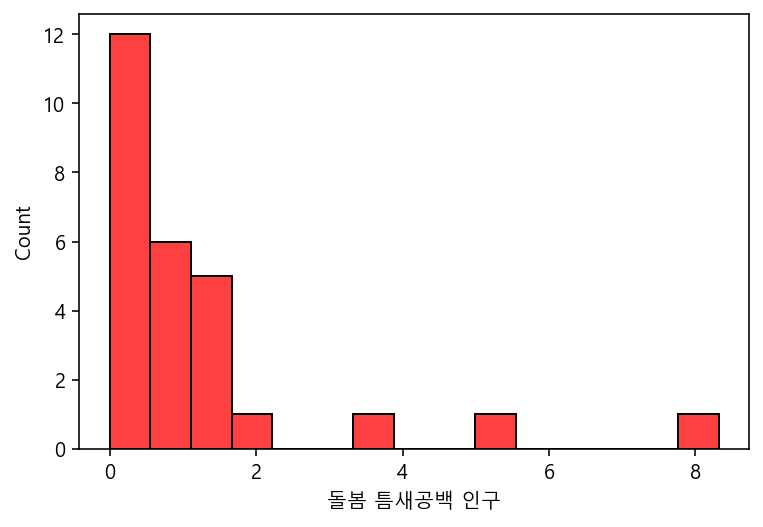

In [106]:
sns.histplot(target_need['돌봄 틈새공백 인구'], color='red')

<AxesSubplot:>

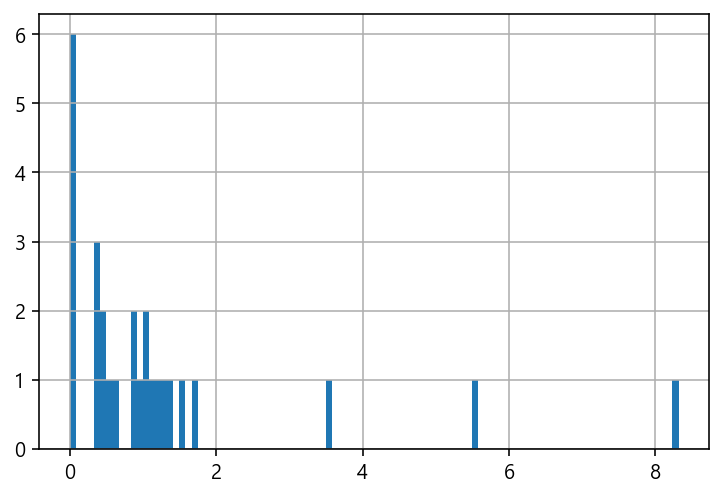

In [107]:
target_need['돌봄 틈새공백 인구'].hist(bins=100)

# 퍼센타일

In [108]:
pt_list = np.percentile(target_need[['돌봄 틈새공백 인구']],[i*10 for i in range(1,10)]).tolist()
pt_list

[0.0,
 0.06910920746453858,
 0.38582958564935166,
 0.4922200096941879,
 0.8508683848023753,
 1.0055206841432753,
 1.1505444605075055,
 1.352628555541596,
 2.4464229023962965]

In [109]:
# 초등돌봄틈새 분위 라벨링
target_need['돌봄틈새공백 분위'] = 0
target_need.loc[target_need['돌봄 틈새공백 인구'] <= pt_list[0], '돌봄틈새공백 분위'] = 1
target_need.loc[(target_need['돌봄 틈새공백 인구'] > pt_list[0]) & (target_need['돌봄 틈새공백 인구'] <= pt_list[1]),'돌봄틈새공백 분위'] = 2
target_need.loc[(target_need['돌봄 틈새공백 인구'] > pt_list[1]) & (target_need['돌봄 틈새공백 인구'] <= pt_list[2]),'돌봄틈새공백 분위'] = 3
target_need.loc[(target_need['돌봄 틈새공백 인구'] > pt_list[2]) & (target_need['돌봄 틈새공백 인구'] <= pt_list[3]),'돌봄틈새공백 분위'] = 4
target_need.loc[(target_need['돌봄 틈새공백 인구'] > pt_list[3]) & (target_need['돌봄 틈새공백 인구'] <= pt_list[4]),'돌봄틈새공백 분위'] = 5
target_need.loc[(target_need['돌봄 틈새공백 인구'] > pt_list[4]) & (target_need['돌봄 틈새공백 인구'] <= pt_list[5]),'돌봄틈새공백 분위'] = 6
target_need.loc[(target_need['돌봄 틈새공백 인구'] > pt_list[5]) & (target_need['돌봄 틈새공백 인구'] <= pt_list[6]),'돌봄틈새공백 분위'] = 7
target_need.loc[(target_need['돌봄 틈새공백 인구'] > pt_list[6]) & (target_need['돌봄 틈새공백 인구'] <= pt_list[7]),'돌봄틈새공백 분위'] = 8
target_need.loc[(target_need['돌봄 틈새공백 인구'] > pt_list[7]) & (target_need['돌봄 틈새공백 인구'] <= pt_list[8]),'돌봄틈새공백 분위'] = 9
target_need.loc[(target_need['돌봄 틈새공백 인구'] > pt_list[8]),'돌봄틈새공백 분위'] = 10
target_need

,gid,행정동코드,시군구명,행정동,학교명,학교개수,초등학생_인구,30대_인구,40대_인구,전체_인구,...,geometry,3040대 인구,3040대 결혼율,3040대 기혼인구,3040대 맞벌이 기혼인구,지역별 3040대 맞벌이 기혼인구 비율,초등돌봄필요 인구,돌봄 틈새공백 인구,지역별 돌봄 틈새공백 인구 비율,돌봄틈새공백 분위
0,다사45bb39bb,1154561000,금천구,독산제1동,"[서울안천초등학교, 서울금나래초등학교]",2,58.0,186.0,125.0,1267.0,...,POINT (126.88802 37.45649),311.0,0.578905,180.039493,89.479628,0.070623,4.096147,0.912716,0.015736,6
1,다사45bb40aa,1154561000,금천구,독산제1동,"[서울안천초등학교, 서울금나래초등학교]",2,37.0,133.0,216.0,1707.0,...,POINT (126.88800 37.45874),349.0,0.578905,202.037888,100.412830,0.058824,2.176494,0.484973,0.013107,4
2,다사45bb40ab,1154561000,금천구,독산제1동,"[서울두산초등학교, 서울안천초등학교, 서울금나래초등학교]",3,19.0,44.0,48.0,284.0,...,POINT (126.88798 37.46100),92.0,0.578905,53.259271,26.469858,0.093204,1.770871,0.394591,0.020768,4
3,다사46aa39ba,1154561000,금천구,독산제1동,"[서울안천초등학교, 서울금나래초등학교]",2,61.0,237.0,229.0,1760.0,...,POINT (126.89086 37.45425),466.0,0.578905,269.769788,134.075584,0.076179,4.646938,1.035445,0.016975,7
4,다사46aa39bb,1154561000,금천구,독산제1동,"[서울안천초등학교, 서울금나래초등학교]",2,62.0,130.0,175.0,1179.0,...,POINT (126.89084 37.45650),305.0,0.578905,176.566063,87.753333,0.074430,4.614679,1.028257,0.016585,7
5,다사46aa40aa,1154561000,금천구,독산제1동,"[서울안천초등학교, 서울금나래초등학교]",2,0.0,0.0,0.0,0.0,...,POINT (126.89082 37.45876),0.0,0.578905,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
6,다사46aa40ab,1154561000,금천구,독산제1동,"[서울두산초등학교, 서울안천초등학교, 서울금나래초등학교]",3,71.0,290.0,265.0,1654.0,...,POINT (126.89081 37.46101),555.0,0.578905,321.292343,159.682295,0.096543,6.854560,1.527355,0.021512,9
7,다사46aa40ba,1154561000,금천구,독산제1동,"[서울두산초등학교, 서울독산초등학교, 서울안천초등학교, 서울금나래초등학교]",4,55.0,312.0,250.0,1450.0,...,POINT (126.89079 37.46326),562.0,0.578905,325.344679,161.696306,0.111515,6.133308,1.366643,0.024848,9
8,다사46aa40bb,1154561000,금천구,독산제1동,"[서울두산초등학교, 서울독산초등학교, 서울안천초등학교]",3,14.0,205.0,108.0,813.0,...,POINT (126.89077 37.46552),313.0,0.578905,181.197304,90.055060,0.110769,1.550764,0.345546,0.024682,3
9,다사46aa41aa,1154561000,금천구,독산제1동,"[서울두산초등학교, 서울독산초등학교]",2,15.0,185.0,91.0,635.0,...,POINT (126.89075 37.46777),276.0,0.578905,159.777814,79.409574,0.125054,1.875817,0.417975,0.027865,4


In [110]:
target_need.sort_values(by='돌봄 틈새공백 인구',ascending=False)

,gid,행정동코드,시군구명,행정동,학교명,학교개수,초등학생_인구,30대_인구,40대_인구,전체_인구,...,geometry,3040대 인구,3040대 결혼율,3040대 기혼인구,3040대 맞벌이 기혼인구,지역별 3040대 맞벌이 기혼인구 비율,초등돌봄필요 인구,돌봄 틈새공백 인구,지역별 돌봄 틈새공백 인구 비율,돌봄틈새공백 분위
19,다사46ba40ab,1154561000,금천구,독산제1동,"[서울두산초등학교, 서울독산초등학교, 서울안천초등학교, 서울금나래초등학교]",4,294.0,1382.0,1026.0,5457.0,...,POINT (126.89646 37.46104),2408.0,0.578905,1394.003537,692.819758,0.126960,37.326188,8.317139,0.028290,10
12,다사46ab40aa,1154561000,금천구,독산제1동,"[서울안천초등학교, 서울금나래초등학교]",2,252.0,566.0,641.0,3552.0,...,POINT (126.89365 37.45877),1207.0,0.578905,698.738484,347.273027,0.097768,24.637613,5.489831,0.021785,10
13,다사46ab40ab,1154561000,금천구,독산제1동,"[서울두산초등학교, 서울독산초등학교, 서울안천초등학교, 서울금나래초등학교]",4,175.0,320.0,356.0,2128.0,...,POINT (126.89363 37.46103),676.0,0.578905,391.339863,194.495912,0.091398,15.994730,3.563996,0.020366,10
16,다사46ab41aa,1154561000,금천구,독산제1동,"[서울두산초등학교, 서울독산초등학교]",2,69.0,580.0,400.0,2548.0,...,POINT (126.89358 37.46779),980.0,0.578905,567.327021,281.961529,0.110660,7.635536,1.701374,0.024658,9
6,다사46aa40ab,1154561000,금천구,독산제1동,"[서울두산초등학교, 서울안천초등학교, 서울금나래초등학교]",3,71.0,290.0,265.0,1654.0,...,POINT (126.89081 37.46101),555.0,0.578905,321.292343,159.682295,0.096543,6.854560,1.527355,0.021512,9
7,다사46aa40ba,1154561000,금천구,독산제1동,"[서울두산초등학교, 서울독산초등학교, 서울안천초등학교, 서울금나래초등학교]",4,55.0,312.0,250.0,1450.0,...,POINT (126.89079 37.46326),562.0,0.578905,325.344679,161.696306,0.111515,6.133308,1.366643,0.024848,9
15,다사46ab40bb,1154561000,금천구,독산제1동,"[서울두산초등학교, 서울독산초등학교, 서울금나래초등학교]",3,50.0,599.0,339.0,2319.0,...,POINT (126.89360 37.46553),938.0,0.578905,543.013006,269.877464,0.116377,5.818833,1.296571,0.025931,8
18,다사46ba40aa,1154561000,금천구,독산제1동,"[서울독산초등학교, 서울안천초등학교, 서울시흥초등학교, 서울금나래초등학교]",4,47.0,145.0,116.0,667.0,...,POINT (126.89648 37.45879),261.0,0.578905,151.094237,75.093836,0.112584,5.291470,1.179062,0.025086,8
17,다사46ab41ab,1154561000,금천구,독산제1동,"[서울두산초등학교, 서울문성초등학교, 서울독산초등학교]",3,46.0,271.0,228.0,1287.0,...,POINT (126.89356 37.47004),499.0,0.578905,288.873657,143.570207,0.111554,5.131491,1.143415,0.024857,7
3,다사46aa39ba,1154561000,금천구,독산제1동,"[서울안천초등학교, 서울금나래초등학교]",2,61.0,237.0,229.0,1760.0,...,POINT (126.89086 37.45425),466.0,0.578905,269.769788,134.075584,0.076179,4.646938,1.035445,0.016975,7


In [111]:
target_df = target_need[['gid', '행정동코드', '시군구명', '행정동', '학교명', '학교개수', '초등학생_인구', '30대_인구',
       '40대_인구', '전체_인구', '경도', '위도', 'geometry', '돌봄 틈새공백 인구', '지역별 돌봄 틈새공백 인구 비율', '돌봄틈새공백 분위']]
target_df

,gid,행정동코드,시군구명,행정동,학교명,학교개수,초등학생_인구,30대_인구,40대_인구,전체_인구,경도,위도,geometry,돌봄 틈새공백 인구,지역별 돌봄 틈새공백 인구 비율,돌봄틈새공백 분위
0,다사45bb39bb,1154561000,금천구,독산제1동,"[서울안천초등학교, 서울금나래초등학교]",2,58.0,186.0,125.0,1267.0,126.888015,37.456490,POINT (126.88802 37.45649),0.912716,0.015736,6
1,다사45bb40aa,1154561000,금천구,독산제1동,"[서울안천초등학교, 서울금나래초등학교]",2,37.0,133.0,216.0,1707.0,126.887997,37.458743,POINT (126.88800 37.45874),0.484973,0.013107,4
2,다사45bb40ab,1154561000,금천구,독산제1동,"[서울두산초등학교, 서울안천초등학교, 서울금나래초등학교]",3,19.0,44.0,48.0,284.0,126.887979,37.460996,POINT (126.88798 37.46100),0.394591,0.020768,4
3,다사46aa39ba,1154561000,금천구,독산제1동,"[서울안천초등학교, 서울금나래초등학교]",2,61.0,237.0,229.0,1760.0,126.890860,37.454251,POINT (126.89086 37.45425),1.035445,0.016975,7
4,다사46aa39bb,1154561000,금천구,독산제1동,"[서울안천초등학교, 서울금나래초등학교]",2,62.0,130.0,175.0,1179.0,126.890842,37.456504,POINT (126.89084 37.45650),1.028257,0.016585,7
5,다사46aa40aa,1154561000,금천구,독산제1동,"[서울안천초등학교, 서울금나래초등학교]",2,0.0,0.0,0.0,0.0,126.890824,37.458758,POINT (126.89082 37.45876),0.000000,0.000000,1
6,다사46aa40ab,1154561000,금천구,독산제1동,"[서울두산초등학교, 서울안천초등학교, 서울금나래초등학교]",3,71.0,290.0,265.0,1654.0,126.890805,37.461011,POINT (126.89081 37.46101),1.527355,0.021512,9
7,다사46aa40ba,1154561000,금천구,독산제1동,"[서울두산초등학교, 서울독산초등학교, 서울안천초등학교, 서울금나래초등학교]",4,55.0,312.0,250.0,1450.0,126.890787,37.463264,POINT (126.89079 37.46326),1.366643,0.024848,9
8,다사46aa40bb,1154561000,금천구,독산제1동,"[서울두산초등학교, 서울독산초등학교, 서울안천초등학교]",3,14.0,205.0,108.0,813.0,126.890769,37.465518,POINT (126.89077 37.46552),0.345546,0.024682,3
9,다사46aa41aa,1154561000,금천구,독산제1동,"[서울두산초등학교, 서울독산초등학교]",2,15.0,185.0,91.0,635.0,126.890751,37.467771,POINT (126.89075 37.46777),0.417975,0.027865,4


In [112]:
target_df.to_csv('금천구 돌봄틈새공백.csv')
target_df.to_pickle('금천구 돌봄틈새공백.pkl')

In [113]:
종암동

NameError: name '종암동' is not defined

### 종암동

In [114]:
target = pklopen('종암동_초등학교881m_인구.pickle')
target

C:\anaconda3\lib\site-packages\pyproj\crs\crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


,gid,행정동코드,시군구명,행정동,학교명,학교개수,초등학생_인구,30대_인구,40대_인구,전체_인구,경도,위도,geometry
0,다사58aa55aa,1129070500,성북구,종암동,"[서울개운초등학교, 서울숭례초등학교, 성신초등학교, 매원초등학교]",4,0.0,0.0,0.0,0.0,127.025650,37.594579,POINT (127.02565 37.59458)
1,다사58ab54bb,1129070500,성북구,종암동,"[서울안암초등학교, 서울숭례초등학교, 성신초등학교]",3,0.0,0.0,0.0,0.0,127.028496,37.592337,POINT (127.02850 37.59234)
2,다사58ab55aa,1129070500,성북구,종암동,"[서울개운초등학교, 서울숭례초등학교, 성신초등학교, 매원초등학교]",4,0.0,0.0,0.0,0.0,127.028482,37.594590,POINT (127.02848 37.59459)
3,다사58ab55ab,1129070500,성북구,종암동,"[서울개운초등학교, 서울숭례초등학교, 성신초등학교, 매원초등학교]",4,8.0,50.0,29.0,326.0,127.028468,37.596844,POINT (127.02847 37.59684)
4,다사58ab55ba,1129070500,성북구,종암동,"[서울개운초등학교, 서울숭례초등학교, 성신초등학교, 매원초등학교]",4,62.0,239.0,285.0,2121.0,127.028454,37.599097,POINT (127.02845 37.59910)
5,다사58ab55bb,1129070500,성북구,종암동,"[서울숭곡초등학교, 서울개운초등학교, 매원초등학교]",3,183.0,207.0,450.0,2329.0,127.028439,37.601350,POINT (127.02844 37.60135)
6,다사58ba54bb,1129070500,성북구,종암동,"[서울숭례초등학교, 성신초등학교]",2,0.0,0.0,0.0,0.0,127.031328,37.592348,POINT (127.03133 37.59235)
7,다사58ba55aa,1129070500,성북구,종암동,"[서울개운초등학교, 서울숭례초등학교, 성신초등학교]",3,12.0,69.0,57.0,430.0,127.031314,37.594602,POINT (127.03131 37.59460)
8,다사58ba55ab,1129070500,성북구,종암동,"[서울개운초등학교, 서울일신초등학교, 서울숭례초등학교, 성신초등학교]",4,170.0,284.0,412.0,2636.0,127.031300,37.596855,POINT (127.03130 37.59685)
9,다사58ba55ba,1129070500,성북구,종암동,"[서울개운초등학교, 서울일신초등학교, 서울숭례초등학교]",3,188.0,443.0,634.0,3386.0,127.031286,37.599108,POINT (127.03129 37.59911)


In [115]:
# target = target[target.시군구명=='금천구']
# target

In [116]:
married_rate_gu_df

,시군구명,3040대 결혼율
0,합계,0.634570
1,종로구,0.588887
2,중구,0.557223
3,용산구,0.593661
4,성동구,0.628100
5,광진구,0.593863
6,동대문구,0.604736
7,중랑구,0.598189
8,성북구,0.662632
9,강북구,0.575451


In [117]:
# married_rate_gu_df[married_rate_gu_df['시군구명']=='은평구']['3040대 결혼율'].iloc[0]

In [118]:
target['3040대 인구'] = target['30대_인구']+target['40대_인구']
target_need = pd.merge(target, married_rate_gu_df, on='시군구명')
target_need

,gid,행정동코드,시군구명,행정동,학교명,학교개수,초등학생_인구,30대_인구,40대_인구,전체_인구,경도,위도,geometry,3040대 인구,3040대 결혼율
0,다사58aa55aa,1129070500,성북구,종암동,"[서울개운초등학교, 서울숭례초등학교, 성신초등학교, 매원초등학교]",4,0.0,0.0,0.0,0.0,127.025650,37.594579,POINT (127.02565 37.59458),0.0,0.662632
1,다사58ab54bb,1129070500,성북구,종암동,"[서울안암초등학교, 서울숭례초등학교, 성신초등학교]",3,0.0,0.0,0.0,0.0,127.028496,37.592337,POINT (127.02850 37.59234),0.0,0.662632
2,다사58ab55aa,1129070500,성북구,종암동,"[서울개운초등학교, 서울숭례초등학교, 성신초등학교, 매원초등학교]",4,0.0,0.0,0.0,0.0,127.028482,37.594590,POINT (127.02848 37.59459),0.0,0.662632
3,다사58ab55ab,1129070500,성북구,종암동,"[서울개운초등학교, 서울숭례초등학교, 성신초등학교, 매원초등학교]",4,8.0,50.0,29.0,326.0,127.028468,37.596844,POINT (127.02847 37.59684),79.0,0.662632
4,다사58ab55ba,1129070500,성북구,종암동,"[서울개운초등학교, 서울숭례초등학교, 성신초등학교, 매원초등학교]",4,62.0,239.0,285.0,2121.0,127.028454,37.599097,POINT (127.02845 37.59910),524.0,0.662632
5,다사58ab55bb,1129070500,성북구,종암동,"[서울숭곡초등학교, 서울개운초등학교, 매원초등학교]",3,183.0,207.0,450.0,2329.0,127.028439,37.601350,POINT (127.02844 37.60135),657.0,0.662632
6,다사58ba54bb,1129070500,성북구,종암동,"[서울숭례초등학교, 성신초등학교]",2,0.0,0.0,0.0,0.0,127.031328,37.592348,POINT (127.03133 37.59235),0.0,0.662632
7,다사58ba55aa,1129070500,성북구,종암동,"[서울개운초등학교, 서울숭례초등학교, 성신초등학교]",3,12.0,69.0,57.0,430.0,127.031314,37.594602,POINT (127.03131 37.59460),126.0,0.662632
8,다사58ba55ab,1129070500,성북구,종암동,"[서울개운초등학교, 서울일신초등학교, 서울숭례초등학교, 성신초등학교]",4,170.0,284.0,412.0,2636.0,127.031300,37.596855,POINT (127.03130 37.59685),696.0,0.662632
9,다사58ba55ba,1129070500,성북구,종암동,"[서울개운초등학교, 서울일신초등학교, 서울숭례초등학교]",3,188.0,443.0,634.0,3386.0,127.031286,37.599108,POINT (127.03129 37.59911),1077.0,0.662632


In [119]:
target_need['3040대 기혼인구'] = target_need['3040대 인구'] * target_need['3040대 결혼율']
target_need

,gid,행정동코드,시군구명,행정동,학교명,학교개수,초등학생_인구,30대_인구,40대_인구,전체_인구,경도,위도,geometry,3040대 인구,3040대 결혼율,3040대 기혼인구
0,다사58aa55aa,1129070500,성북구,종암동,"[서울개운초등학교, 서울숭례초등학교, 성신초등학교, 매원초등학교]",4,0.0,0.0,0.0,0.0,127.025650,37.594579,POINT (127.02565 37.59458),0.0,0.662632,0.000000
1,다사58ab54bb,1129070500,성북구,종암동,"[서울안암초등학교, 서울숭례초등학교, 성신초등학교]",3,0.0,0.0,0.0,0.0,127.028496,37.592337,POINT (127.02850 37.59234),0.0,0.662632,0.000000
2,다사58ab55aa,1129070500,성북구,종암동,"[서울개운초등학교, 서울숭례초등학교, 성신초등학교, 매원초등학교]",4,0.0,0.0,0.0,0.0,127.028482,37.594590,POINT (127.02848 37.59459),0.0,0.662632,0.000000
3,다사58ab55ab,1129070500,성북구,종암동,"[서울개운초등학교, 서울숭례초등학교, 성신초등학교, 매원초등학교]",4,8.0,50.0,29.0,326.0,127.028468,37.596844,POINT (127.02847 37.59684),79.0,0.662632,52.347894
4,다사58ab55ba,1129070500,성북구,종암동,"[서울개운초등학교, 서울숭례초등학교, 성신초등학교, 매원초등학교]",4,62.0,239.0,285.0,2121.0,127.028454,37.599097,POINT (127.02845 37.59910),524.0,0.662632,347.218942
5,다사58ab55bb,1129070500,성북구,종암동,"[서울숭곡초등학교, 서울개운초등학교, 매원초등학교]",3,183.0,207.0,450.0,2329.0,127.028439,37.601350,POINT (127.02844 37.60135),657.0,0.662632,435.348940
6,다사58ba54bb,1129070500,성북구,종암동,"[서울숭례초등학교, 성신초등학교]",2,0.0,0.0,0.0,0.0,127.031328,37.592348,POINT (127.03133 37.59235),0.0,0.662632,0.000000
7,다사58ba55aa,1129070500,성북구,종암동,"[서울개운초등학교, 서울숭례초등학교, 성신초등학교]",3,12.0,69.0,57.0,430.0,127.031314,37.594602,POINT (127.03131 37.59460),126.0,0.662632,83.491578
8,다사58ba55ab,1129070500,성북구,종암동,"[서울개운초등학교, 서울일신초등학교, 서울숭례초등학교, 성신초등학교]",4,170.0,284.0,412.0,2636.0,127.031300,37.596855,POINT (127.03130 37.59685),696.0,0.662632,461.191571
9,다사58ba55ba,1129070500,성북구,종암동,"[서울개운초등학교, 서울일신초등학교, 서울숭례초등학교]",3,188.0,443.0,634.0,3386.0,127.031286,37.599108,POINT (127.03129 37.59911),1077.0,0.662632,713.654199


In [120]:
#맞벌이 비율 곱하기
both_30s = both_rate_df.iloc[2,3]
both_40s = both_rate_df.iloc[3,3]
both_3040s = (both_30s + both_40s)/2
both_3040s


0.497

In [121]:
target_need['3040대 맞벌이 기혼인구'] = (target_need['3040대 기혼인구']*both_3040s)
target_need

,gid,행정동코드,시군구명,행정동,학교명,학교개수,초등학생_인구,30대_인구,40대_인구,전체_인구,경도,위도,geometry,3040대 인구,3040대 결혼율,3040대 기혼인구,3040대 맞벌이 기혼인구
0,다사58aa55aa,1129070500,성북구,종암동,"[서울개운초등학교, 서울숭례초등학교, 성신초등학교, 매원초등학교]",4,0.0,0.0,0.0,0.0,127.025650,37.594579,POINT (127.02565 37.59458),0.0,0.662632,0.000000,0.000000
1,다사58ab54bb,1129070500,성북구,종암동,"[서울안암초등학교, 서울숭례초등학교, 성신초등학교]",3,0.0,0.0,0.0,0.0,127.028496,37.592337,POINT (127.02850 37.59234),0.0,0.662632,0.000000,0.000000
2,다사58ab55aa,1129070500,성북구,종암동,"[서울개운초등학교, 서울숭례초등학교, 성신초등학교, 매원초등학교]",4,0.0,0.0,0.0,0.0,127.028482,37.594590,POINT (127.02848 37.59459),0.0,0.662632,0.000000,0.000000
3,다사58ab55ab,1129070500,성북구,종암동,"[서울개운초등학교, 서울숭례초등학교, 성신초등학교, 매원초등학교]",4,8.0,50.0,29.0,326.0,127.028468,37.596844,POINT (127.02847 37.59684),79.0,0.662632,52.347894,26.016903
4,다사58ab55ba,1129070500,성북구,종암동,"[서울개운초등학교, 서울숭례초등학교, 성신초등학교, 매원초등학교]",4,62.0,239.0,285.0,2121.0,127.028454,37.599097,POINT (127.02845 37.59910),524.0,0.662632,347.218942,172.567814
5,다사58ab55bb,1129070500,성북구,종암동,"[서울숭곡초등학교, 서울개운초등학교, 매원초등학교]",3,183.0,207.0,450.0,2329.0,127.028439,37.601350,POINT (127.02844 37.60135),657.0,0.662632,435.348940,216.368423
6,다사58ba54bb,1129070500,성북구,종암동,"[서울숭례초등학교, 성신초등학교]",2,0.0,0.0,0.0,0.0,127.031328,37.592348,POINT (127.03133 37.59235),0.0,0.662632,0.000000,0.000000
7,다사58ba55aa,1129070500,성북구,종암동,"[서울개운초등학교, 서울숭례초등학교, 성신초등학교]",3,12.0,69.0,57.0,430.0,127.031314,37.594602,POINT (127.03131 37.59460),126.0,0.662632,83.491578,41.495314
8,다사58ba55ab,1129070500,성북구,종암동,"[서울개운초등학교, 서울일신초등학교, 서울숭례초등학교, 성신초등학교]",4,170.0,284.0,412.0,2636.0,127.031300,37.596855,POINT (127.03130 37.59685),696.0,0.662632,461.191571,229.212211
9,다사58ba55ba,1129070500,성북구,종암동,"[서울개운초등학교, 서울일신초등학교, 서울숭례초등학교]",3,188.0,443.0,634.0,3386.0,127.031286,37.599108,POINT (127.03129 37.59911),1077.0,0.662632,713.654199,354.686137


In [122]:
target_need['지역별 3040대 맞벌이 기혼인구 비율'] = target_need['3040대 맞벌이 기혼인구']/target_need['전체_인구']
target_need = target_need.fillna(0)
target_need

,gid,행정동코드,시군구명,행정동,학교명,학교개수,초등학생_인구,30대_인구,40대_인구,전체_인구,경도,위도,geometry,3040대 인구,3040대 결혼율,3040대 기혼인구,3040대 맞벌이 기혼인구,지역별 3040대 맞벌이 기혼인구 비율
0,다사58aa55aa,1129070500,성북구,종암동,"[서울개운초등학교, 서울숭례초등학교, 성신초등학교, 매원초등학교]",4,0.0,0.0,0.0,0.0,127.025650,37.594579,POINT (127.02565 37.59458),0.0,0.662632,0.000000,0.000000,0.000000
1,다사58ab54bb,1129070500,성북구,종암동,"[서울안암초등학교, 서울숭례초등학교, 성신초등학교]",3,0.0,0.0,0.0,0.0,127.028496,37.592337,POINT (127.02850 37.59234),0.0,0.662632,0.000000,0.000000,0.000000
2,다사58ab55aa,1129070500,성북구,종암동,"[서울개운초등학교, 서울숭례초등학교, 성신초등학교, 매원초등학교]",4,0.0,0.0,0.0,0.0,127.028482,37.594590,POINT (127.02848 37.59459),0.0,0.662632,0.000000,0.000000,0.000000
3,다사58ab55ab,1129070500,성북구,종암동,"[서울개운초등학교, 서울숭례초등학교, 성신초등학교, 매원초등학교]",4,8.0,50.0,29.0,326.0,127.028468,37.596844,POINT (127.02847 37.59684),79.0,0.662632,52.347894,26.016903,0.079806
4,다사58ab55ba,1129070500,성북구,종암동,"[서울개운초등학교, 서울숭례초등학교, 성신초등학교, 매원초등학교]",4,62.0,239.0,285.0,2121.0,127.028454,37.599097,POINT (127.02845 37.59910),524.0,0.662632,347.218942,172.567814,0.081362
5,다사58ab55bb,1129070500,성북구,종암동,"[서울숭곡초등학교, 서울개운초등학교, 매원초등학교]",3,183.0,207.0,450.0,2329.0,127.028439,37.601350,POINT (127.02844 37.60135),657.0,0.662632,435.348940,216.368423,0.092902
6,다사58ba54bb,1129070500,성북구,종암동,"[서울숭례초등학교, 성신초등학교]",2,0.0,0.0,0.0,0.0,127.031328,37.592348,POINT (127.03133 37.59235),0.0,0.662632,0.000000,0.000000,0.000000
7,다사58ba55aa,1129070500,성북구,종암동,"[서울개운초등학교, 서울숭례초등학교, 성신초등학교]",3,12.0,69.0,57.0,430.0,127.031314,37.594602,POINT (127.03131 37.59460),126.0,0.662632,83.491578,41.495314,0.096501
8,다사58ba55ab,1129070500,성북구,종암동,"[서울개운초등학교, 서울일신초등학교, 서울숭례초등학교, 성신초등학교]",4,170.0,284.0,412.0,2636.0,127.031300,37.596855,POINT (127.03130 37.59685),696.0,0.662632,461.191571,229.212211,0.086955
9,다사58ba55ba,1129070500,성북구,종암동,"[서울개운초등학교, 서울일신초등학교, 서울숭례초등학교]",3,188.0,443.0,634.0,3386.0,127.031286,37.599108,POINT (127.03129 37.59911),1077.0,0.662632,713.654199,354.686137,0.104751


In [123]:
target_need['초등돌봄필요 인구'] = target_need['초등학생_인구']*target_need['지역별 3040대 맞벌이 기혼인구 비율']
target_need = target_need.fillna(0)
target_need

,gid,행정동코드,시군구명,행정동,학교명,학교개수,초등학생_인구,30대_인구,40대_인구,전체_인구,경도,위도,geometry,3040대 인구,3040대 결혼율,3040대 기혼인구,3040대 맞벌이 기혼인구,지역별 3040대 맞벌이 기혼인구 비율,초등돌봄필요 인구
0,다사58aa55aa,1129070500,성북구,종암동,"[서울개운초등학교, 서울숭례초등학교, 성신초등학교, 매원초등학교]",4,0.0,0.0,0.0,0.0,127.025650,37.594579,POINT (127.02565 37.59458),0.0,0.662632,0.000000,0.000000,0.000000,0.000000
1,다사58ab54bb,1129070500,성북구,종암동,"[서울안암초등학교, 서울숭례초등학교, 성신초등학교]",3,0.0,0.0,0.0,0.0,127.028496,37.592337,POINT (127.02850 37.59234),0.0,0.662632,0.000000,0.000000,0.000000,0.000000
2,다사58ab55aa,1129070500,성북구,종암동,"[서울개운초등학교, 서울숭례초등학교, 성신초등학교, 매원초등학교]",4,0.0,0.0,0.0,0.0,127.028482,37.594590,POINT (127.02848 37.59459),0.0,0.662632,0.000000,0.000000,0.000000,0.000000
3,다사58ab55ab,1129070500,성북구,종암동,"[서울개운초등학교, 서울숭례초등학교, 성신초등학교, 매원초등학교]",4,8.0,50.0,29.0,326.0,127.028468,37.596844,POINT (127.02847 37.59684),79.0,0.662632,52.347894,26.016903,0.079806,0.638452
4,다사58ab55ba,1129070500,성북구,종암동,"[서울개운초등학교, 서울숭례초등학교, 성신초등학교, 매원초등학교]",4,62.0,239.0,285.0,2121.0,127.028454,37.599097,POINT (127.02845 37.59910),524.0,0.662632,347.218942,172.567814,0.081362,5.044415
5,다사58ab55bb,1129070500,성북구,종암동,"[서울숭곡초등학교, 서울개운초등학교, 매원초등학교]",3,183.0,207.0,450.0,2329.0,127.028439,37.601350,POINT (127.02844 37.60135),657.0,0.662632,435.348940,216.368423,0.092902,17.001040
6,다사58ba54bb,1129070500,성북구,종암동,"[서울숭례초등학교, 성신초등학교]",2,0.0,0.0,0.0,0.0,127.031328,37.592348,POINT (127.03133 37.59235),0.0,0.662632,0.000000,0.000000,0.000000,0.000000
7,다사58ba55aa,1129070500,성북구,종암동,"[서울개운초등학교, 서울숭례초등학교, 성신초등학교]",3,12.0,69.0,57.0,430.0,127.031314,37.594602,POINT (127.03131 37.59460),126.0,0.662632,83.491578,41.495314,0.096501,1.158009
8,다사58ba55ab,1129070500,성북구,종암동,"[서울개운초등학교, 서울일신초등학교, 서울숭례초등학교, 성신초등학교]",4,170.0,284.0,412.0,2636.0,127.031300,37.596855,POINT (127.03130 37.59685),696.0,0.662632,461.191571,229.212211,0.086955,14.782275
9,다사58ba55ba,1129070500,성북구,종암동,"[서울개운초등학교, 서울일신초등학교, 서울숭례초등학교]",3,188.0,443.0,634.0,3386.0,127.031286,37.599108,POINT (127.03129 37.59911),1077.0,0.662632,713.654199,354.686137,0.104751,19.693146


In [124]:
target_need['돌봄 틈새공백 인구'] = target_need['초등돌봄필요 인구'] * AR
target_need = target_need.fillna(0)
target_need

,gid,행정동코드,시군구명,행정동,학교명,학교개수,초등학생_인구,30대_인구,40대_인구,전체_인구,경도,위도,geometry,3040대 인구,3040대 결혼율,3040대 기혼인구,3040대 맞벌이 기혼인구,지역별 3040대 맞벌이 기혼인구 비율,초등돌봄필요 인구,돌봄 틈새공백 인구
0,다사58aa55aa,1129070500,성북구,종암동,"[서울개운초등학교, 서울숭례초등학교, 성신초등학교, 매원초등학교]",4,0.0,0.0,0.0,0.0,127.025650,37.594579,POINT (127.02565 37.59458),0.0,0.662632,0.000000,0.000000,0.000000,0.000000,0.000000
1,다사58ab54bb,1129070500,성북구,종암동,"[서울안암초등학교, 서울숭례초등학교, 성신초등학교]",3,0.0,0.0,0.0,0.0,127.028496,37.592337,POINT (127.02850 37.59234),0.0,0.662632,0.000000,0.000000,0.000000,0.000000,0.000000
2,다사58ab55aa,1129070500,성북구,종암동,"[서울개운초등학교, 서울숭례초등학교, 성신초등학교, 매원초등학교]",4,0.0,0.0,0.0,0.0,127.028482,37.594590,POINT (127.02848 37.59459),0.0,0.662632,0.000000,0.000000,0.000000,0.000000,0.000000
3,다사58ab55ab,1129070500,성북구,종암동,"[서울개운초등학교, 서울숭례초등학교, 성신초등학교, 매원초등학교]",4,8.0,50.0,29.0,326.0,127.028468,37.596844,POINT (127.02847 37.59684),79.0,0.662632,52.347894,26.016903,0.079806,0.638452,0.142262
4,다사58ab55ba,1129070500,성북구,종암동,"[서울개운초등학교, 서울숭례초등학교, 성신초등학교, 매원초등학교]",4,62.0,239.0,285.0,2121.0,127.028454,37.599097,POINT (127.02845 37.59910),524.0,0.662632,347.218942,172.567814,0.081362,5.044415,1.124012
5,다사58ab55bb,1129070500,성북구,종암동,"[서울숭곡초등학교, 서울개운초등학교, 매원초등학교]",3,183.0,207.0,450.0,2329.0,127.028439,37.601350,POINT (127.02844 37.60135),657.0,0.662632,435.348940,216.368423,0.092902,17.001040,3.788225
6,다사58ba54bb,1129070500,성북구,종암동,"[서울숭례초등학교, 성신초등학교]",2,0.0,0.0,0.0,0.0,127.031328,37.592348,POINT (127.03133 37.59235),0.0,0.662632,0.000000,0.000000,0.000000,0.000000,0.000000
7,다사58ba55aa,1129070500,성북구,종암동,"[서울개운초등학교, 서울숭례초등학교, 성신초등학교]",3,12.0,69.0,57.0,430.0,127.031314,37.594602,POINT (127.03131 37.59460),126.0,0.662632,83.491578,41.495314,0.096501,1.158009,0.258031
8,다사58ba55ab,1129070500,성북구,종암동,"[서울개운초등학교, 서울일신초등학교, 서울숭례초등학교, 성신초등학교]",4,170.0,284.0,412.0,2636.0,127.031300,37.596855,POINT (127.03130 37.59685),696.0,0.662632,461.191571,229.212211,0.086955,14.782275,3.293833
9,다사58ba55ba,1129070500,성북구,종암동,"[서울개운초등학교, 서울일신초등학교, 서울숭례초등학교]",3,188.0,443.0,634.0,3386.0,127.031286,37.599108,POINT (127.03129 37.59911),1077.0,0.662632,713.654199,354.686137,0.104751,19.693146,4.388089


In [125]:
target_need['지역별 돌봄 틈새공백 인구 비율'] = target_need['돌봄 틈새공백 인구'] /target_need['초등학생_인구']
target_need = target_need.fillna(0)
target_need

,gid,행정동코드,시군구명,행정동,학교명,학교개수,초등학생_인구,30대_인구,40대_인구,전체_인구,...,위도,geometry,3040대 인구,3040대 결혼율,3040대 기혼인구,3040대 맞벌이 기혼인구,지역별 3040대 맞벌이 기혼인구 비율,초등돌봄필요 인구,돌봄 틈새공백 인구,지역별 돌봄 틈새공백 인구 비율
0,다사58aa55aa,1129070500,성북구,종암동,"[서울개운초등학교, 서울숭례초등학교, 성신초등학교, 매원초등학교]",4,0.0,0.0,0.0,0.0,...,37.594579,POINT (127.02565 37.59458),0.0,0.662632,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,다사58ab54bb,1129070500,성북구,종암동,"[서울안암초등학교, 서울숭례초등학교, 성신초등학교]",3,0.0,0.0,0.0,0.0,...,37.592337,POINT (127.02850 37.59234),0.0,0.662632,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,다사58ab55aa,1129070500,성북구,종암동,"[서울개운초등학교, 서울숭례초등학교, 성신초등학교, 매원초등학교]",4,0.0,0.0,0.0,0.0,...,37.594590,POINT (127.02848 37.59459),0.0,0.662632,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,다사58ab55ab,1129070500,성북구,종암동,"[서울개운초등학교, 서울숭례초등학교, 성신초등학교, 매원초등학교]",4,8.0,50.0,29.0,326.0,...,37.596844,POINT (127.02847 37.59684),79.0,0.662632,52.347894,26.016903,0.079806,0.638452,0.142262,0.017783
4,다사58ab55ba,1129070500,성북구,종암동,"[서울개운초등학교, 서울숭례초등학교, 성신초등학교, 매원초등학교]",4,62.0,239.0,285.0,2121.0,...,37.599097,POINT (127.02845 37.59910),524.0,0.662632,347.218942,172.567814,0.081362,5.044415,1.124012,0.018129
5,다사58ab55bb,1129070500,성북구,종암동,"[서울숭곡초등학교, 서울개운초등학교, 매원초등학교]",3,183.0,207.0,450.0,2329.0,...,37.601350,POINT (127.02844 37.60135),657.0,0.662632,435.348940,216.368423,0.092902,17.001040,3.788225,0.020701
6,다사58ba54bb,1129070500,성북구,종암동,"[서울숭례초등학교, 성신초등학교]",2,0.0,0.0,0.0,0.0,...,37.592348,POINT (127.03133 37.59235),0.0,0.662632,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,다사58ba55aa,1129070500,성북구,종암동,"[서울개운초등학교, 서울숭례초등학교, 성신초등학교]",3,12.0,69.0,57.0,430.0,...,37.594602,POINT (127.03131 37.59460),126.0,0.662632,83.491578,41.495314,0.096501,1.158009,0.258031,0.021503
8,다사58ba55ab,1129070500,성북구,종암동,"[서울개운초등학교, 서울일신초등학교, 서울숭례초등학교, 성신초등학교]",4,170.0,284.0,412.0,2636.0,...,37.596855,POINT (127.03130 37.59685),696.0,0.662632,461.191571,229.212211,0.086955,14.782275,3.293833,0.019375
9,다사58ba55ba,1129070500,성북구,종암동,"[서울개운초등학교, 서울일신초등학교, 서울숭례초등학교]",3,188.0,443.0,634.0,3386.0,...,37.599108,POINT (127.03129 37.59911),1077.0,0.662632,713.654199,354.686137,0.104751,19.693146,4.388089,0.023341


<AxesSubplot:xlabel='돌봄 틈새공백 인구', ylabel='Count'>

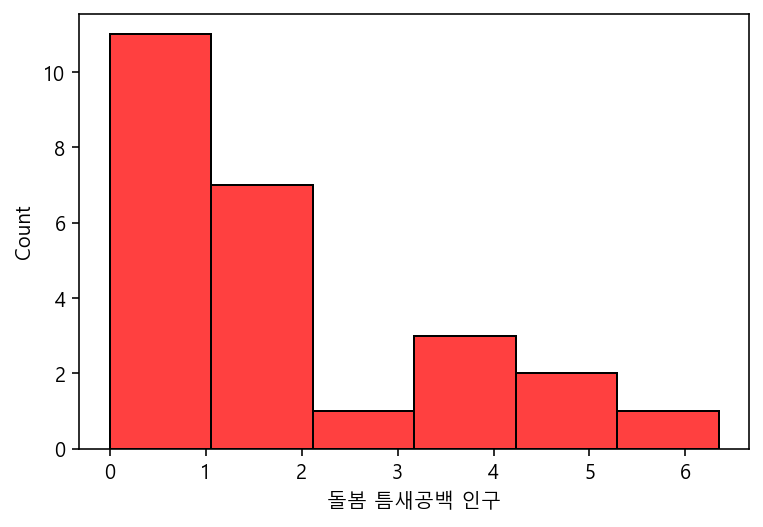

In [126]:
sns.histplot(target_need['돌봄 틈새공백 인구'], color='red')

<AxesSubplot:>

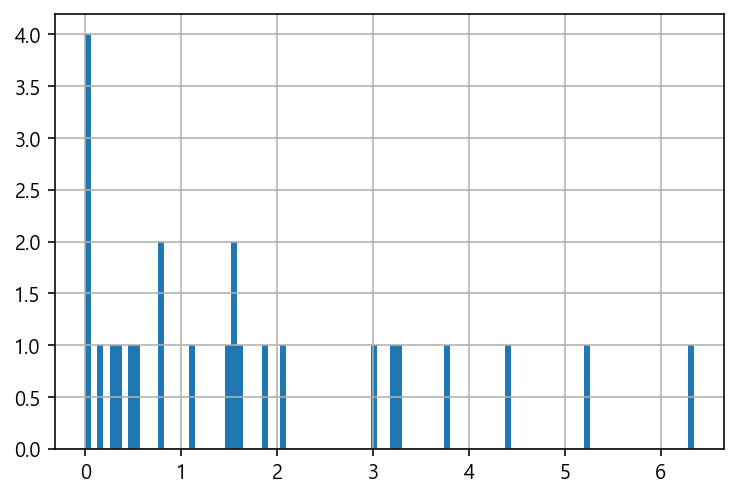

In [127]:
target_need['돌봄 틈새공백 인구'].hist(bins=100)

# 퍼센타일

In [128]:
pt_list = np.percentile(target_need[['돌봄 틈새공백 인구']],[i*10 for i in range(1,10)]).tolist()
pt_list

[0.0,
 0.23487728721966938,
 0.49701510510815683,
 0.7981740981378522,
 1.4659645914840684,
 1.5788586507904263,
 2.042466496266278,
 3.2204612211869272,
 4.148143415547929]

In [129]:
# 초등돌봄틈새 분위 라벨링
target_need['돌봄틈새공백 분위'] = 0
target_need.loc[target_need['돌봄 틈새공백 인구'] <= pt_list[0], '돌봄틈새공백 분위'] = 1
target_need.loc[(target_need['돌봄 틈새공백 인구'] > pt_list[0]) & (target_need['돌봄 틈새공백 인구'] <= pt_list[1]),'돌봄틈새공백 분위'] = 2
target_need.loc[(target_need['돌봄 틈새공백 인구'] > pt_list[1]) & (target_need['돌봄 틈새공백 인구'] <= pt_list[2]),'돌봄틈새공백 분위'] = 3
target_need.loc[(target_need['돌봄 틈새공백 인구'] > pt_list[2]) & (target_need['돌봄 틈새공백 인구'] <= pt_list[3]),'돌봄틈새공백 분위'] = 4
target_need.loc[(target_need['돌봄 틈새공백 인구'] > pt_list[3]) & (target_need['돌봄 틈새공백 인구'] <= pt_list[4]),'돌봄틈새공백 분위'] = 5
target_need.loc[(target_need['돌봄 틈새공백 인구'] > pt_list[4]) & (target_need['돌봄 틈새공백 인구'] <= pt_list[5]),'돌봄틈새공백 분위'] = 6
target_need.loc[(target_need['돌봄 틈새공백 인구'] > pt_list[5]) & (target_need['돌봄 틈새공백 인구'] <= pt_list[6]),'돌봄틈새공백 분위'] = 7
target_need.loc[(target_need['돌봄 틈새공백 인구'] > pt_list[6]) & (target_need['돌봄 틈새공백 인구'] <= pt_list[7]),'돌봄틈새공백 분위'] = 8
target_need.loc[(target_need['돌봄 틈새공백 인구'] > pt_list[7]) & (target_need['돌봄 틈새공백 인구'] <= pt_list[8]),'돌봄틈새공백 분위'] = 9
target_need.loc[(target_need['돌봄 틈새공백 인구'] > pt_list[8]),'돌봄틈새공백 분위'] = 10
target_need

,gid,행정동코드,시군구명,행정동,학교명,학교개수,초등학생_인구,30대_인구,40대_인구,전체_인구,...,geometry,3040대 인구,3040대 결혼율,3040대 기혼인구,3040대 맞벌이 기혼인구,지역별 3040대 맞벌이 기혼인구 비율,초등돌봄필요 인구,돌봄 틈새공백 인구,지역별 돌봄 틈새공백 인구 비율,돌봄틈새공백 분위
0,다사58aa55aa,1129070500,성북구,종암동,"[서울개운초등학교, 서울숭례초등학교, 성신초등학교, 매원초등학교]",4,0.0,0.0,0.0,0.0,...,POINT (127.02565 37.59458),0.0,0.662632,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
1,다사58ab54bb,1129070500,성북구,종암동,"[서울안암초등학교, 서울숭례초등학교, 성신초등학교]",3,0.0,0.0,0.0,0.0,...,POINT (127.02850 37.59234),0.0,0.662632,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
2,다사58ab55aa,1129070500,성북구,종암동,"[서울개운초등학교, 서울숭례초등학교, 성신초등학교, 매원초등학교]",4,0.0,0.0,0.0,0.0,...,POINT (127.02848 37.59459),0.0,0.662632,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
3,다사58ab55ab,1129070500,성북구,종암동,"[서울개운초등학교, 서울숭례초등학교, 성신초등학교, 매원초등학교]",4,8.0,50.0,29.0,326.0,...,POINT (127.02847 37.59684),79.0,0.662632,52.347894,26.016903,0.079806,0.638452,0.142262,0.017783,2
4,다사58ab55ba,1129070500,성북구,종암동,"[서울개운초등학교, 서울숭례초등학교, 성신초등학교, 매원초등학교]",4,62.0,239.0,285.0,2121.0,...,POINT (127.02845 37.59910),524.0,0.662632,347.218942,172.567814,0.081362,5.044415,1.124012,0.018129,5
5,다사58ab55bb,1129070500,성북구,종암동,"[서울숭곡초등학교, 서울개운초등학교, 매원초등학교]",3,183.0,207.0,450.0,2329.0,...,POINT (127.02844 37.60135),657.0,0.662632,435.348940,216.368423,0.092902,17.001040,3.788225,0.020701,9
6,다사58ba54bb,1129070500,성북구,종암동,"[서울숭례초등학교, 성신초등학교]",2,0.0,0.0,0.0,0.0,...,POINT (127.03133 37.59235),0.0,0.662632,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
7,다사58ba55aa,1129070500,성북구,종암동,"[서울개운초등학교, 서울숭례초등학교, 성신초등학교]",3,12.0,69.0,57.0,430.0,...,POINT (127.03131 37.59460),126.0,0.662632,83.491578,41.495314,0.096501,1.158009,0.258031,0.021503,3
8,다사58ba55ab,1129070500,성북구,종암동,"[서울개운초등학교, 서울일신초등학교, 서울숭례초등학교, 성신초등학교]",4,170.0,284.0,412.0,2636.0,...,POINT (127.03130 37.59685),696.0,0.662632,461.191571,229.212211,0.086955,14.782275,3.293833,0.019375,9
9,다사58ba55ba,1129070500,성북구,종암동,"[서울개운초등학교, 서울일신초등학교, 서울숭례초등학교]",3,188.0,443.0,634.0,3386.0,...,POINT (127.03129 37.59911),1077.0,0.662632,713.654199,354.686137,0.104751,19.693146,4.388089,0.023341,10


In [130]:
target_need.sort_values(by='돌봄 틈새공백 인구',ascending=False)

,gid,행정동코드,시군구명,행정동,학교명,학교개수,초등학생_인구,30대_인구,40대_인구,전체_인구,...,geometry,3040대 인구,3040대 결혼율,3040대 기혼인구,3040대 맞벌이 기혼인구,지역별 3040대 맞벌이 기혼인구 비율,초등돌봄필요 인구,돌봄 틈새공백 인구,지역별 돌봄 틈새공백 인구 비율,돌봄틈새공백 분위
21,다사59aa55bb,1129070500,성북구,종암동,"[서울숭곡초등학교, 서울개운초등학교, 서울일신초등학교, 서울숭례초등학교, 서울숭인초...",5,282.0,587.0,734.0,4308.0,...,POINT (127.03694 37.60138),1321.0,0.662632,875.336301,435.042142,0.100985,28.477689,6.345488,0.022502,10
24,다사59ab55ba,1129070500,성북구,종암동,"[서울일신초등학교, 서울숭례초등학교]",2,213.0,228.0,505.0,2190.0,...,POINT (127.03978 37.59914),733.0,0.662632,485.708939,241.397343,0.110227,23.478372,5.231525,0.024561,10
9,다사58ba55ba,1129070500,성북구,종암동,"[서울개운초등학교, 서울일신초등학교, 서울숭례초등학교]",3,188.0,443.0,634.0,3386.0,...,POINT (127.03129 37.59911),1077.0,0.662632,713.654199,354.686137,0.104751,19.693146,4.388089,0.023341,10
5,다사58ab55bb,1129070500,성북구,종암동,"[서울숭곡초등학교, 서울개운초등학교, 매원초등학교]",3,183.0,207.0,450.0,2329.0,...,POINT (127.02844 37.60135),657.0,0.662632,435.348940,216.368423,0.092902,17.001040,3.788225,0.020701,9
8,다사58ba55ab,1129070500,성북구,종암동,"[서울개운초등학교, 서울일신초등학교, 서울숭례초등학교, 성신초등학교]",4,170.0,284.0,412.0,2636.0,...,POINT (127.03130 37.59685),696.0,0.662632,461.191571,229.212211,0.086955,14.782275,3.293833,0.019375,9
10,다사58ba55bb,1129070500,성북구,종암동,"[서울숭곡초등학교, 서울개운초등학교, 서울일신초등학교, 서울숭례초등학교]",4,128.0,504.0,471.0,2860.0,...,POINT (127.03127 37.60136),975.0,0.662632,646.065779,321.094692,0.112271,14.370672,3.202118,0.025017,8
16,다사58bb55bb,1129070500,성북구,종암동,"[서울숭곡초등학교, 서울개운초등학교, 서울일신초등학교, 서울숭례초등학교]",4,127.0,242.0,419.0,2027.0,...,POINT (127.03410 37.60137),661.0,0.662632,437.999466,217.685735,0.107393,13.638919,3.039067,0.023930,8
13,다사58bb55aa,1129070500,성북구,종암동,"[서울일신초등학교, 서울숭례초등학교]",2,101.0,409.0,346.0,2679.0,...,POINT (127.03415 37.59461),755.0,0.662632,500.286834,248.642556,0.092812,9.373982,2.088740,0.020681,8
20,다사59aa55ba,1129070500,성북구,종암동,"[서울개운초등학교, 서울일신초등학교, 서울숭례초등학교]",3,101.0,254.0,368.0,2482.0,...,POINT (127.03695 37.59913),622.0,0.662632,412.156835,204.841947,0.082531,8.335631,1.857372,0.018390,7
19,다사59aa55ab,1129070500,성북구,종암동,"[서울일신초등학교, 서울숭례초등학교]",2,81.0,393.0,355.0,2706.0,...,POINT (127.03696 37.59688),748.0,0.662632,495.648413,246.337261,0.091034,7.373732,1.643038,0.020284,7


In [131]:
target_df = target_need[['gid', '행정동코드', '시군구명', '행정동', '학교명', '학교개수', '초등학생_인구', '30대_인구',
       '40대_인구', '전체_인구', '경도', '위도', 'geometry', '돌봄 틈새공백 인구', '지역별 돌봄 틈새공백 인구 비율', '돌봄틈새공백 분위']]
target_df

,gid,행정동코드,시군구명,행정동,학교명,학교개수,초등학생_인구,30대_인구,40대_인구,전체_인구,경도,위도,geometry,돌봄 틈새공백 인구,지역별 돌봄 틈새공백 인구 비율,돌봄틈새공백 분위
0,다사58aa55aa,1129070500,성북구,종암동,"[서울개운초등학교, 서울숭례초등학교, 성신초등학교, 매원초등학교]",4,0.0,0.0,0.0,0.0,127.025650,37.594579,POINT (127.02565 37.59458),0.000000,0.000000,1
1,다사58ab54bb,1129070500,성북구,종암동,"[서울안암초등학교, 서울숭례초등학교, 성신초등학교]",3,0.0,0.0,0.0,0.0,127.028496,37.592337,POINT (127.02850 37.59234),0.000000,0.000000,1
2,다사58ab55aa,1129070500,성북구,종암동,"[서울개운초등학교, 서울숭례초등학교, 성신초등학교, 매원초등학교]",4,0.0,0.0,0.0,0.0,127.028482,37.594590,POINT (127.02848 37.59459),0.000000,0.000000,1
3,다사58ab55ab,1129070500,성북구,종암동,"[서울개운초등학교, 서울숭례초등학교, 성신초등학교, 매원초등학교]",4,8.0,50.0,29.0,326.0,127.028468,37.596844,POINT (127.02847 37.59684),0.142262,0.017783,2
4,다사58ab55ba,1129070500,성북구,종암동,"[서울개운초등학교, 서울숭례초등학교, 성신초등학교, 매원초등학교]",4,62.0,239.0,285.0,2121.0,127.028454,37.599097,POINT (127.02845 37.59910),1.124012,0.018129,5
5,다사58ab55bb,1129070500,성북구,종암동,"[서울숭곡초등학교, 서울개운초등학교, 매원초등학교]",3,183.0,207.0,450.0,2329.0,127.028439,37.601350,POINT (127.02844 37.60135),3.788225,0.020701,9
6,다사58ba54bb,1129070500,성북구,종암동,"[서울숭례초등학교, 성신초등학교]",2,0.0,0.0,0.0,0.0,127.031328,37.592348,POINT (127.03133 37.59235),0.000000,0.000000,1
7,다사58ba55aa,1129070500,성북구,종암동,"[서울개운초등학교, 서울숭례초등학교, 성신초등학교]",3,12.0,69.0,57.0,430.0,127.031314,37.594602,POINT (127.03131 37.59460),0.258031,0.021503,3
8,다사58ba55ab,1129070500,성북구,종암동,"[서울개운초등학교, 서울일신초등학교, 서울숭례초등학교, 성신초등학교]",4,170.0,284.0,412.0,2636.0,127.031300,37.596855,POINT (127.03130 37.59685),3.293833,0.019375,9
9,다사58ba55ba,1129070500,성북구,종암동,"[서울개운초등학교, 서울일신초등학교, 서울숭례초등학교]",3,188.0,443.0,634.0,3386.0,127.031286,37.599108,POINT (127.03129 37.59911),4.388089,0.023341,10


In [132]:
target_df.to_csv('종암동 돌봄틈새공백.csv')
target_df.to_pickle('종암동 돌봄틈새공백.pkl')